In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("C:/Users/dell/Desktop/hessi.solar.flare.UP_To_2018.csv/hessi.solar.flare.UP_To_2018.csv")

In [628]:
df.head()

flare  start.date start.time      peak       end  duration.s  peak.c/s  \
0  2021213  2002-02-12   21:29:56  21:33:38  21:41:48         712       136   
1  2021228  2002-02-12   21:44:08  21:45:06  21:48:56         288         7   
2  2021332  2002-02-13   00:53:24  00:54:54  00:57:00         216        15   
3  2021308  2002-02-13   04:22:52  04:23:50  04:26:56         244        20   
4  2021310  2002-02-13   07:03:52  07:05:14  07:07:48         236       336   

   total.counts energy.kev  x.pos.asec  y.pos.asec  radial  active.region.ar  \
0      167304.0      12-25         592        -358     692                 0   
1        9504.0       6-12         604        -341     694              9811   
2       11448.0       6-12        -310         375     487              9825   
3       17400.0      12-25        -277         378     469              9822   
4      313392.0      25-50        -272         390     476              9825   

  flag.1 flag.2 flag.3 flag.4 flag.5  
0     A1     P1    NaN    NaN    NaN  
1     A1     P1     PE     Q1    NaN  
2     A1     P1    NaN    NaN    NaN  
3     A1     P1    NaN    NaN    NaN  
4     A1     GS     P1     PE     Q2

In [629]:
df.shape

(116143, 18)

In [630]:
df.describe()

flare     duration.s       peak.c/s  total.counts  \
count  1.161430e+05  116143.000000  116143.000000  1.161430e+05   
mean   1.099563e+07     493.643009     215.086617  3.768843e+05   
std    9.888161e+06     434.131763     839.382841  3.048797e+06   
min    2.021213e+06       8.000000       0.000000  8.000000e+00   
25%    4.112632e+06     212.000000      28.000000  2.284000e+04   
50%    1.112297e+07     364.000000      56.000000  5.856000e+04   
75%    1.404222e+07     628.000000     144.000000  1.798080e+05   
max    1.711151e+08    4444.000000  113156.000000  4.355501e+08   

          x.pos.asec     y.pos.asec         radial  active.region.ar  
count  116143.000000  116143.000000  116143.000000     116143.000000  
mean       -7.681625     -42.185495     687.896989        990.071550  
std       755.773503     401.904509     511.364382       1351.853636  
min    -10012.000000  -10005.000000       0.000000          0.000000  
25%      -701.000000    -247.000000     467.000000          0.000000  
50%         0.000000     -71.000000     759.000000        691.000000  
75%       708.000000     198.000000     946.000000       1564.000000  
max      1190.000000    1223.000000   14154.000000       9999.000000

In [631]:
df.isna().sum()

flare                   0
start.date              0
start.time              0
peak                    0
end                     0
duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19907
flag.4              20202
flag.5              61180
dtype: int64

In [3]:
# Creating useful columns

order=['3-6','6-12', '12-25','25-50', '50-100', '100-300', '300-800','800-7000', '7000-20000']
df['energy.kev'] = pd.Categorical(df['energy.kev'], categories= order, ordered=True)

df['year']=pd.to_datetime(df['start.date']).dt.year

df['month']=pd.to_datetime(df['start.date']).dt.month

In [4]:
# Melting data for plotting purpose

monthly_data = df.groupby(['year','month'])['total.counts'].sum().reset_index()

melted_df = pd.melt(monthly_data, id_vars=['year', 'month'], value_vars='total.counts',
                     var_name='Metric', value_name='Value')

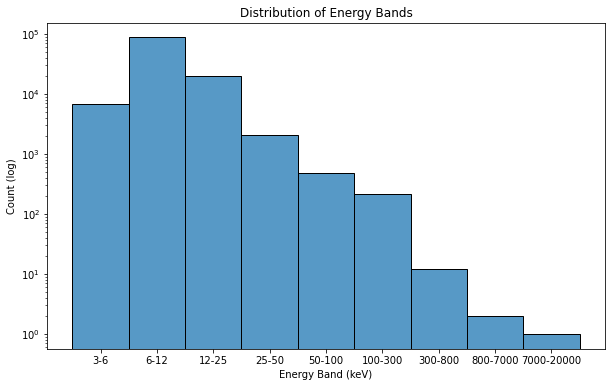

In [634]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['energy.kev'])
plt.yscale('log')
plt.xlabel('Energy Band (keV)')
plt.ylabel('Count (log)')
plt.title('Distribution of Energy Bands')
plt.show()

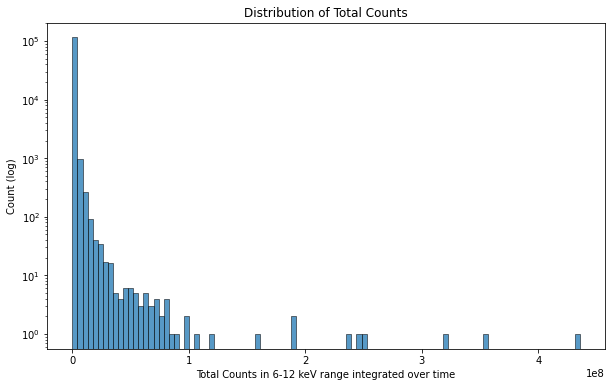

In [310]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['total.counts'], bins=100)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Total Counts in 6-12 keV range integrated over time')
plt.ylabel('Count (log)')
plt.title('Distribution of Total Counts')
plt.show()

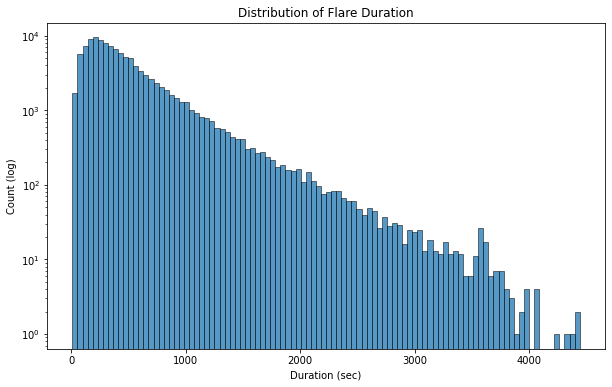

In [636]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['duration.s'], bins=100)
plt.yscale('log')
plt.xlabel('Duration (sec)')
plt.ylabel('Count (log)')
plt.title('Distribution of Flare Duration')
plt.show()

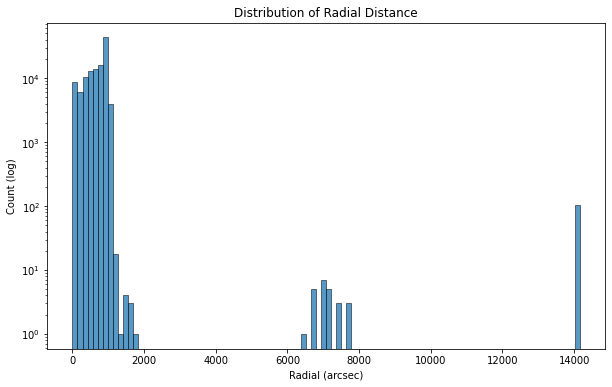

In [637]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['radial'], bins=100)
plt.yscale('log')
plt.xlabel('Radial (arcsec)')
plt.ylabel('Count (log)')
plt.title('Distribution of Radial Distance')
plt.show()

In [5]:
# Creating factor column for radial feature

df.loc[(df['radial'] >= 0) & (df['radial'] <= 2000), 'factor_radial'] = 'r1'
df.loc[(df['radial'] >= 6000) & (df['radial'] <= 8000),'factor_radial'] = 'r2'
df.loc[df['radial'] >= 14000,'factor_radial'] = 'r3'

In [639]:
df.head()

flare  start.date start.time      peak       end  duration.s  peak.c/s  \
0  2021213  2002-02-12   21:29:56  21:33:38  21:41:48         712       136   
1  2021228  2002-02-12   21:44:08  21:45:06  21:48:56         288         7   
2  2021332  2002-02-13   00:53:24  00:54:54  00:57:00         216        15   
3  2021308  2002-02-13   04:22:52  04:23:50  04:26:56         244        20   
4  2021310  2002-02-13   07:03:52  07:05:14  07:07:48         236       336   

   total.counts energy.kev  x.pos.asec  ...  radial  active.region.ar  flag.1  \
0      167304.0      12-25         592  ...     692                 0      A1   
1        9504.0       6-12         604  ...     694              9811      A1   
2       11448.0       6-12        -310  ...     487              9825      A1   
3       17400.0      12-25        -277  ...     469              9822      A1   
4      313392.0      25-50        -272  ...     476              9825      A1   

  flag.2 flag.3 flag.4 flag.5  year  month  factor_radial  
0     P1    NaN    NaN    NaN  2002      2             r1  
1     P1     PE     Q1    NaN  2002      2             r1  
2     P1    NaN    NaN    NaN  2002      2             r1  
3     P1    NaN    NaN    NaN  2002      2             r1  
4     GS     P1     PE     Q2  2002      2             r1  

[5 rows x 21 columns]

In [108]:
# Grouping data by year to plot number of flares

grouped_data_year_number=y=df.groupby(['year']).size().reset_index(name='number')

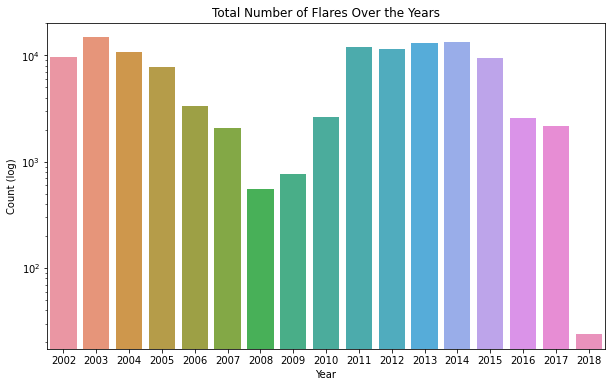

In [109]:
plt.figure(figsize=(10,6))
sns.barplot(data=grouped_data_year_number, x='year',y='number')#y=df.groupby(years)['total.counts'].sum().values)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Count (log)')
plt.title('Total Number of Flares Over the Years')
plt.show()

In [116]:
# Grouping data by year to plot number of flares for each energy band

grouped_data_energy_number=df.groupby(['year','energy.kev']).size().reset_index(name='number')

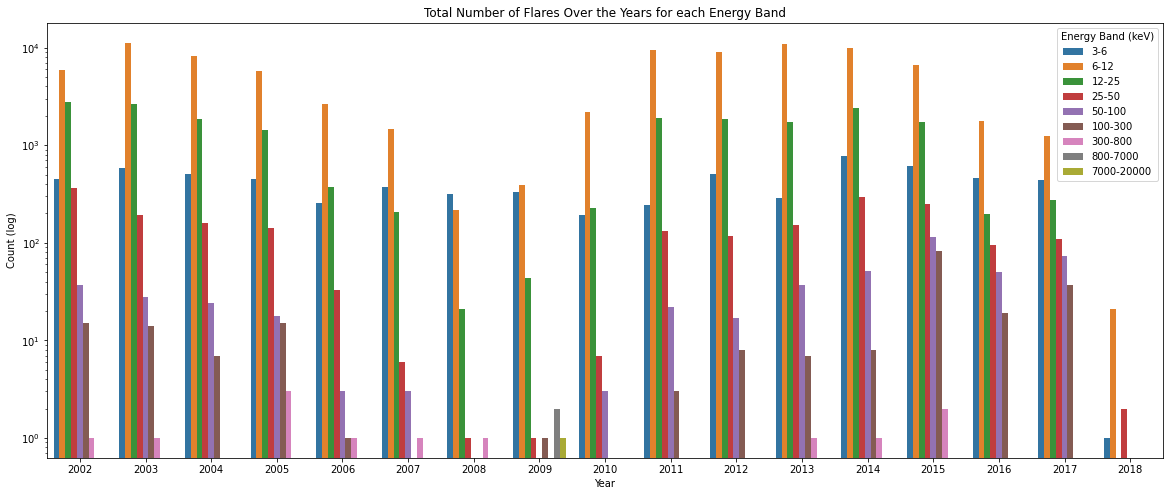

In [117]:
plt.figure(figsize=(20,8))
sns.barplot(data=grouped_data_energy_number, x='year',y='number', hue='energy.kev',dodge=True)#y=df.groupby(years)['total.counts'].sum().values)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Count (log)')
plt.title('Total Number of Flares Over the Years for each Energy Band')
plt.legend(title="Energy Band (keV)")
plt.show()

In [110]:
# Grouping data by year to plot duration

grouped_data_year_duration=y=df.groupby(['year'])['duration.s'].mean().reset_index(name='duration')

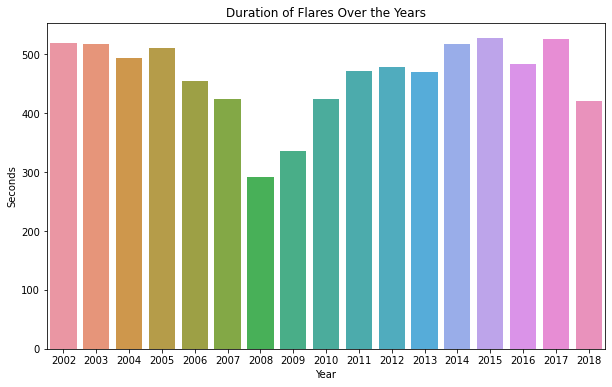

In [121]:
plt.figure(figsize=(10,6))
sns.barplot(data=grouped_data_year_duration, x='year',y='duration')#y=df.groupby(years)['total.counts'].sum().values)
#plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Seconds')
plt.title('Duration of Flares Over the Years')
plt.show()

In [118]:
# Grouping data by year to plot duration for each energy band

grouped_data_energy_duration=df.groupby(['year','energy.kev'])['duration.s'].mean().reset_index(name='duration')

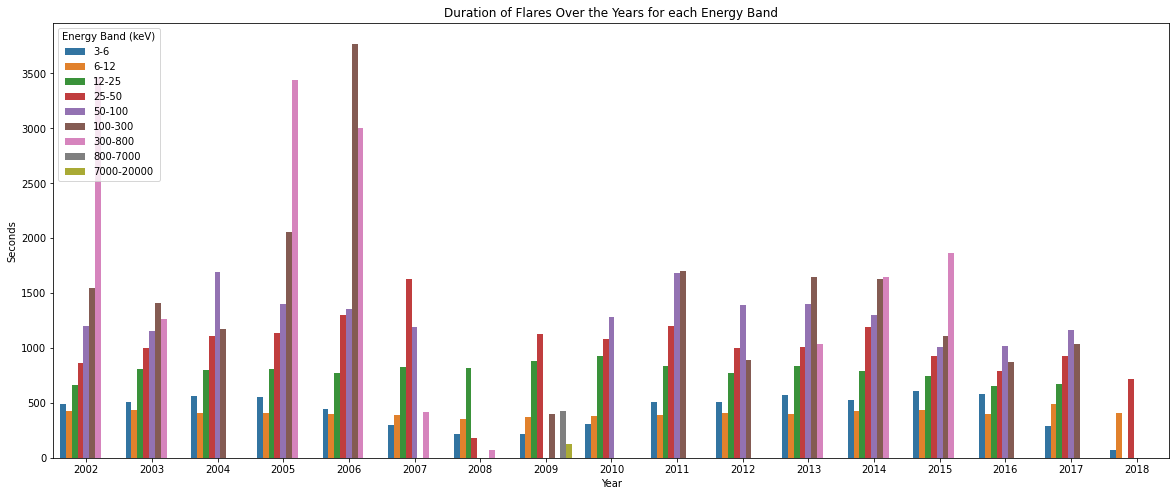

In [122]:
plt.figure(figsize=(20,8))
sns.barplot(data=grouped_data_energy_duration, x='year',y='duration', hue='energy.kev',dodge=True)#y=df.groupby(years)['total.counts'].sum().values)
#plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Seconds')
plt.title('Duration of Flares Over the Years for each Energy Band')
plt.legend(title="Energy Band (keV)")
plt.show()

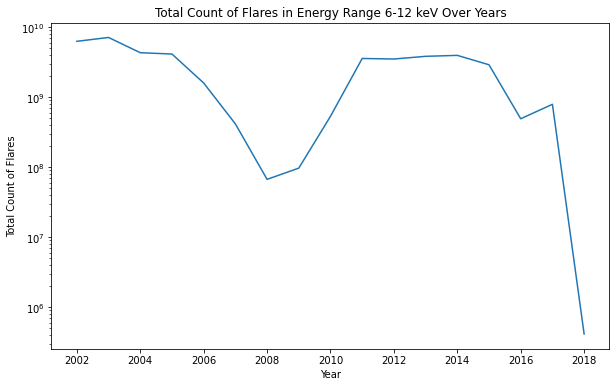

In [644]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df['year'].unique(),y=df.groupby(['year'])['total.counts'].sum())#y=df.groupby(years)['total.counts'].sum().values)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Total Count of Flares')
plt.title('Total Count of Flares in Energy Range 6-12 keV Over Years')
plt.show()

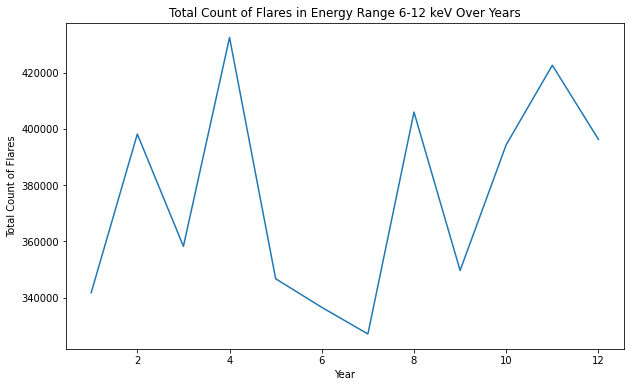

In [645]:
plt.figure(figsize=(10,6))
sns.lineplot(x=df['month'].unique(),y=df.groupby(['month'])['total.counts'].mean())#y=df.groupby(years)['total.counts'].sum().values)
#plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Total Count of Flares')
plt.title('Total Count of Flares in Energy Range 6-12 keV Over Years')
plt.show()

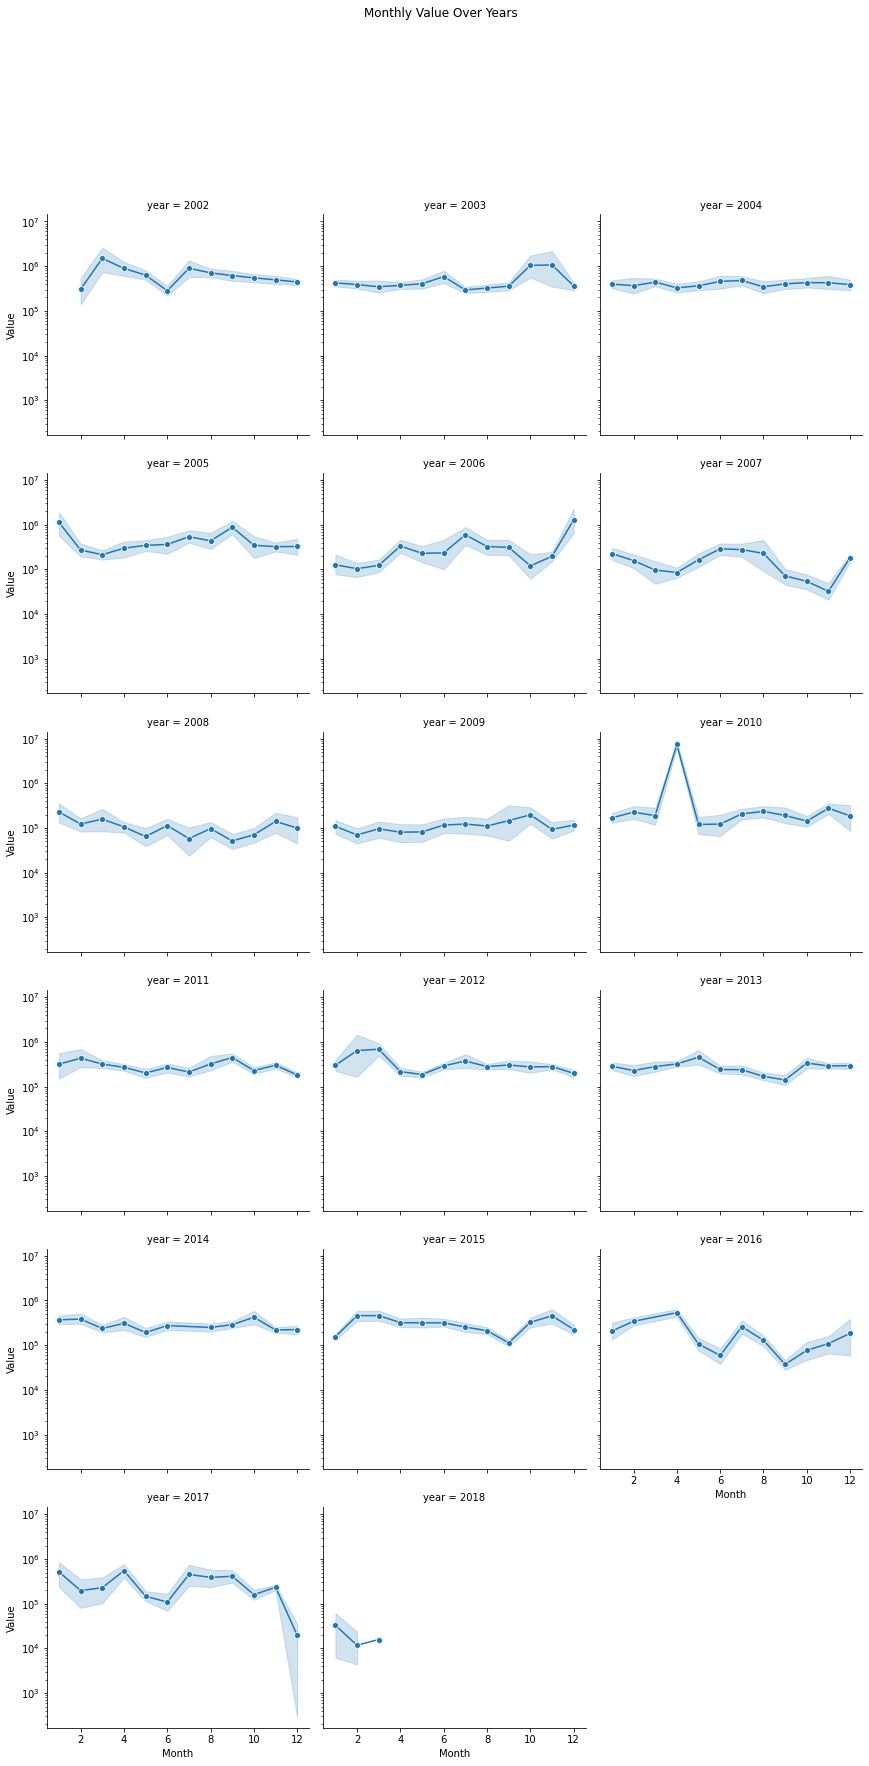

In [646]:
g = sns.FacetGrid(df, col='year', col_wrap=3, height=4)#, aspect=1.5)
g.map(sns.lineplot, 'month','total.counts' , marker='o')
g.set_axis_labels('Month', 'Value')
g.fig.suptitle('Monthly Value Over Years', y=1.02)
plt.yscale('log')
plt.subplots_adjust(top=0.9)
plt.show()

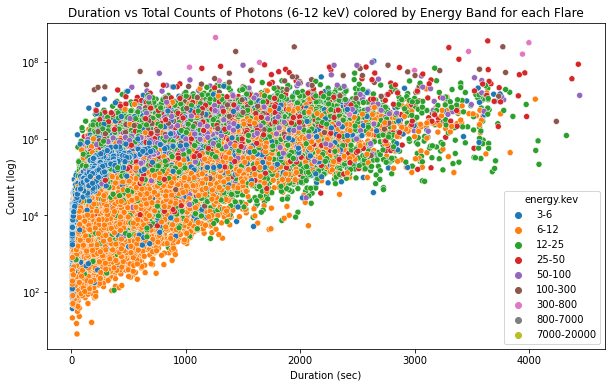

In [647]:
plt.figure(figsize=(10,6))
scatter=sns.scatterplot(x=df['duration.s'],y=df['total.counts'], hue=df['energy.kev'])#hue=df['ordered_energy.kev'].cat.codes)
plt.yscale('log')
plt.xlabel('Duration (sec)')
plt.ylabel('Count (log)')
plt.title('Duration vs Total Counts of Photons (6-12 keV) colored by Energy Band for each Flare')
plt.show()

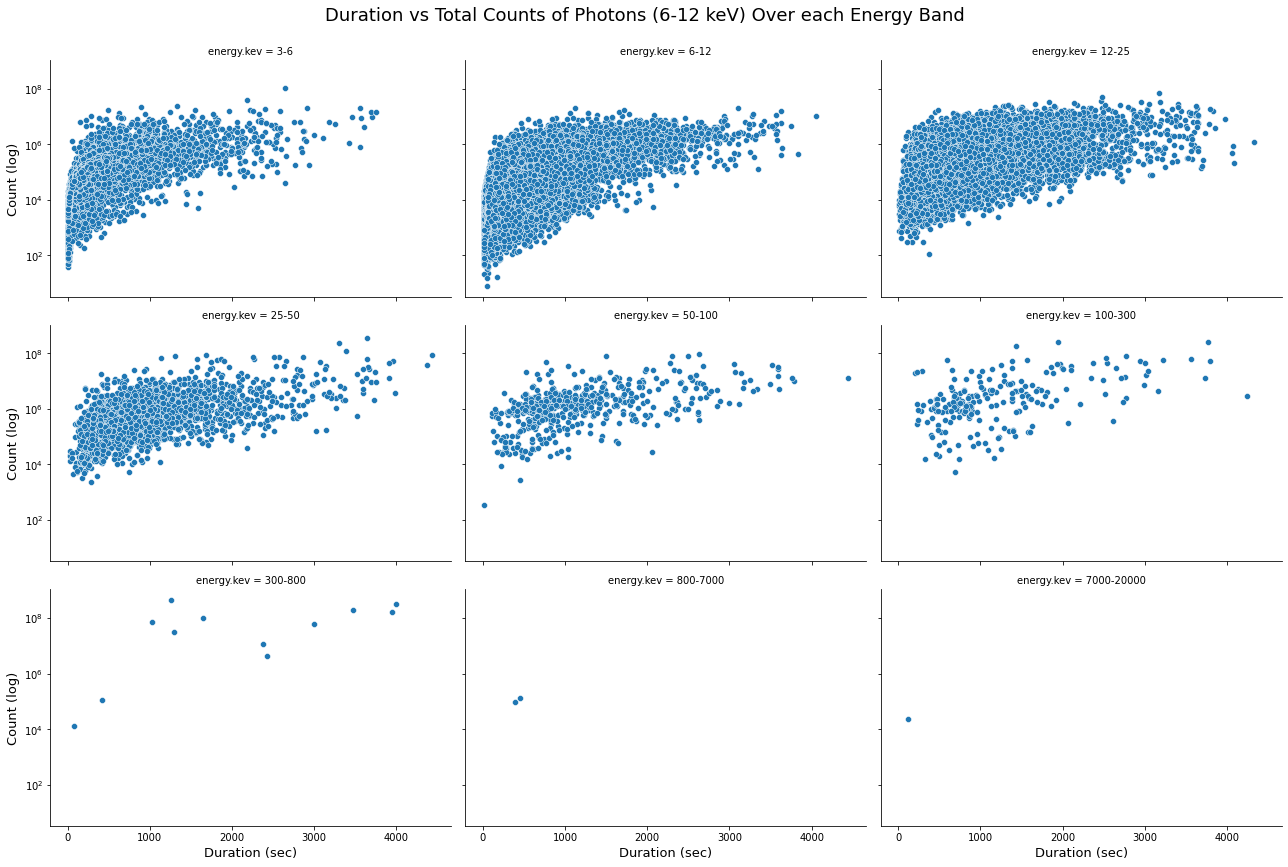

In [735]:
g = sns.FacetGrid(df, col='energy.kev', col_wrap=3, height=4, aspect=1.5)
g.map(sns.scatterplot, 'duration.s','total.counts')
g.set_axis_labels('Duration (sec)', 'Count (log)', fontsize=13)
g.set_titles(fontsize=15)
g.fig.suptitle('Duration vs Total Counts of Photons (6-12 keV) Over each Energy Band', y=1, fontsize=18)
plt.yscale('log')
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()

# Data Preparation and Preprocessing

In [6]:
def calculate_mode(x):
    return x.mode().iloc[0] if not x.mode().empty else None

In [256]:
grouped_data_month=df.groupby(['year','month']).size().reset_index(name='Number')
grouped_data_month['Duration'] = df.groupby(['year','month'])['duration.s'].mean().reset_index(name='Duration')['Duration'].values
grouped_data_month['Energy'] = df.groupby(['year','month'])['energy.kev'].apply(calculate_mode).reset_index(name='Energy')['Energy'].values
grouped_data_month['Radial'] = df.groupby(['year','month'])['factor_radial'].apply(calculate_mode).reset_index(name='Radial')['Radial'].values
grouped_data_month['Total_counts'] = df.groupby(['year','month'])['total.counts'].mean().reset_index(name='Total_counts')['Total_counts'].values
grouped_data_month['Peaks'] = df.groupby(['year','month'])['peak.c/s'].mean().reset_index(name='Peaks')['Peaks'].values
grouped_data_month.set_index(pd.to_datetime(grouped_data_month[['year', 'month']].assign(Day=1)), inplace=True)

start_date = pd.to_datetime('2002-02')
end_date = pd.to_datetime('2018-03')
dates = pd.date_range(start=start_date, end=end_date, freq='MS')
ts = grouped_data_month.reindex(dates,method='ffill')

In [195]:
ts

year  month  Number    Duration Energy Radial  Total_counts  \
2002-02-01  2002      2     231  484.987013   6-12     r1  3.060434e+05   
2002-03-01  2002      3     571  569.912434   6-12     r1  1.492297e+06   
2002-04-01  2002      4     493  578.547667   6-12     r1  8.919634e+05   
2002-05-01  2002      5    1165  526.908155   6-12     r1  6.305009e+05   
2002-06-01  2002      6     388  478.618557   6-12     r1  2.811340e+05   
...          ...    ...     ...         ...    ...    ...           ...   
2017-11-01  2017     11     166  292.650602    3-6     r1  2.329086e+05   
2017-12-01  2017     12       3  272.000000   6-12     r1  1.957500e+04   
2018-01-01  2018      1       6  581.333333   6-12     r1  3.284233e+04   
2018-02-01  2018      2      17  360.941176   6-12     r1  1.178812e+04   
2018-03-01  2018      3       1  492.000000   6-12     r1  1.581600e+04   

                 Peaks  
2002-02-01  157.480519  
2002-03-01  530.789842  
2002-04-01  361.298174  
2002-05-01  329.327897  
2002-06-01  170.613402  
...                ...  
2017-11-01  285.343373  
2017-12-01   49.333333  
2018-01-01   83.333333  
2018-02-01   33.411765  
2018-03-01   42.000000  

[194 rows x 8 columns]

In [257]:
train_years = list(range(2002, 2015))
test_years = list(range(2015, 2018))

In [258]:
train = ts[ts['year'].isin(train_years)]
test = ts[ts['year'].isin(test_years)]

In [259]:
label_encoder = LabelEncoder()
label_encoder.fit(train['Energy'])
train['Energy_encoded'] = label_encoder.transform(train['Energy'])
test['Energy_encoded'] = label_encoder.transform(test['Energy'])

In [260]:
train=train[['Number','Energy_encoded','Duration']]
test=test[['Number','Energy_encoded','Duration']]

In [660]:
# Stationarity check

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

adf_test(train['Number'].values)

1. ADF :  -1.07702557746
2. P-Value :  0.724146
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 149
5. Critical Values :
	 1% :  -3.4750180242954167
	 5% :  -2.8811408028842043
	 10% :  -2.577221358046935
Failed to Reject Ho - Time Series is Non-Stationary


In [661]:
adf_test(train['Duration'].values)

1. ADF :  -1.3942191255078724
2. P-Value :  0.585044
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 148
5. Critical Values :
	 1% :  -3.4753253063120644
	 5% :  -2.881274703275226
	 10% :  -2.5772928360116873
Failed to Reject Ho - Time Series is Non-Stationary


In [662]:
adf_test(train['Energy_encoded'].values)

1. ADF :  -2.0711845465502434
2. P-Value :  0.256258
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 142
5. Critical Values :
	 1% :  -3.477261624048995
	 5% :  -2.8821181874544233
	 10% :  -2.5777431104939494
Failed to Reject Ho - Time Series is Non-Stationary


In [21]:
diff_train=train.copy()
diff_train = diff_train-diff_train.shift(12)
diff_train.dropna(inplace = True)

In [664]:
adf_test(diff_train['Number'].values)

1. ADF :  -1.8488701658652507
2. P-Value :  0.356483
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598
Failed to Reject Ho - Time Series is Non-Stationary


In [665]:
adf_test(diff_train['Duration'].values)

1. ADF :  -1.8021231730898515
2. P-Value :  0.379408
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 129
5. Critical Values :
	 1% :  -3.482087964046026
	 5% :  -2.8842185101614626
	 10% :  -2.578864381347275
Failed to Reject Ho - Time Series is Non-Stationary


In [666]:
adf_test(diff_train['Energy_encoded'].values)

1. ADF :  -2.1582189154973834
2. P-Value :  0.221757
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 128
5. Critical Values :
	 1% :  -3.4825006939887997
	 5% :  -2.884397984161377
	 10% :  -2.578960197753906
Failed to Reject Ho - Time Series is Non-Stationary


In [22]:
diff_train=diff_train.diff()
diff_train.dropna(inplace = True)

In [668]:
adf_test(diff_train['Number'].values)

1. ADF :  -4.464331637906366
2. P-Value :  0.000228
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598
Reject Ho - Time Series is Stationary


In [669]:
adf_test(diff_train['Duration'].values)

1. ADF :  -4.452344054978687
2. P-Value :  0.00024
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 129
5. Critical Values :
	 1% :  -3.482087964046026
	 5% :  -2.8842185101614626
	 10% :  -2.578864381347275
Reject Ho - Time Series is Stationary


In [670]:
adf_test(diff_train['Energy_encoded'].values)

1. ADF :  -4.018110537198304
2. P-Value :  0.001319
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 128
5. Critical Values :
	 1% :  -3.4825006939887997
	 5% :  -2.884397984161377
	 10% :  -2.578960197753906
Reject Ho - Time Series is Stationary


# Model Training

In [7]:
# Defining functions

In [1]:
def get_mse_arima_sarima(model, train, test, multi=False):
    
    if multi:
        pred_train = model.predict()
    else:
        pred_train = model.predict(start=1, end=len(train))
        
    mse_train=np.sqrt(mean_squared_error(train['Number'].values,pred_train))
    print("MSE on train dataset: ", mse_train)
    print("R2 on train dataset: ", r2_score(train['Number'].values,pred_train))

    if multi:
        pred_test = model.forecast(steps=len(test), exog=test[['Duration','Energy_encoded']])
    else:
        pred_test = model.forecast(steps=len(test))
    
    mse_test=np.sqrt(mean_squared_error(test['Number'].values,pred_test))
    print("MSE on test dataset: ", mse_test)
    print("R2 on test dataset: ", r2_score(test['Number'].values,pred_test))
    
    return pred_train, pred_test, mse_train, mse_test

In [3]:
def get_mse_lstm_tcn(model, X_train, X_test, y_train, y_test, scaler):
    
    y_pred_train = model.predict(X_train)
    y_pred_train_inv = scaler.inverse_transform(y_pred_train)
    y_train_inv = scaler.inverse_transform(y_train)
    mse_train = np.sqrt(mean_squared_error(y_train_inv, y_pred_train_inv))
    print("MSE on train dataset: ", mse_train)
    print("R2 on train dataset: ", r2_score(y_train_inv,y_pred_train_inv))

    y_pred_test = model.predict(X_test)
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)
    y_test_inv = scaler.inverse_transform(y_test)
    mse_test = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
    print("MSE on test dataset: ", mse_test)
    print("R2 on test dataset: ", r2_score(y_test_inv,y_pred_test_inv))
    
    return y_train_inv, y_test_inv, y_pred_train_inv, y_pred_test_inv, mse_train, mse_test

In [2]:
def plot_results(x, y_true, y_pred):
    plt.plot(x, y_true, label='Actual Data')
    plt.plot(x, y_pred, color='red', label='Forecasted Values')
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
    plt.legend()
    plt.show()

In [4]:
def prepare_data_lstm_tcn(features_train, features_test, sequence_length, train_index, test_index, target_train=None, target_test=None):
    
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    
    if isinstance(target_train, pd.core.series.Series) and isinstance(target_test, pd.core.series.Series):
        scaler.fit(features_train)
        features_train = scaler.transform(features_train)
        features_test = scaler.transform(features_test)

        scaler.fit(np.array(target_train).reshape(-1, 1))
        target_train = scaler.transform(np.array(target_train).reshape(-1, 1))
        target_test = scaler.transform(np.array(target_test).reshape(-1, 1))
        Y_train = target_train
        Y_test = target_test
        
    else:
        scaler.fit(np.array(features_train).reshape(-1, 1))
        features_train = scaler.transform(np.array(features_train).reshape(-1, 1))
        features_test = scaler.transform(np.array(features_test).reshape(-1, 1))
        Y_train = features_train
        Y_test = features_test

    X_train, y_train, index_train = [], [], []
    for i in range(len(features_train) - sequence_length):
        X_train.append(features_train[i : i + sequence_length])
        y_train.append(Y_train[i + sequence_length])
        index_train.append(train_index[i + sequence_length])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test, y_test, index_test = [], [], []
    for i in range(len(features_test) - sequence_length):
        X_test.append(features_test[i : i + sequence_length])
        y_test.append(Y_test[i + sequence_length])
        index_test.append(test_index[i + sequence_length])
    X_test, y_test = np.array(X_test), np.array(y_test)

    if not isinstance(target_train, pd.core.series.Series) and isinstance(target_test, pd.core.series.Series):
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
    return X_train, X_test, y_train, y_test, index_train, index_test, scaler

In [5]:
def lstm(X_train, X_test, y_train, y_test, epochs=50):
    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(LSTM(units=32, activation='relu', return_sequences=True))
    model_lstm.add(LSTM(units=16, activation='relu', return_sequences=False))
    model_lstm.add(Dense(units=1))
    model_lstm.compile(optimizer=Adam(), loss=MeanSquaredError())

    #early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=True)
    # Train the LSTM model
    model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    # Evaluate the model on the train set
    train_loss = model_lstm.evaluate(X_train, y_train)
    print(f'Train Loss: {train_loss}')

    # Evaluate the model on the test set
    test_loss = model_lstm.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    
    return model_lstm

In [6]:
def tcn(X_train, X_test, y_train, y_test, epochs=50):
    # Build the TCN model
    model_tcn = Sequential()
    model_tcn.add(Conv1D(filters=64, kernel_size=3, dilation_rate=1, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_tcn.add(Conv1D(filters=32, kernel_size=3, dilation_rate=2, strides=1, padding='same', activation='relu'))
    model_tcn.add(Conv1D(filters=16, kernel_size=3, dilation_rate=4, strides=1, padding='same', activation='relu'))
    #model_tcn.add(Conv1D(filters=16, kernel_size=3, dilation_rate=8, strides=1, padding='same', activation='relu'))
    model_tcn.add(Flatten())
    model_tcn.add(Dense(units=1))  # Output layer with 1 neuron for regression

    # Compile the model
    model_tcn.compile(optimizer=Adam(), loss=MeanSquaredError())

    # Train the TCN model
    model_tcn.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    # Evaluate the model on the train set
    train_loss_tcn = model_tcn.evaluate(X_train, y_train)
    print(f'Train Loss: {train_loss_tcn}')

    # Evaluate the model on the test set
    test_loss_tcn = model_tcn.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss_tcn}')
    
    return model_tcn

# Target - Number of Solar Flares

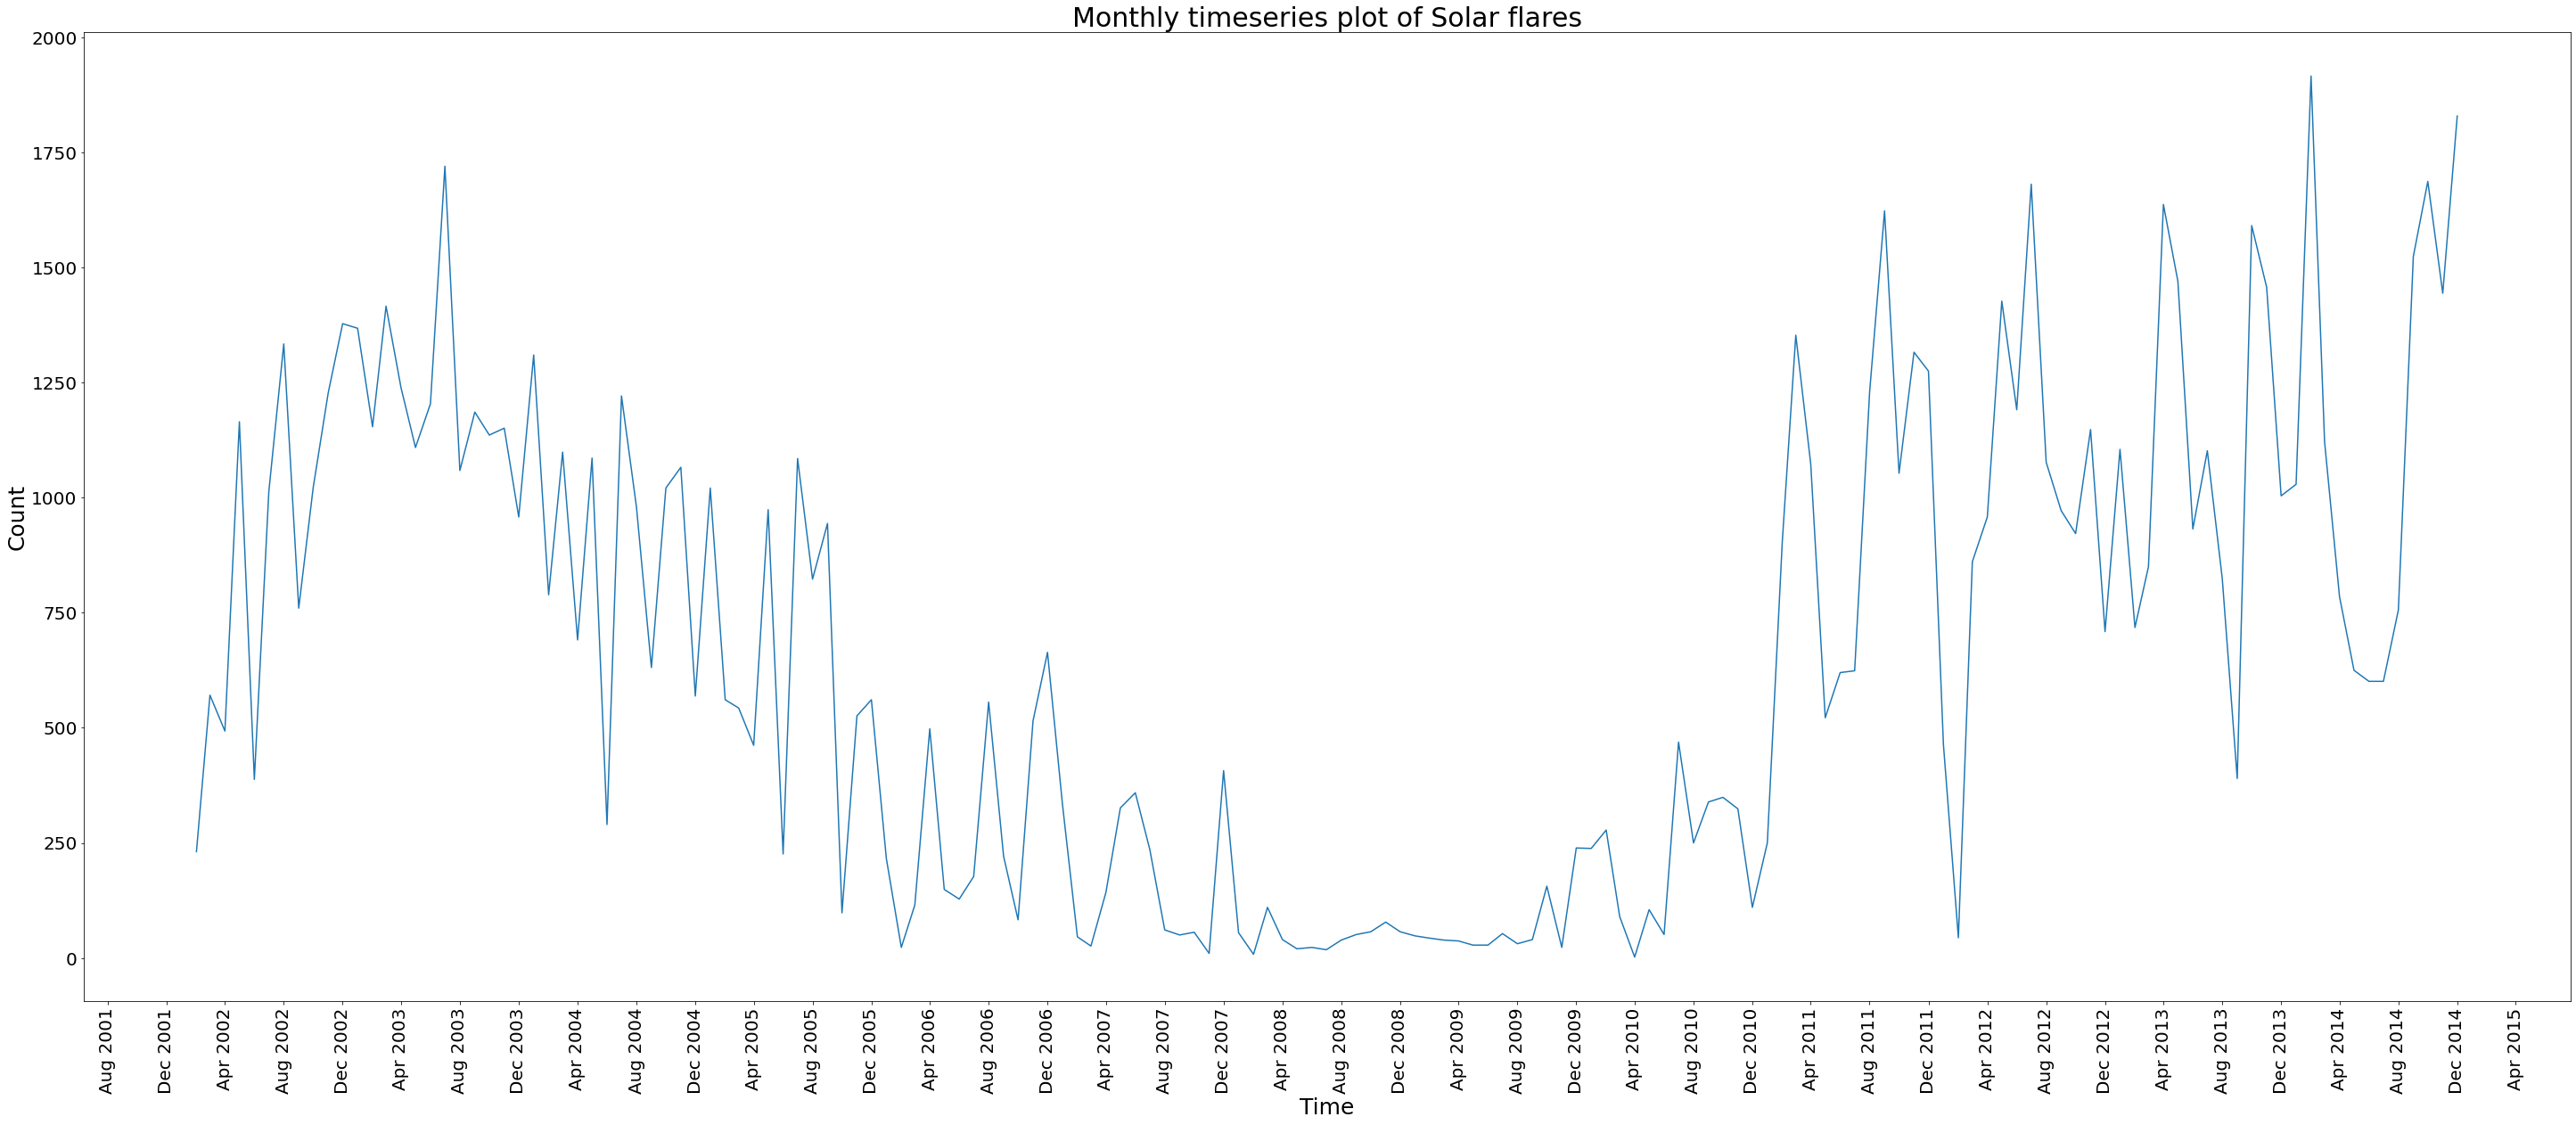

In [658]:
plt.figure(figsize=(50, 20))
sns.lineplot(y=train['Number'], x=train.index, data=train)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.title('Monthly timeseries plot of Solar flares', fontsize=30)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

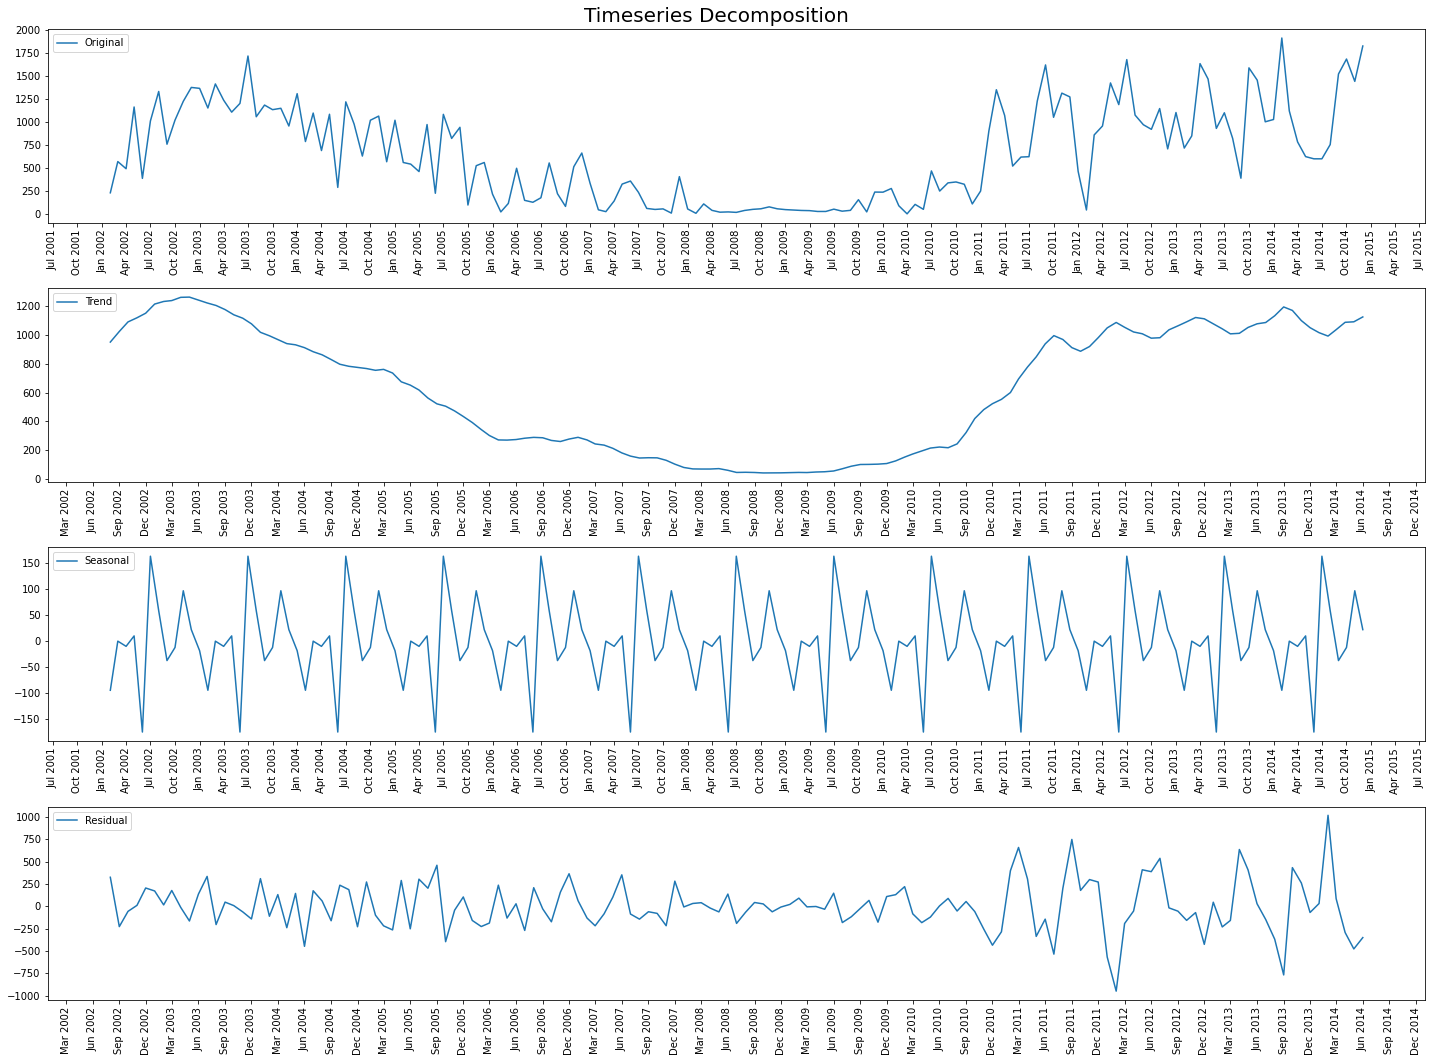

In [659]:
result = seasonal_decompose(train['Number'], model='additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plotting the components
plt.figure(figsize=(20, 15))
plt.suptitle('Timeseries Decomposition', fontsize=20)

plt.subplot(411)
plt.plot(train['Number'], label='Original')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

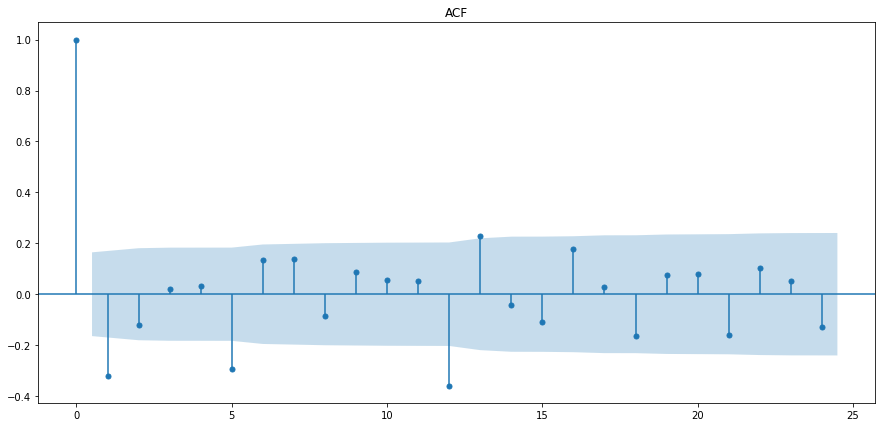

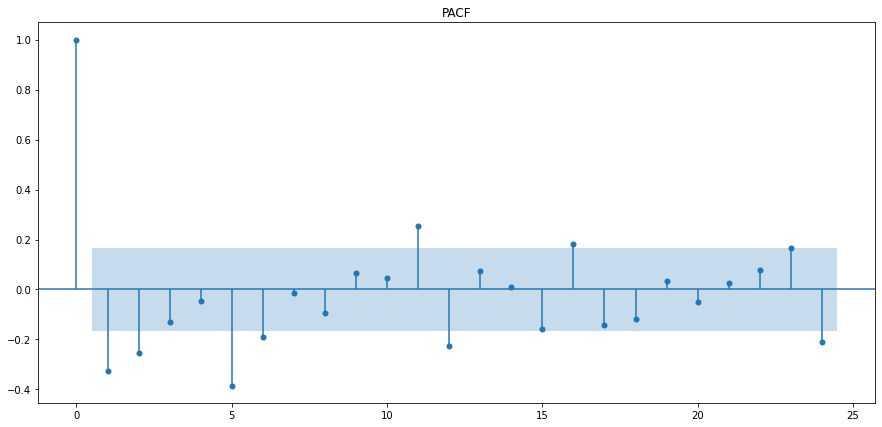

In [23]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(diff_train['Number'].values, title='ACF', ax=ax, lags=24)
plt.show()
fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(diff_train['Number'].values,  title='PACF', ax=ax, lags=24)
plt.show()

In [672]:
order = (2,1,1)
seasonal_order = (2,1,1,12)

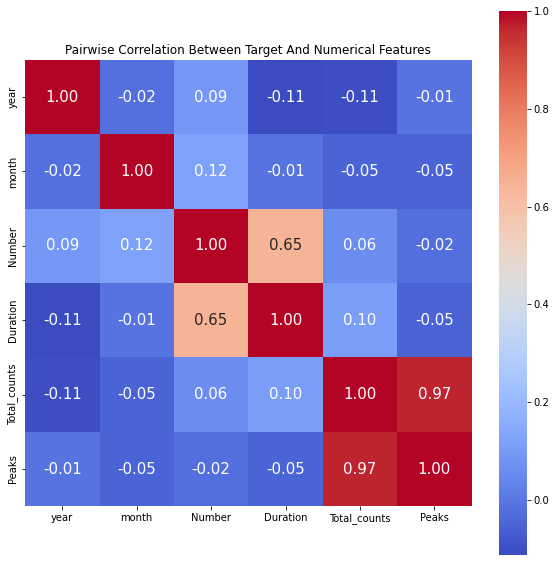

In [209]:
# Checking correlation

numeric_cols_only = train.select_dtypes(include=['int64', 'float64'])
corr = numeric_cols_only.corr(numeric_only=True)
plt.figure(figsize=(10,10))
plt.title("Pairwise Correlation Between Target And Numerical Features")
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size':15},
           xticklabels= numeric_cols_only.columns, yticklabels= numeric_cols_only.columns,
           cmap= 'coolwarm')
plt.show()

In [210]:
# ANOVA testing

print('ANOVA test between target and categorical feature:\n')
model = ols('Number ~ Energy', data=train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

ANOVA test between target and categorical feature:

                sum_sq     df          F        PR(>F)
Energy    1.108451e+07    1.0  55.411183  6.615458e-12
Residual  3.060629e+07  153.0        NaN           NaN


Both correlation plot and ANOVA test shows that Duration and Energy are significantly related to Number. However, they are essentially post-event measurements. i.e. they are not independent variables. Which is why they cannot be selected as features in the model.

## Univariate Analysis

### ARIMA

MSE on train dataset:  323.7449370993764
R2 on train dataset:  0.13316789986638966
MSE on test dataset:  440.9139054860302
R2 on test dataset:  -0.634737115188079


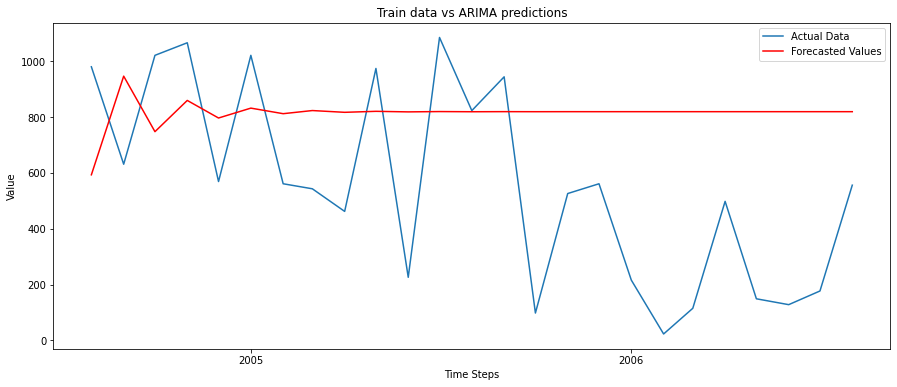

MSE on train dataset:  289.8310617731103
R2 on train dataset:  0.5177568898626306
MSE on test dataset:  238.97147109834415
R2 on test dataset:  -0.8395952252362089


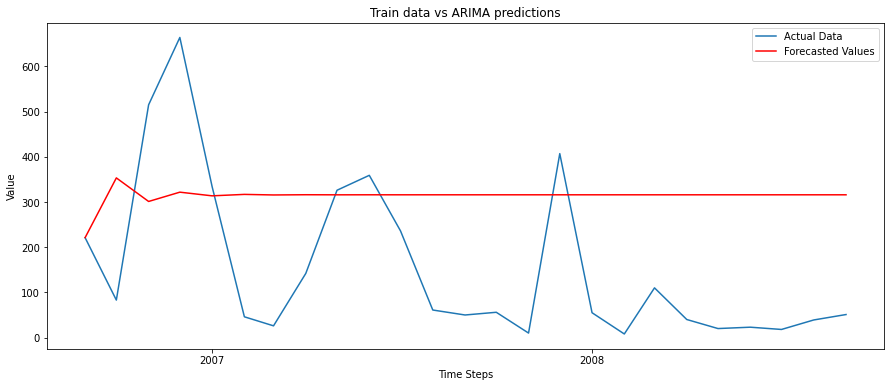

MSE on train dataset:  237.87840691841308
R2 on train dataset:  0.7453652893012059
MSE on test dataset:  151.780838707301
R2 on test dataset:  -0.4691685365814222


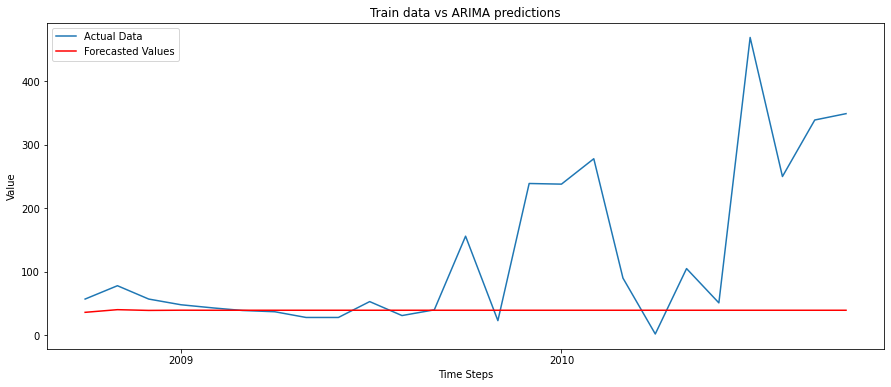

MSE on train dataset:  209.58144575124876
R2 on train dataset:  0.7959899074840412
MSE on test dataset:  753.888481334439
R2 on test dataset:  -1.919526275414737


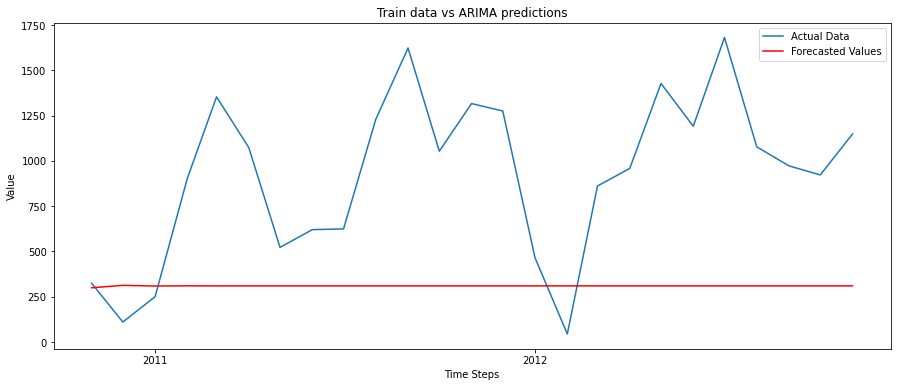

MSE on train dataset:  175.06717155540352
R2 on train dataset:  0.87218551414068
MSE on test dataset:  427.5140024108709
R2 on test dataset:  -0.0025003494735955645


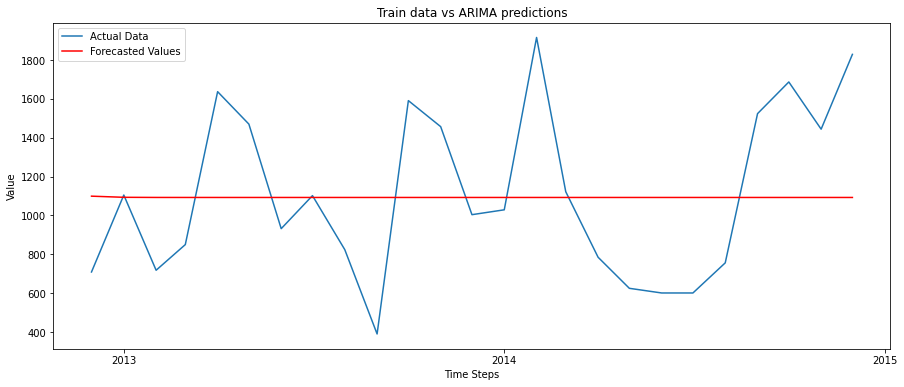

In [213]:
random_seed = 42
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    model = ARIMA(train_data['Number'],order=order)
    arima_results = model.fit()

    pred_train_arima, pred_test_arima, train_mse_arima, test_mse_arima = get_mse_arima_sarima(
        arima_results, train_data, test_data)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs ARIMA predictions")
    plot_results(test_data.index, test_data['Number'], pred_test_arima)
 
    all_train_mse.append(test_mse_arima)
average_train_mse_arima = np.mean(all_train_mse)

In [214]:
average_train_mse_arima

402.6137398073971

In [215]:
model = ARIMA(train['Number'],order=order)
arima_results = model.fit()

In [216]:
print("ARIMA results:\n")
pred_train_arima, pred_test_arima, train_mse_arima, test_mse_arima = get_mse_arima_sarima(arima_results, train, test)

ARIMA results:

MSE on train dataset:  182.28117492446364
R2 on train dataset:  0.876469258127514
MSE on test dataset:  1047.6033982891843
R2 on test dataset:  -6.6735462781489785


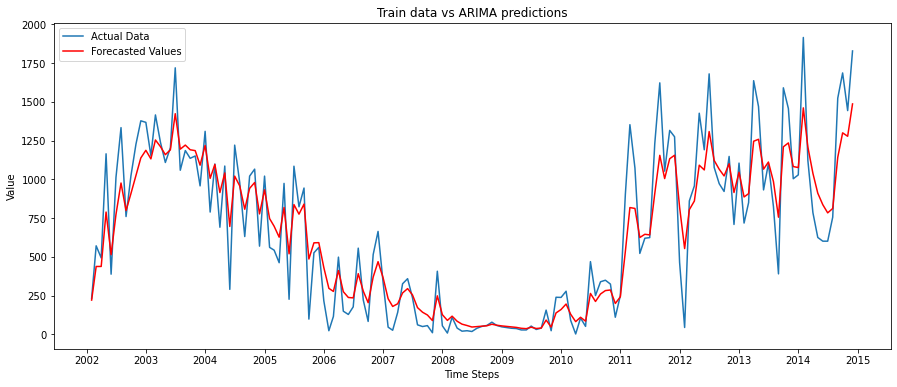

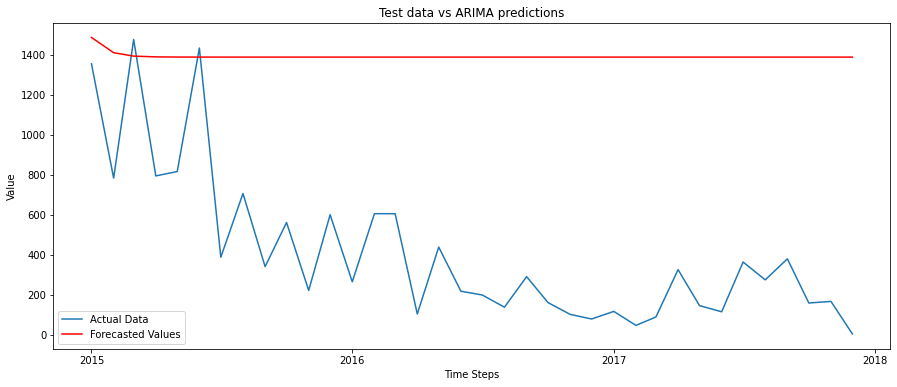

In [217]:
plt.figure(figsize=(15,6))
plt.title("Train data vs ARIMA predictions")
plot_results(train.index, train['Number'],pred_train_arima)

plt.figure(figsize=(15,6))
plt.title("Test data vs ARIMA predictions")
plot_results(test.index, test['Number'],pred_test_arima)

### SARIMA

MSE on train dataset:  282.19858470239546
R2 on train dataset:  0.3413742935959687
MSE on test dataset:  620.8841594071054
R2 on test dataset:  -2.2416154317991923


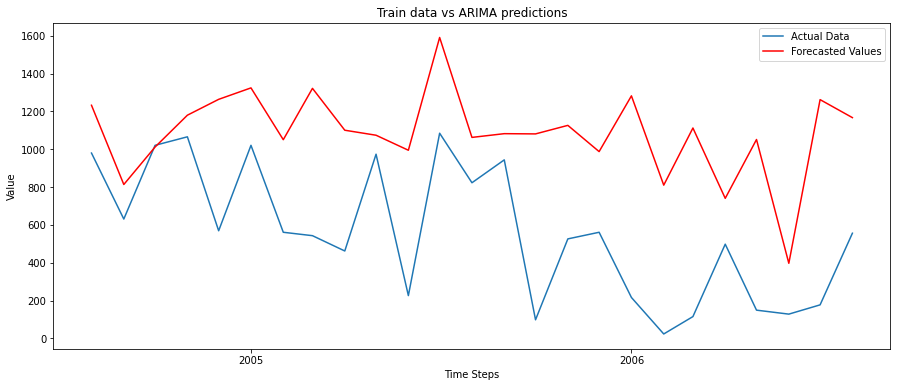

MSE on train dataset:  328.87066784117724
R2 on train dataset:  0.37909314250767323
MSE on test dataset:  255.27040223383892
R2 on test dataset:  -1.099090121991181


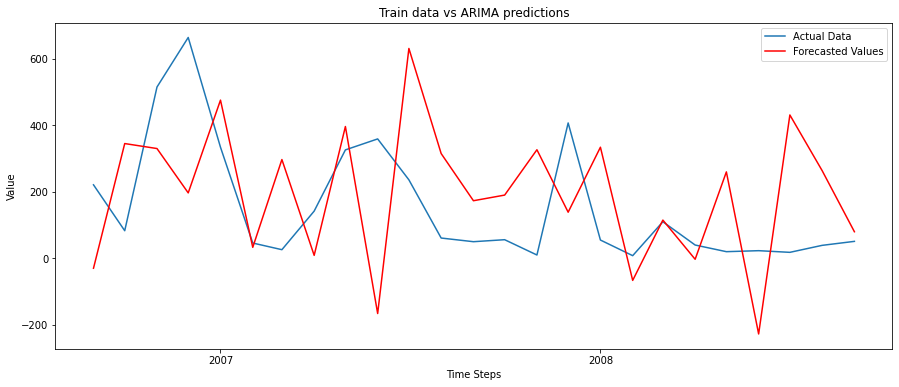

MSE on train dataset:  299.1555112359365
R2 on train dataset:  0.5972815024034511
MSE on test dataset:  295.7537573179074
R2 on test dataset:  -4.578253720808722


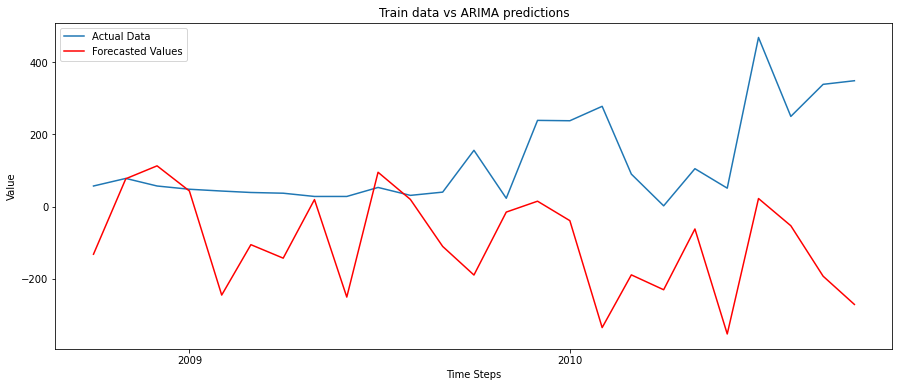

MSE on train dataset:  269.2365206216935
R2 on train dataset:  0.6633226284876693
MSE on test dataset:  718.3680178117335
R2 on test dataset:  -1.6508927093796912


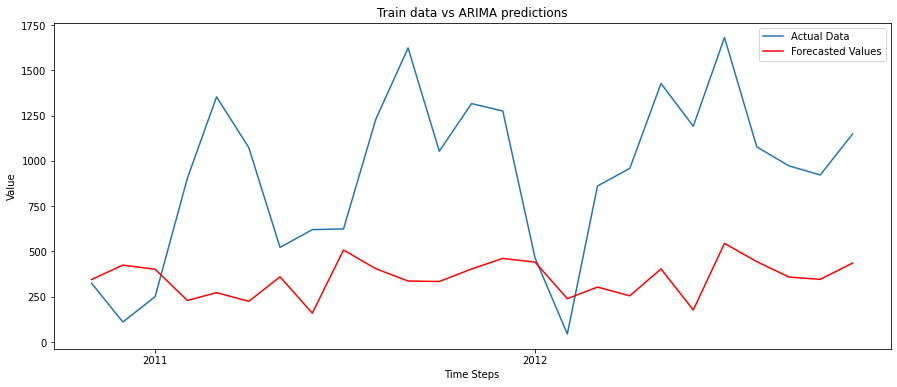

MSE on train dataset:  253.21136170378986
R2 on train dataset:  0.7326150096274219
MSE on test dataset:  491.14749793782175
R2 on test dataset:  -0.32314584399662083


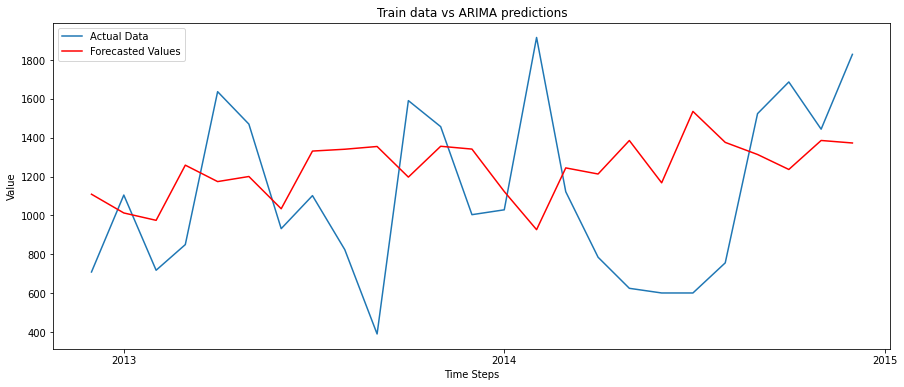

In [219]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    model = SARIMAX(train_data['Number'],order=order, seasonal_order=seasonal_order)
    sarima_results = model.fit()
    
    pred_train_sarima, pred_test_sarima, train_mse_sarima, test_mse_sarima = get_mse_arima_sarima(sarima_results, train_data, test_data)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs ARIMA predictions")
    plot_results(test_data.index, test_data['Number'], pred_test_sarima)
 
    all_train_mse.append(test_mse_sarima)
average_train_mse_sarima = np.mean(all_train_mse)

In [220]:
average_train_mse_sarima

476.28476694168137

In [221]:
model = SARIMAX(train['Number'], order=order, seasonal_order=seasonal_order)
sarima_results = model.fit()

In [222]:
print("SARIMA results:\n")
pred_train_sarima, pred_test_sarima, train_mse_sarima, test_mse_sarima = get_mse_arima_sarima(sarima_results, train, test)

SARIMA results:

MSE on train dataset:  258.09253206325457
R2 on train dataset:  0.752347744396838
MSE on test dataset:  1286.3483725484807
R2 on test dataset:  -10.569631385384156


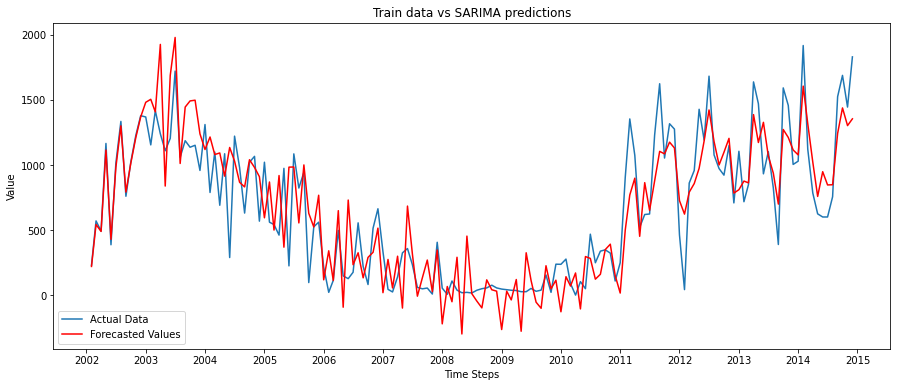

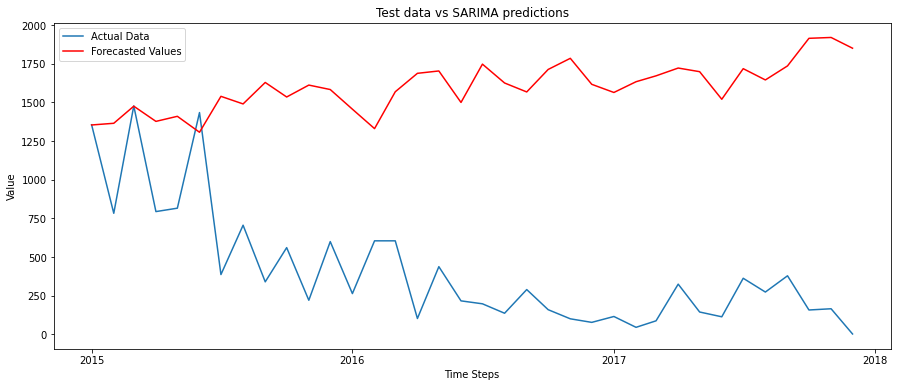

In [223]:
plt.figure(figsize=(15,6))
plt.title("Train data vs SARIMA predictions")
plot_results(train.index, train['Number'],pred_train_sarima)

plt.figure(figsize=(15,6))
plt.title("Test data vs SARIMA predictions")
plot_results(test.index, test['Number'],pred_test_sarima)

### LSTM

1/1 [==============================] - 0s 346ms/step - loss: 0.3132
Train Loss: 0.313189834356308
1/1 [==============================] - 0s 35ms/step - loss: 2.7103
Test Loss: 2.710294246673584
1/1 [==============================] - 0s 328ms/step
MSE on train dataset:  194.59843235864264
R2 on train dataset:  0.49421145954176215
1/1 [==============================] - 0s 24ms/step
MSE on test dataset:  572.4581372758043
R2 on test dataset:  -1.9677915304194857


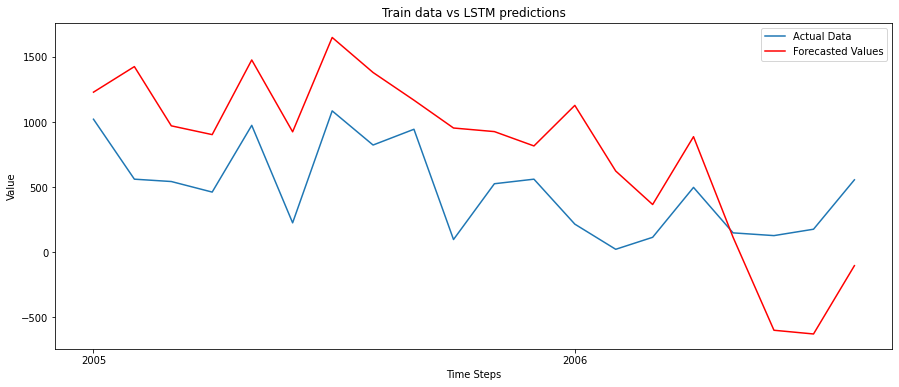

2/2 [==============================] - 0s 15ms/step - loss: 0.2982
Train Loss: 0.29821059107780457
1/1 [==============================] - 0s 41ms/step - loss: 0.3449
Test Loss: 0.3449419140815735
2/2 [==============================] - 0s 8ms/step
MSE on train dataset:  227.91528568886903
R2 on train dataset:  0.7030448023456283
1/1 [==============================] - 0s 23ms/step
MSE on test dataset:  245.1234585275261
R2 on test dataset:  -3.0855798763182234


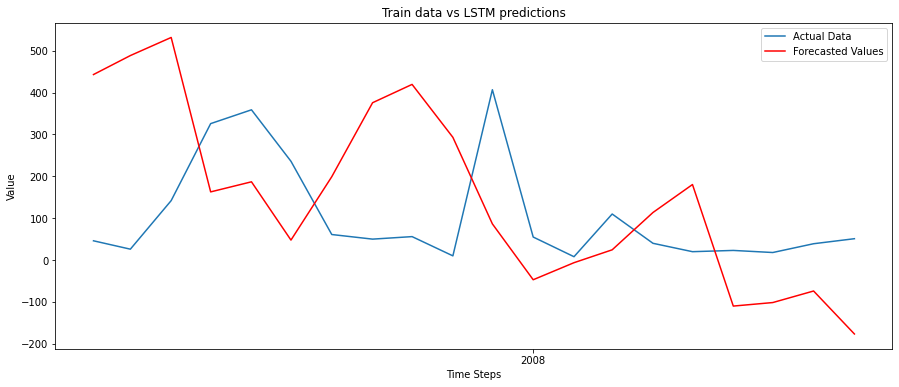

3/3 [==============================] - 0s 6ms/step - loss: 0.1850
Train Loss: 0.18503789603710175
1/1 [==============================] - 0s 34ms/step - loss: 0.0784
Test Loss: 0.07838956266641617
3/3 [==============================] - 0s 6ms/step
MSE on train dataset:  202.7806693684796
R2 on train dataset:  0.8213438902018608
1/1 [==============================] - 0s 32ms/step
MSE on test dataset:  131.98523027174429
R2 on test dataset:  0.03744050117533737


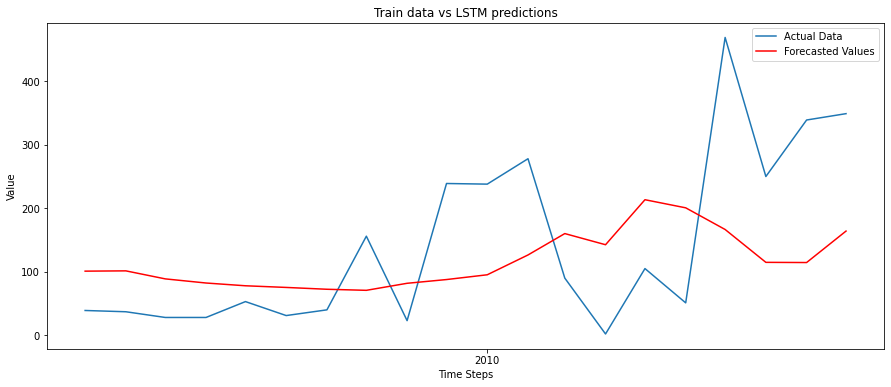

4/4 [==============================] - 0s 6ms/step - loss: 0.1758
Train Loss: 0.17577601969242096
1/1 [==============================] - 0s 34ms/step - loss: 1.9589
Test Loss: 1.9589471817016602
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  194.53906817824512
R2 on train dataset:  0.8285060287501539
1/1 [==============================] - 0s 38ms/step
MSE on test dataset:  649.4389789065744
R2 on test dataset:  -1.7408033310603117


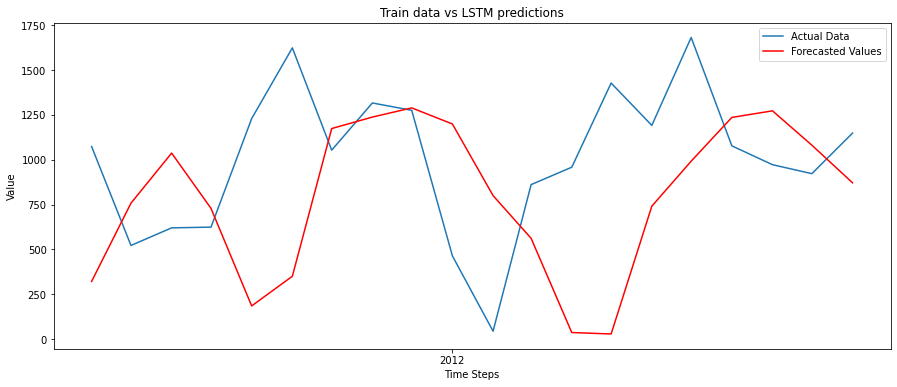

4/4 [==============================] - 0s 7ms/step - loss: 0.2669
Train Loss: 0.26692748069763184
1/1 [==============================] - 0s 15ms/step - loss: 0.8794
Test Loss: 0.8793560266494751
4/4 [==============================] - 0s 7ms/step
MSE on train dataset:  252.99465062137673
R2 on train dataset:  0.7390856454306909
1/1 [==============================] - 0s 30ms/step
MSE on test dataset:  459.19486488391345
R2 on test dataset:  -0.08519932759796145


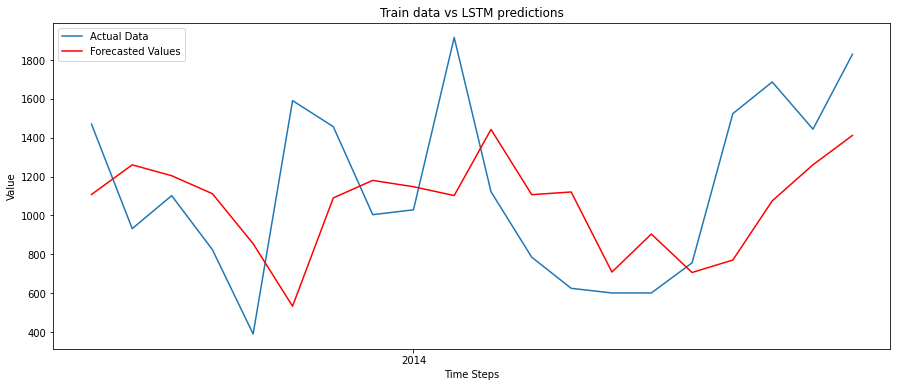

In [224]:
np.random.seed(random_seed)
ts_lstm_train=train.copy()
ts_lstm_test=test.copy()

tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Number']):
    train_data, test_data = ts_lstm_train['Number'][train_index], ts_lstm_train['Number'][test_index]
    
    train_index = train_data.index
    test_index = test_data.index
    
    X_train_lstm=np.array(train_data).reshape(-1,1)
    X_test_lstm=np.array(test_data).reshape(-1,1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index)

    model_lstm = lstm(X_train, X_test, y_train, y_test, 200)
    true_train_lstm, true_test_lstm, pred_train_lstm, pred_test_lstm, train_mse_lstm, test_mse_lstm = get_mse_lstm_tcn(
        model_lstm, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs LSTM predictions")
    plot_results(index_test, true_test_lstm, pred_test_lstm)
 
    all_train_mse.append(test_mse_lstm)
    
average_train_mse_lstm = np.mean(all_train_mse)


In [225]:
average_train_mse_lstm

411.64013397311254

In [226]:
X_train_lstm=np.array(ts_lstm_train['Number']).reshape(-1,1)
X_test_lstm=np.array(ts_lstm_test['Number']).reshape(-1,1)

train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index)

model_lstm = lstm(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 7ms/step - loss: 0.2848
Train Loss: 0.2848367989063263
1/1 [==============================] - 0s 32ms/step - loss: 0.3472
Test Loss: 0.3471563756465912


In [227]:
print("LSTM results:\n")
true_train_lstm, true_test_lstm, pred_train_lstm, pred_test_lstm, train_mse_lstm, test_mse_lstm = get_mse_lstm_tcn(
    model_lstm, X_train, X_test, y_train, y_test, scaler)

LSTM results:

5/5 [==============================] - 0s 6ms/step
MSE on train dataset:  276.79123741296667
R2 on train dataset:  0.7206575858014672
1/1 [==============================] - 0s 24ms/step
MSE on test dataset:  305.57431736240545
R2 on test dataset:  -0.22737614631944902


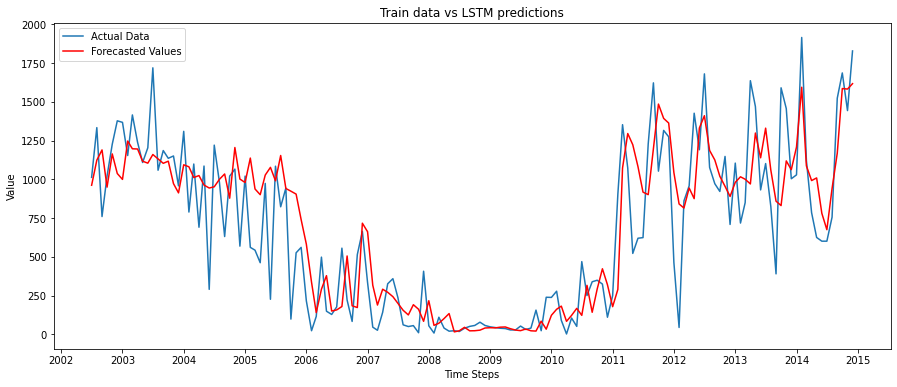

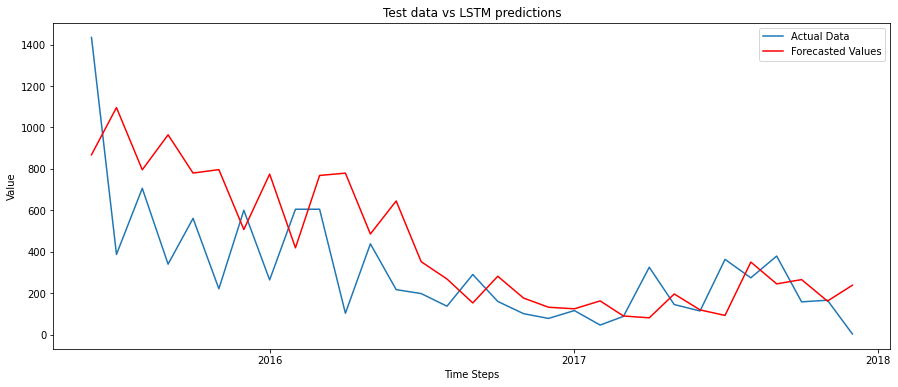

In [228]:
plt.figure(figsize=(15,6))
plt.title("Train data vs LSTM predictions")
plot_results(index_train, true_train_lstm, pred_train_lstm)

plt.figure(figsize=(15,6))
plt.title("Test data vs LSTM predictions")
plot_results(index_test, true_test_lstm, pred_test_lstm)

### TCN

1/1 [==============================] - 0s 110ms/step - loss: 2.0229e-05
Train Loss: 2.022916669375263e-05
1/1 [==============================] - 0s 23ms/step - loss: 4.6196
Test Loss: 4.619552135467529
1/1 [==============================] - 0s 93ms/step
MSE on train dataset:  1.5639561160246311
R2 on train dataset:  0.9999673307295488
1/1 [==============================] - 0s 31ms/step
MSE on test dataset:  747.3696627164072
R2 on test dataset:  -4.058442932944341


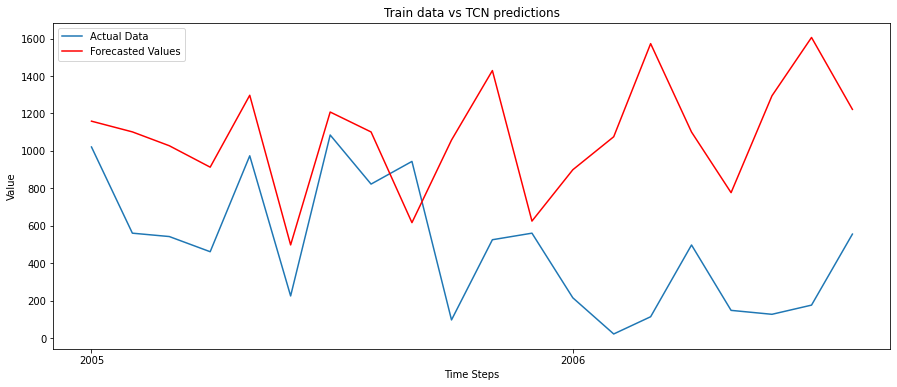

2/2 [==============================] - 0s 14ms/step - loss: 0.0030
Train Loss: 0.0029919417575001717
1/1 [==============================] - 0s 26ms/step - loss: 0.2531
Test Loss: 0.25310850143432617
2/2 [==============================] - 0s 4ms/step
MSE on train dataset:  22.8290832606222
R2 on train dataset:  0.997020653815257
1/1 [==============================] - 0s 27ms/step
MSE on test dataset:  209.97385777040873
R2 on test dataset:  -1.9978811361662774


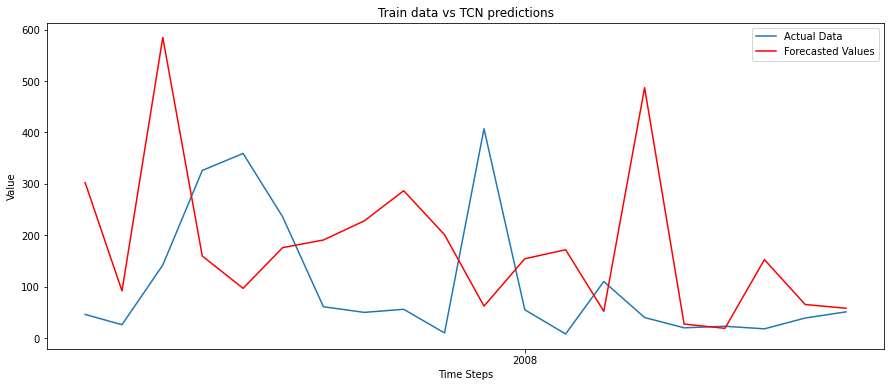

3/3 [==============================] - 0s 9ms/step - loss: 0.0396
Train Loss: 0.039625462144613266
1/1 [==============================] - 0s 24ms/step - loss: 0.0982
Test Loss: 0.09823710471391678
3/3 [==============================] - 0s 4ms/step
MSE on train dataset:  93.83900041822893
R2 on train dataset:  0.9617411849950187
1/1 [==============================] - 0s 32ms/step
MSE on test dataset:  147.7522133917851
R2 on test dataset:  -0.20627105325868844


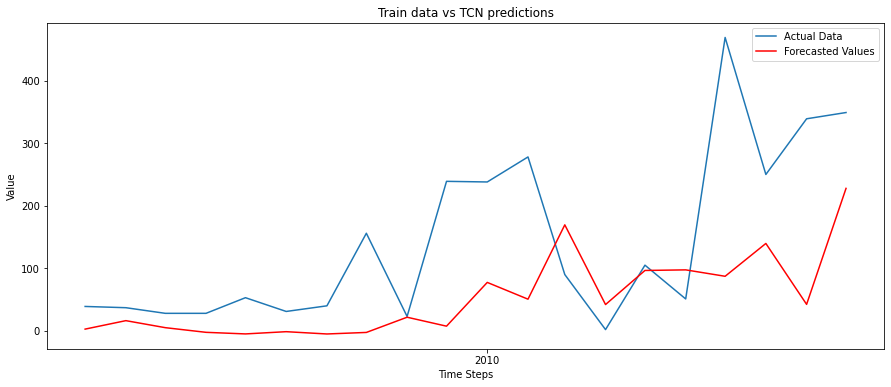

4/4 [==============================] - 0s 3ms/step - loss: 0.0419
Train Loss: 0.041869912296533585
1/1 [==============================] - 0s 24ms/step - loss: 2.1270
Test Loss: 2.1269867420196533
4/4 [==============================] - 0s 8ms/step
MSE on train dataset:  94.94630296514033
R2 on train dataset:  0.9591500704168991
1/1 [==============================] - 0s 19ms/step
MSE on test dataset:  676.7205712096356
R2 on test dataset:  -1.975910928150633


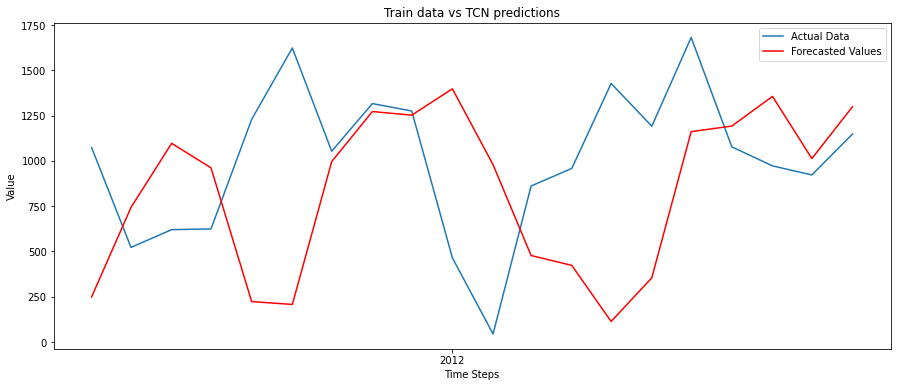

4/4 [==============================] - 0s 3ms/step - loss: 0.0338
Train Loss: 0.03382875770330429
1/1 [==============================] - 0s 24ms/step - loss: 1.0794
Test Loss: 1.0794124603271484
4/4 [==============================] - 0s 4ms/step
MSE on train dataset:  90.06533880517239
R2 on train dataset:  0.9669333140781565
1/1 [==============================] - 0s 24ms/step
MSE on test dataset:  508.7546687884279
R2 on test dataset:  -0.33208606738231783


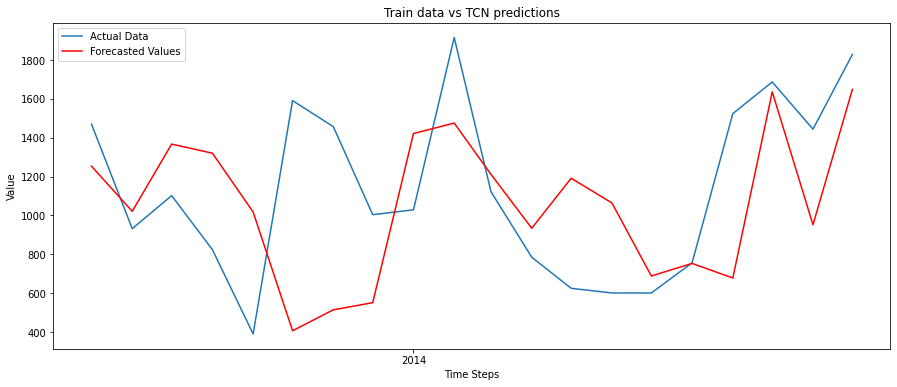

In [229]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Number']):
    train_data, test_data = ts_lstm_train['Number'][train_index], ts_lstm_train['Number'][test_index]
    
    train_index = train_data.index
    test_index = test_data.index
    
    X_train_lstm=np.array(train_data).reshape(-1,1)
    X_test_lstm=np.array(test_data).reshape(-1,1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index)

    model_tcn = tcn(X_train, X_test, y_train, y_test, 200)
    true_train_tcn, true_test_tcn, pred_train_tcn, pred_test_tcn, train_mse_tcn, test_mse_tcn = get_mse_lstm_tcn(
        model_tcn, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs TCN predictions")
    plot_results(index_test, true_test_tcn, pred_test_tcn)
 
    all_train_mse.append(test_mse_tcn)
    
average_train_mse_tcn = np.mean(all_train_mse)


In [230]:
average_train_mse_tcn

458.1141947753329

In [231]:
X_train_lstm=np.array(ts_lstm_train['Number']).reshape(-1,1)
X_test_lstm=np.array(ts_lstm_test['Number']).reshape(-1,1)

train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index)

model_tcn = tcn(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 4ms/step - loss: 0.0379
Train Loss: 0.037862204015254974
1/1 [==============================] - 0s 28ms/step - loss: 0.2960
Test Loss: 0.29597052931785583


In [232]:
print("TCN results:\n")
true_train_tcn, true_test_tcn, pred_train_tcn, pred_test_tcn, train_mse_tcn, test_mse_tcn = get_mse_lstm_tcn(
    model_tcn, X_train, X_test, y_train, y_test, scaler)

TCN results:

5/5 [==============================] - 0s 2ms/step
MSE on train dataset:  100.91536253567699
R2 on train dataset:  0.9628681337685533
1/1 [==============================] - 0s 41ms/step
MSE on test dataset:  282.148999189873
R2 on test dataset:  -0.04640789193747352


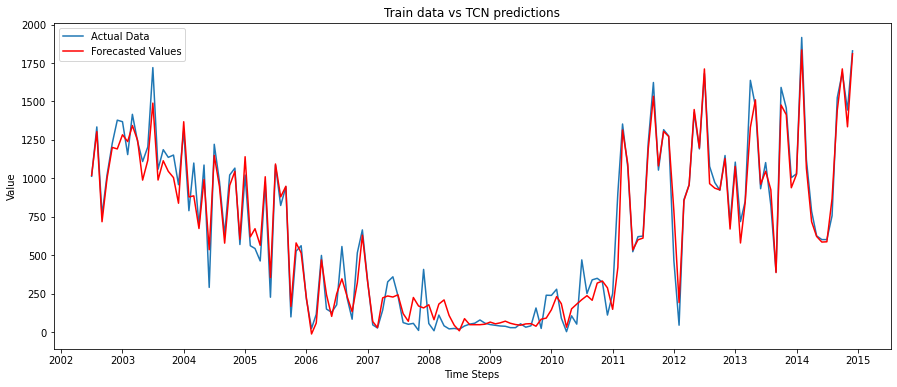

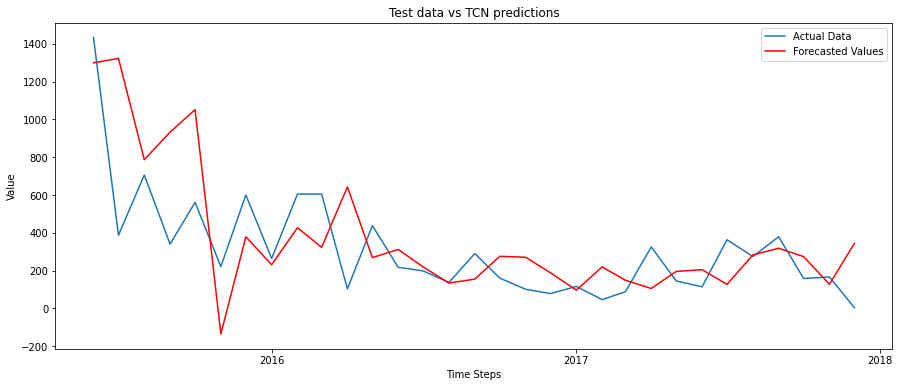

In [233]:
plt.figure(figsize=(15,6))
plt.title("Train data vs TCN predictions")
plot_results(index_train, true_train_tcn, pred_train_tcn)

plt.figure(figsize=(15,6))
plt.title("Test data vs TCN predictions")
plot_results(index_test, true_test_tcn, pred_test_tcn)

### Comparing model performances

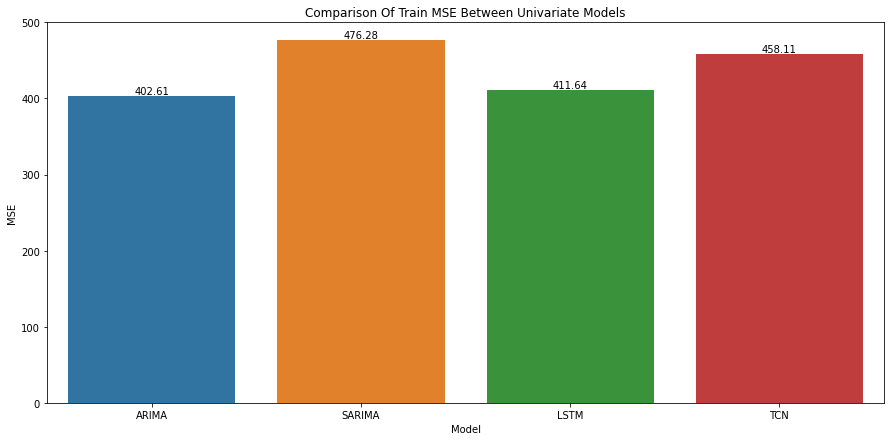

In [234]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Train MSE Between Univariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[average_train_mse_arima, average_train_mse_sarima, average_train_mse_lstm, average_train_mse_tcn]
sns.barplot(['ARIMA','SARIMA','LSTM','TCN'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

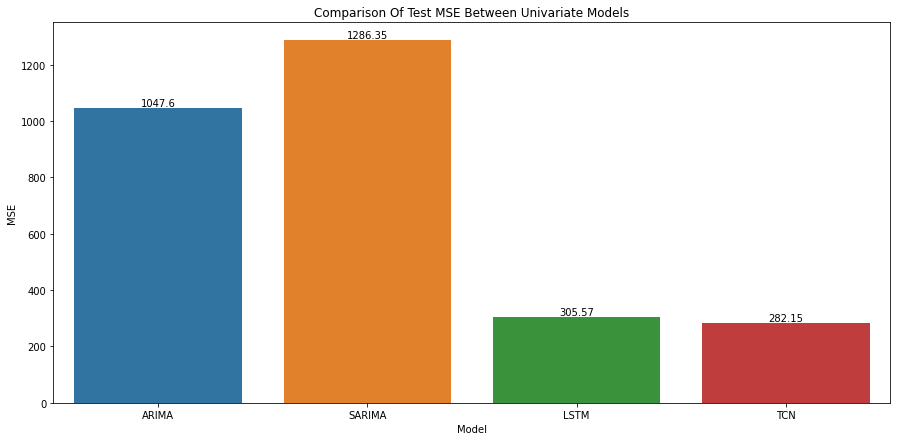

In [236]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Test MSE Between Univariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[test_mse_arima, test_mse_sarima, test_mse_lstm, test_mse_tcn]
sns.barplot(['ARIMA','SARIMA','LSTM','TCN'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

# Target - Duration

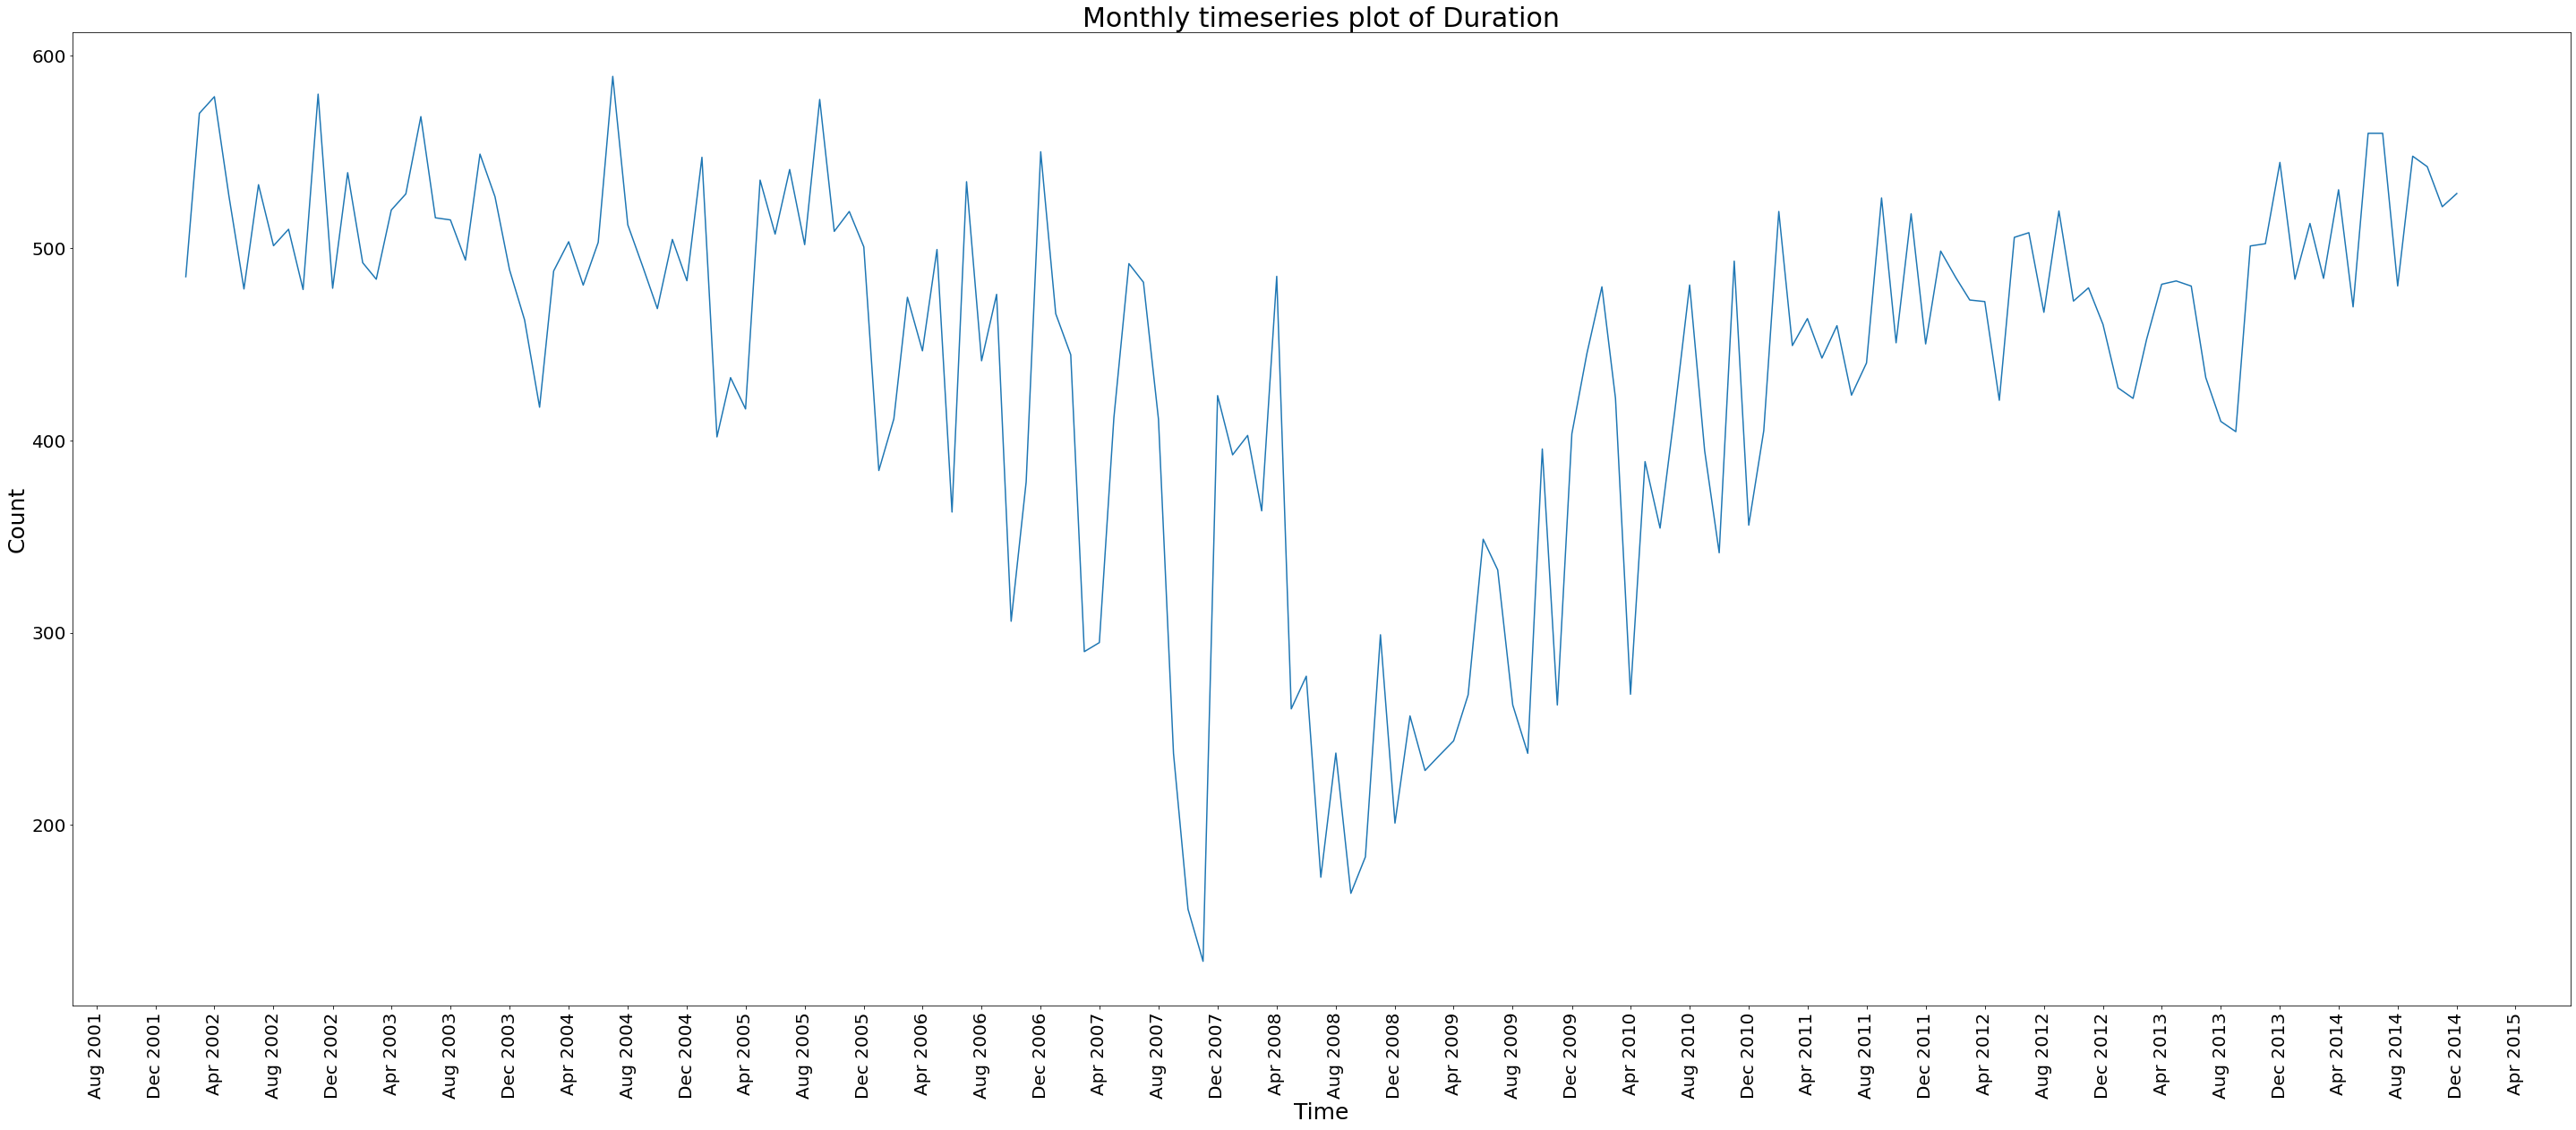

In [55]:
plt.figure(figsize=(50, 20))
sns.lineplot(y=train['Duration'], x=train.index, data=train)
plt.xlabel('Time', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.title('Monthly timeseries plot of Duration', fontsize=30)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

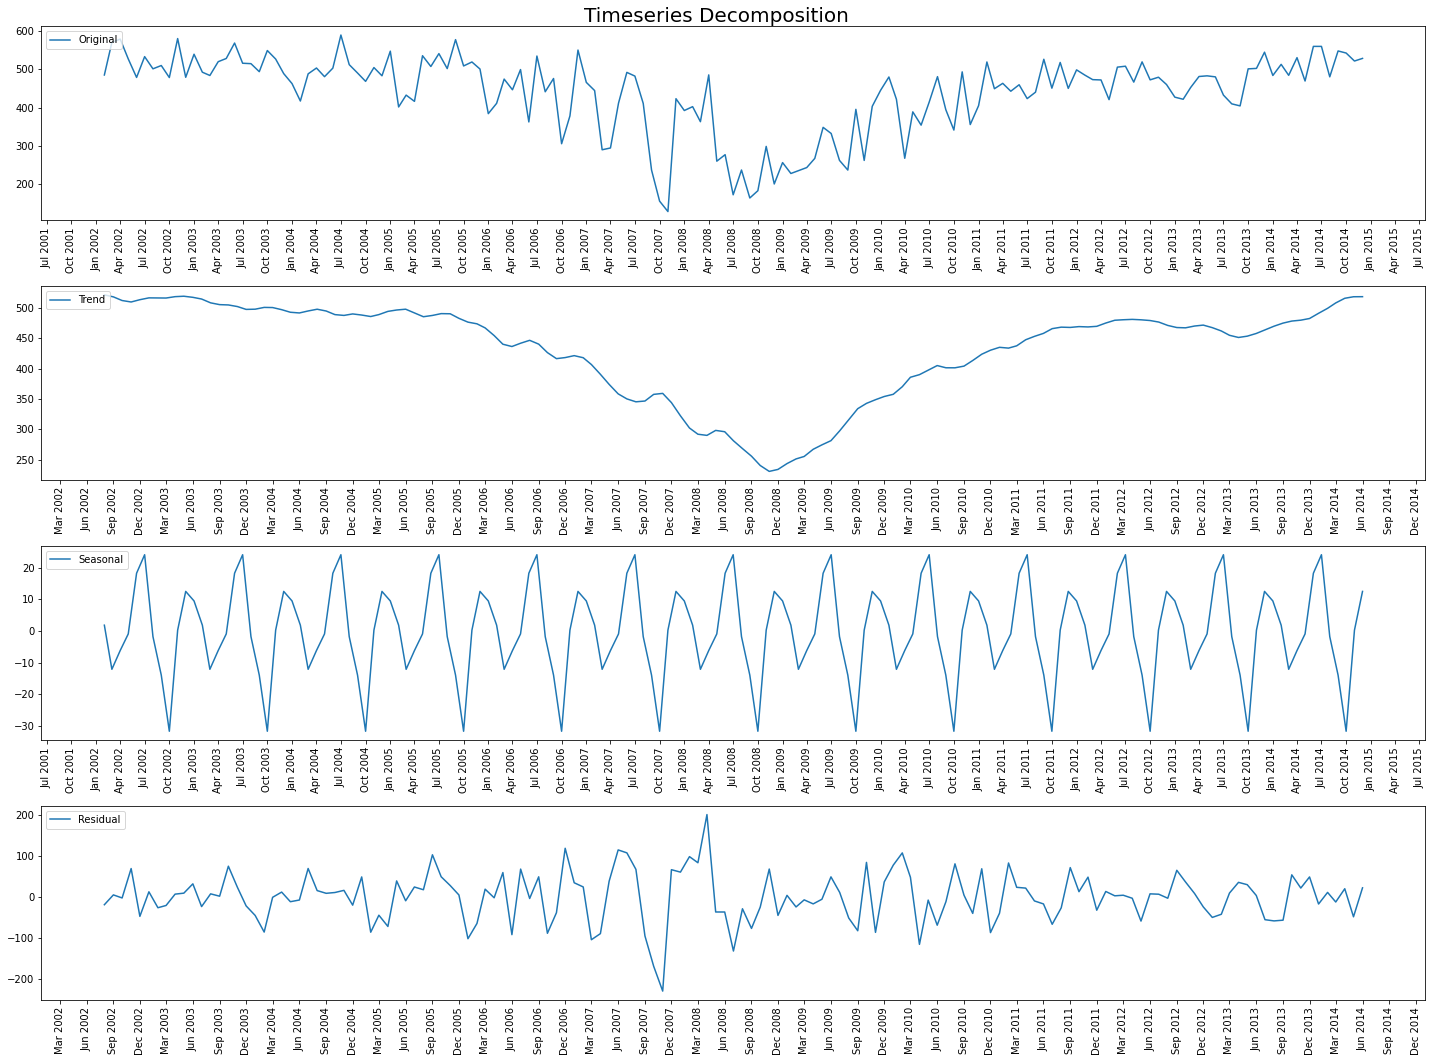

In [56]:
result = seasonal_decompose(train['Duration'], model='additive')

trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plotting the components
plt.figure(figsize=(20, 15))
plt.suptitle('Timeseries Decomposition', fontsize=20)

plt.subplot(411)
plt.plot(train['Duration'], label='Original')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

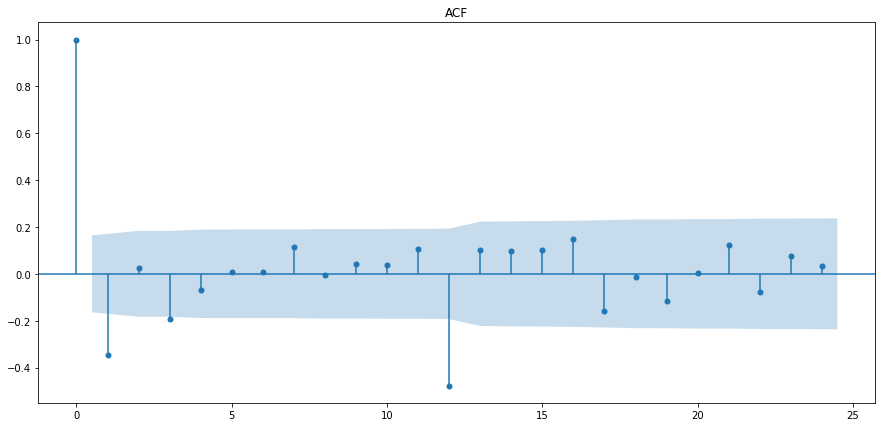

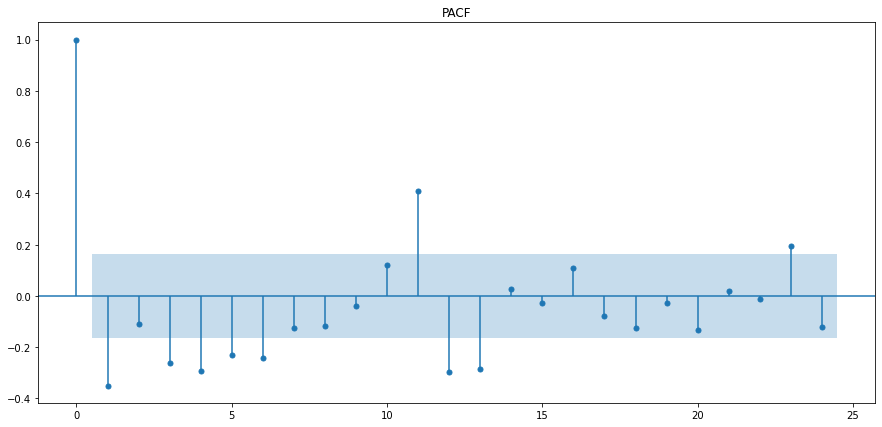

In [24]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(diff_train['Duration'].values, title='ACF', ax=ax, lags=24)
plt.show()
fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(diff_train['Duration'].values,  title='PACF', ax=ax, lags=24)
plt.show()

In [25]:
order = (1,1,1)
seasonal_order = (2,1,1,12)

In [123]:
print('ANOVA test between target and categorical feature:\n')
model = ols('Duration ~ Energy', data=train).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

ANOVA test between target and categorical feature:

                sum_sq     df           F        PR(>F)
Energy    1.006266e+06    1.0  277.040793  3.700322e-36
Residual  5.557260e+05  153.0         NaN           NaN


In [124]:
print("Granger Causality between Duration and Number:")
causality_test_result = grangercausalitytests(diff_train[['Duration','Number']], maxlag=3, verbose=True)

print("\n\nGranger Causality between Duration and Energy:")
causality_test_result = grangercausalitytests(diff_train[['Duration','Energy_encoded']], maxlag=3, verbose=True)

Granger Causality between Duration and Number:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9140  , p=0.0901  , df_denom=138, df_num=1
ssr based chi2 test:   chi2=2.9774  , p=0.0844  , df=1
likelihood ratio test: chi2=2.9464  , p=0.0861  , df=1
parameter F test:         F=2.9140  , p=0.0901  , df_denom=138, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6325  , p=0.1993  , df_denom=135, df_num=2
ssr based chi2 test:   chi2=3.3860  , p=0.1840  , df=2
likelihood ratio test: chi2=3.3457  , p=0.1877  , df=2
parameter F test:         F=1.6325  , p=0.1993  , df_denom=135, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3511  , p=0.2607  , df_denom=132, df_num=3
ssr based chi2 test:   chi2=4.2682  , p=0.2339  , df=3
likelihood ratio test: chi2=4.2040  , p=0.2403  , df=3
parameter F test:         F=1.3511  , p=0.2607  , df_denom=132, df_num=3


Granger Causality between Duration and Energy

## Univariate Analysis

### ARIMA

MSE on train dataset:  614.7692128172325
R2 on train dataset:  -2.1257427691304525
MSE on test dataset:  346.98954920404805
R2 on test dataset:  -0.012448918630342254


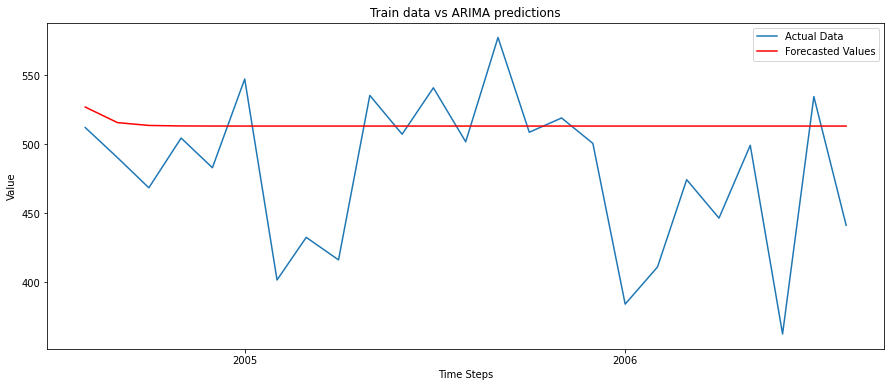

MSE on train dataset:  510.09962432301165
R2 on train dataset:  -0.49377842744799727
MSE on test dataset:  362.6277019744255
R2 on test dataset:  -3.2359625814424158


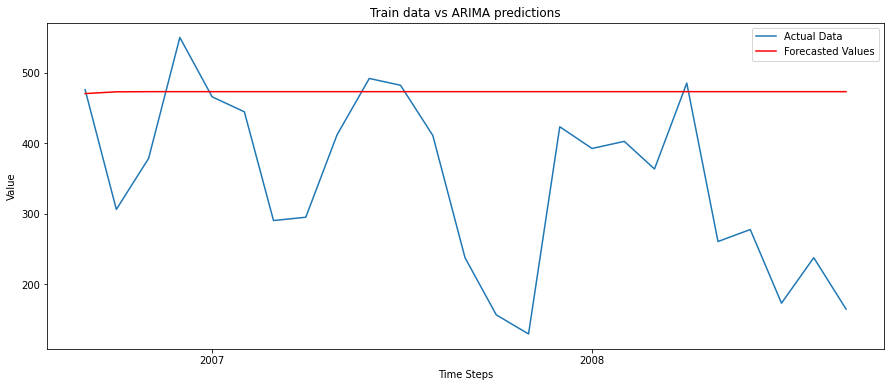

MSE on train dataset:  444.8192843811547
R2 on train dataset:  0.10962127156575852
MSE on test dataset:  142.6197194191314
R2 on test dataset:  -0.29716994543824726


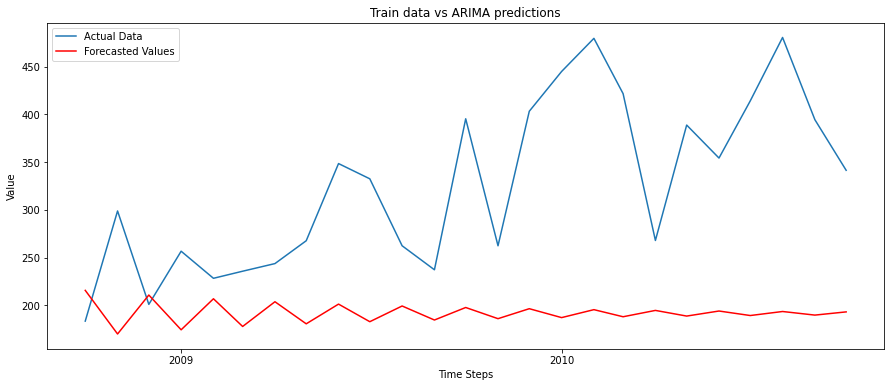

MSE on train dataset:  403.27374095081717
R2 on train dataset:  0.24465409878602062
MSE on test dataset:  702.446682464522
R2 on test dataset:  -1.5346903076482827


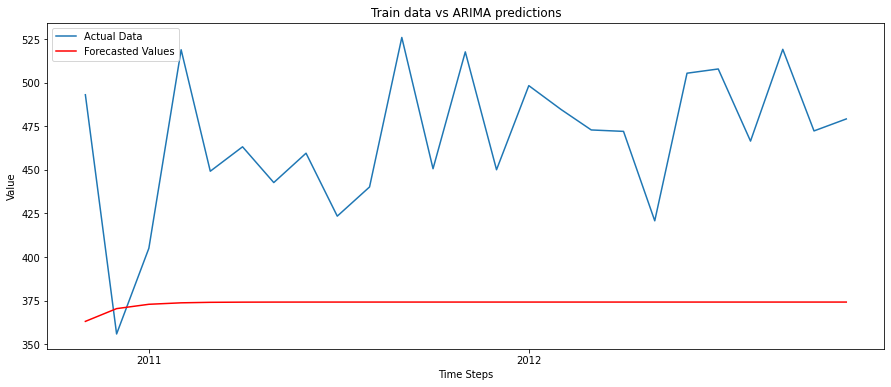

MSE on train dataset:  456.2855623034474
R2 on train dataset:  0.13175138088702543
MSE on test dataset:  758.7439354353439
R2 on test dataset:  -2.1577250384118374


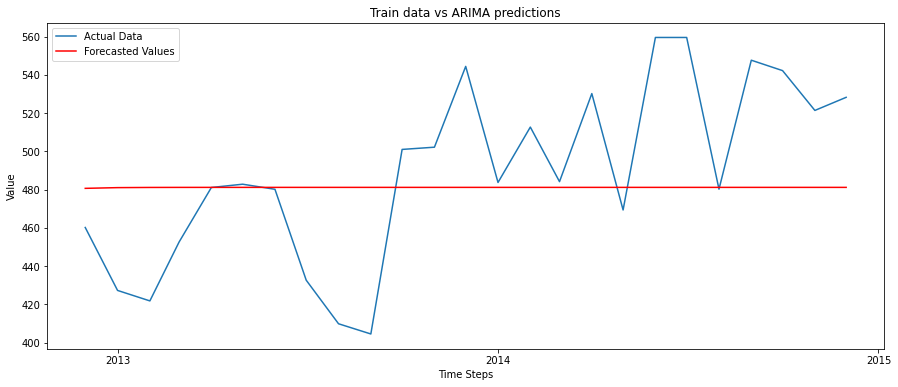

In [238]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    model = ARIMA(train_data['Duration'],order=order)
    arima_results = model.fit()

    pred_train_arima, pred_test_arima, train_mse_arima, test_mse_arima = get_mse_arima_sarima(
        arima_results, train_data, test_data)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs ARIMA predictions")
    plot_results(test_data.index, test_data['Duration'], pred_test_arima)
 
    all_train_mse.append(test_mse_arima)
average_train_mse_arima = np.mean(all_train_mse)

In [239]:
average_train_mse_arima

462.68551769949426

In [240]:
model = ARIMA(train['Duration'],order=order)
arima_results = model.fit()

In [241]:
print("ARIMA results:\n")
pred_train_arima, pred_test_arima, train_mse_arima, test_mse_arima = get_mse_arima_sarima(arima_results, train, test)

ARIMA results:

MSE on train dataset:  515.5128837597296
R2 on train dataset:  0.01196925593347109
MSE on test dataset:  393.77019274146727
R2 on test dataset:  -0.08414655959616502


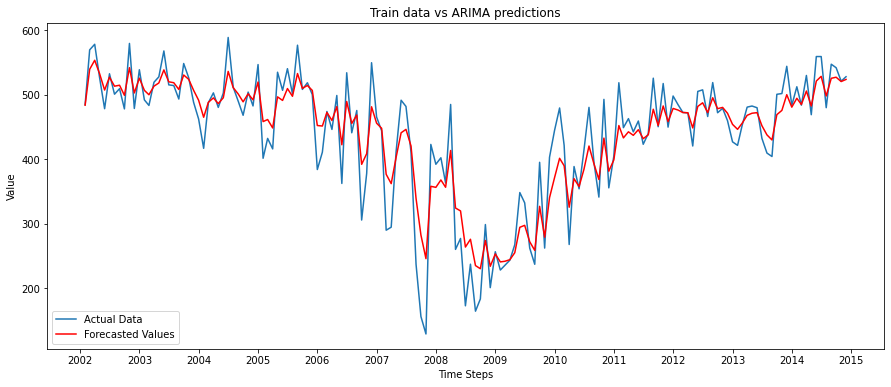

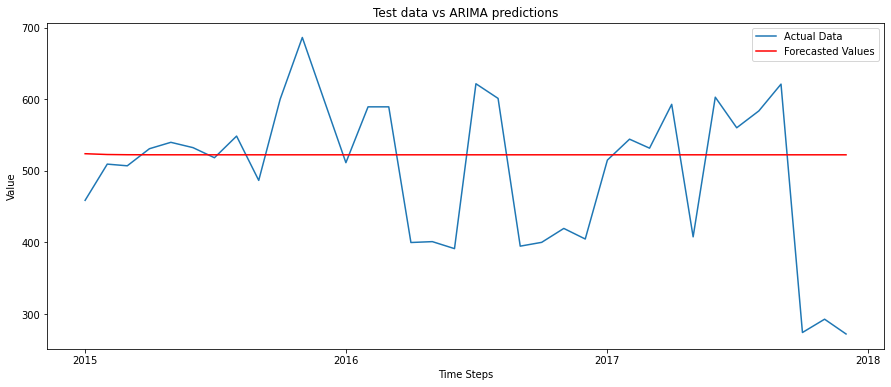

In [242]:
plt.figure(figsize=(15,6))
plt.title("Train data vs ARIMA predictions")
plot_results(train.index, train['Duration'],pred_train_arima)

plt.figure(figsize=(15,6))
plt.title("Test data vs ARIMA predictions")
plot_results(test.index, test['Duration'],pred_test_arima)

### SARIMA

MSE on train dataset:  612.892644776473
R2 on train dataset:  -2.106689386312111
MSE on test dataset:  344.6374230909346
R2 on test dataset:  0.0012306642994016626


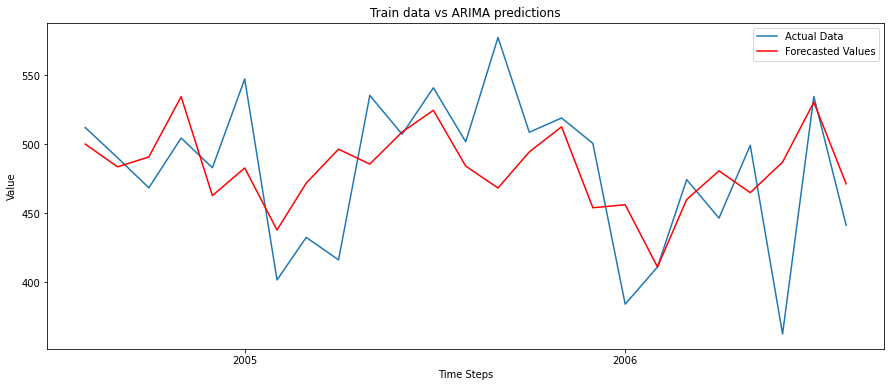

MSE on train dataset:  510.24533181518063
R2 on train dataset:  -0.49463193050562504
MSE on test dataset:  341.7499674290504
R2 on test dataset:  -2.76224542891371


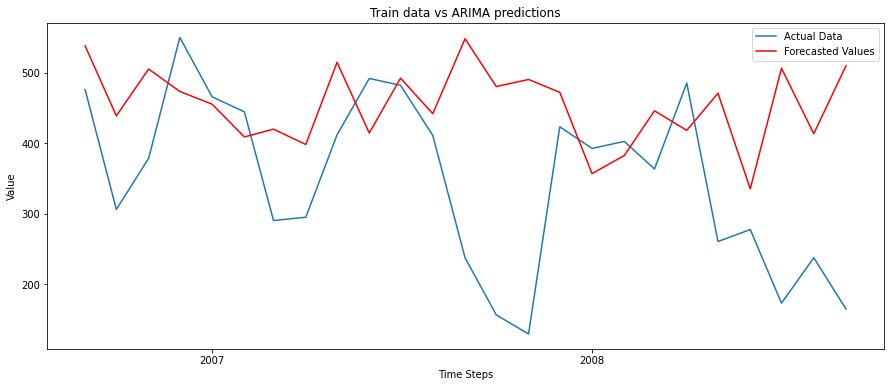

MSE on train dataset:  445.5789216972317
R2 on train dataset:  0.10657759760523988
MSE on test dataset:  214.9015580145225
R2 on test dataset:  -1.945213961720229


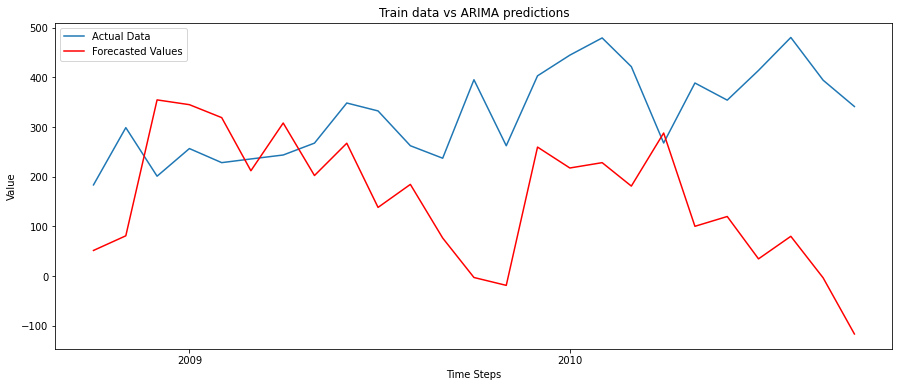

MSE on train dataset:  401.41861170485623
R2 on train dataset:  0.251587559116743
MSE on test dataset:  711.4975934960206
R2 on test dataset:  -1.60042925757522


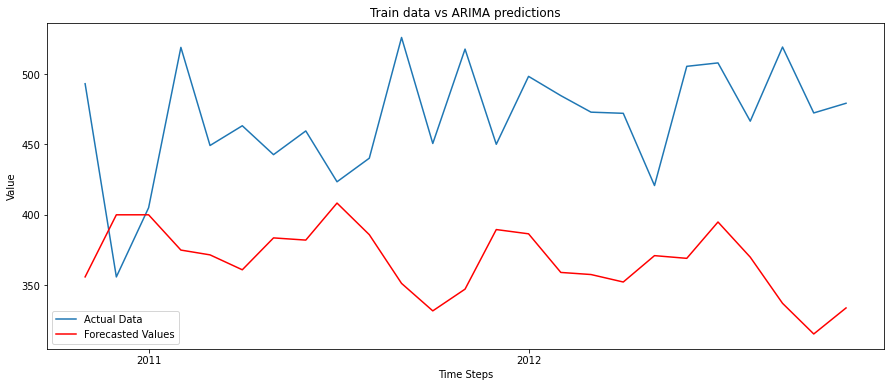

MSE on train dataset:  455.6867012667892
R2 on train dataset:  0.1340289855055552
MSE on test dataset:  758.102152354718
R2 on test dataset:  -2.1523853781656577


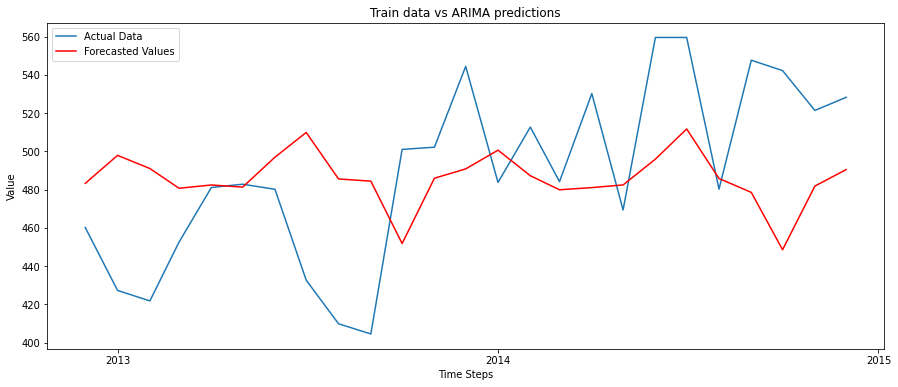

In [243]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    model = SARIMAX(train_data['Duration'],order=order, seasonal_order=seasonal_order)
    sarima_results = model.fit()
    
    pred_train_sarima, pred_test_sarima, train_mse_sarima, test_mse_sarima = get_mse_arima_sarima(sarima_results, train_data, test_data)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs ARIMA predictions")
    plot_results(test_data.index, test_data['Duration'], pred_test_sarima)
 
    all_train_mse.append(test_mse_sarima)
average_train_mse_sarima = np.mean(all_train_mse)

In [244]:
average_train_mse_sarima

474.17773887704925

In [245]:
model = SARIMAX(train['Duration'], order=order, seasonal_order=seasonal_order)
sarima_results = model.fit()

In [246]:
print("SARIMA results:\n")
pred_train_sarima, pred_test_sarima, train_mse_sarima, test_mse_sarima = get_mse_arima_sarima(sarima_results, train, test)

SARIMA results:

MSE on train dataset:  514.6628344839806
R2 on train dataset:  0.015224974243122302
MSE on test dataset:  397.3358409062603
R2 on test dataset:  -0.10386967445766349


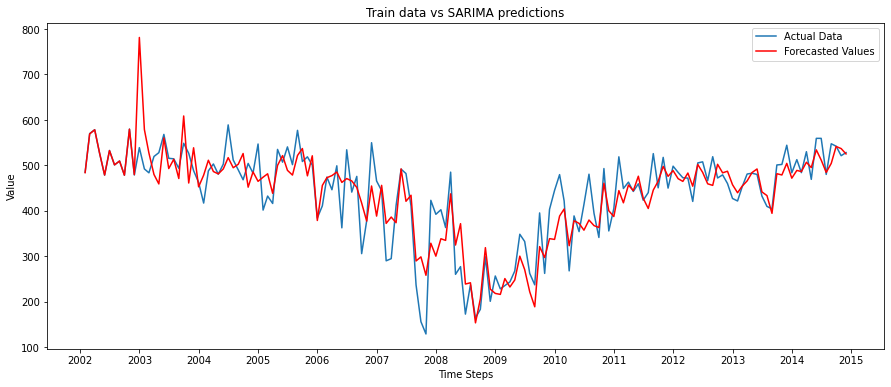

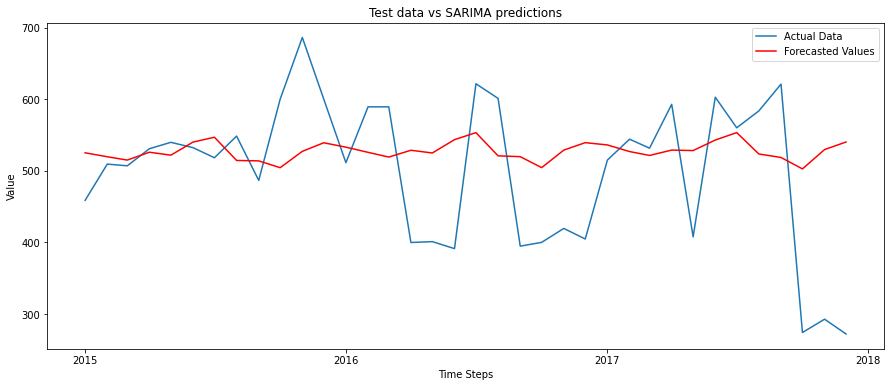

In [247]:
plt.figure(figsize=(15,6))
plt.title("Train data vs SARIMA predictions")
plot_results(train.index, train['Duration'],pred_train_sarima)

plt.figure(figsize=(15,6))
plt.title("Test data vs SARIMA predictions")
plot_results(test.index, test['Duration'],pred_test_sarima)

### LSTM

1/1 [==============================] - 0s 329ms/step - loss: 0.0292
Train Loss: 0.029247811064124107
1/1 [==============================] - 0s 31ms/step - loss: 3.9896
Test Loss: 3.9896302223205566
1/1 [==============================] - 0s 342ms/step
MSE on train dataset:  6.563982610766939
R2 on train dataset:  0.9685326430539329
1/1 [==============================] - 0s 28ms/step
MSE on test dataset:  76.6631753131111
R2 on test dataset:  -0.6665584890375131


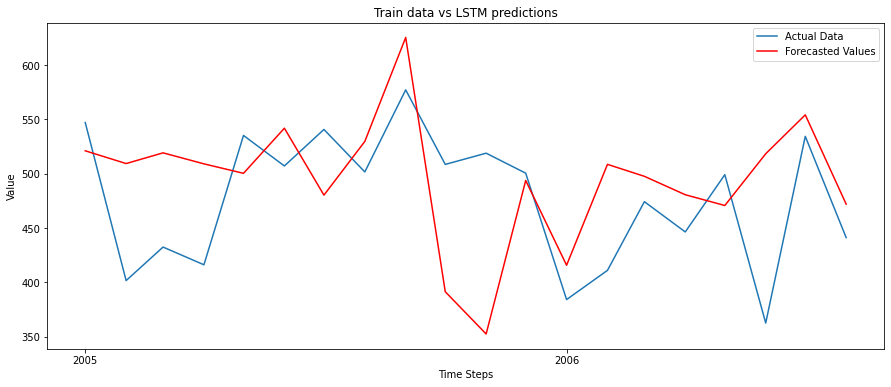

2/2 [==============================] - 0s 15ms/step - loss: 0.4872
Train Loss: 0.4872148036956787
1/1 [==============================] - 0s 32ms/step - loss: 2054.7212
Test Loss: 2054.72119140625
2/2 [==============================] - 0s 9ms/step
MSE on train dataset:  34.117876909972225
R2 on train dataset:  0.5062013670451817
1/1 [==============================] - 0s 17ms/step
MSE on test dataset:  2215.6349802985574
R2 on test dataset:  -364.5594412211786


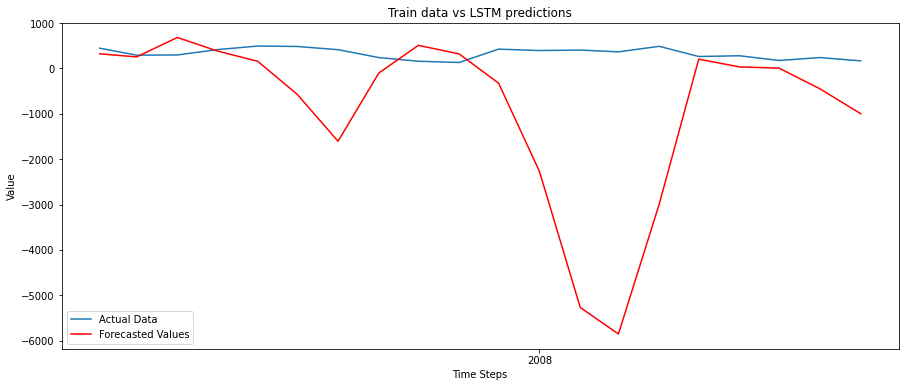

3/3 [==============================] - 0s 8ms/step - loss: 0.3046
Train Loss: 0.3046015799045563
1/1 [==============================] - 0s 24ms/step - loss: 0.7787
Test Loss: 0.7787156105041504
3/3 [==============================] - 0s 6ms/step
MSE on train dataset:  57.48993596888798
R2 on train dataset:  0.7006394699501187
1/1 [==============================] - 0s 20ms/step
MSE on test dataset:  91.92108492513394
R2 on test dataset:  -0.3319442547209339


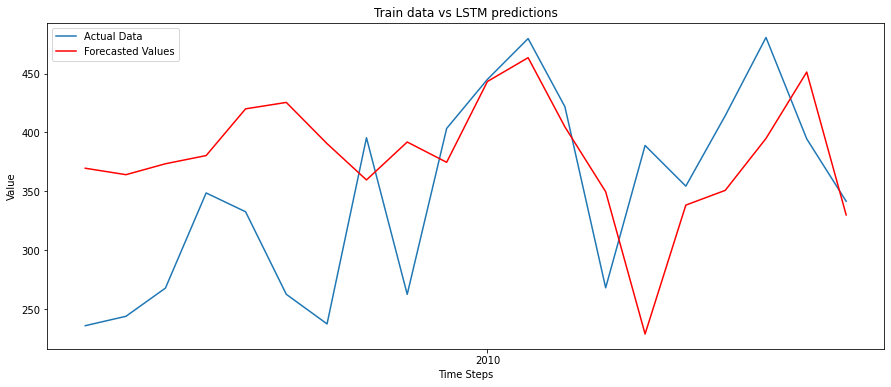

4/4 [==============================] - 0s 7ms/step - loss: 0.2462
Train Loss: 0.24615173041820526
1/1 [==============================] - 0s 16ms/step - loss: 0.1347
Test Loss: 0.13466815650463104
4/4 [==============================] - 0s 8ms/step
MSE on train dataset:  56.35814933808143
R2 on train dataset:  0.7531452886363835
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  41.68576112775881
R2 on test dataset:  -0.875718762407061


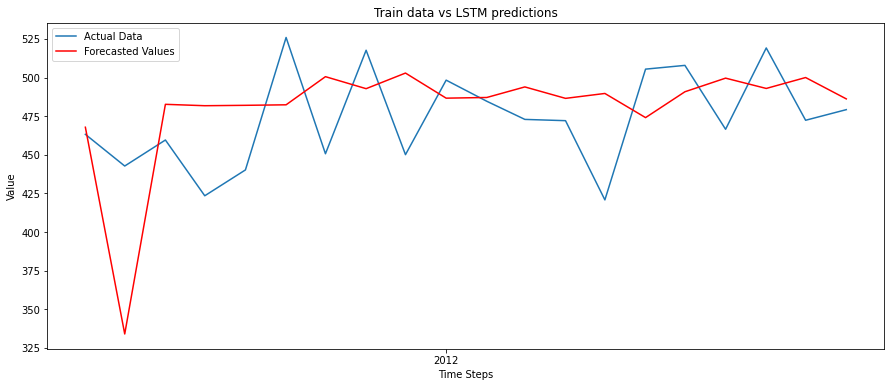

4/4 [==============================] - 1s 9ms/step - loss: 0.2290
Train Loss: 0.228959858417511
1/1 [==============================] - 0s 24ms/step - loss: 0.1440
Test Loss: 0.14403226971626282
4/4 [==============================] - 0s 8ms/step
MSE on train dataset:  50.32347567132588
R2 on train dataset:  0.7705718903920723
1/1 [==============================] - 0s 40ms/step
MSE on test dataset:  39.91360140664878
R2 on test dataset:  0.19853127892533107


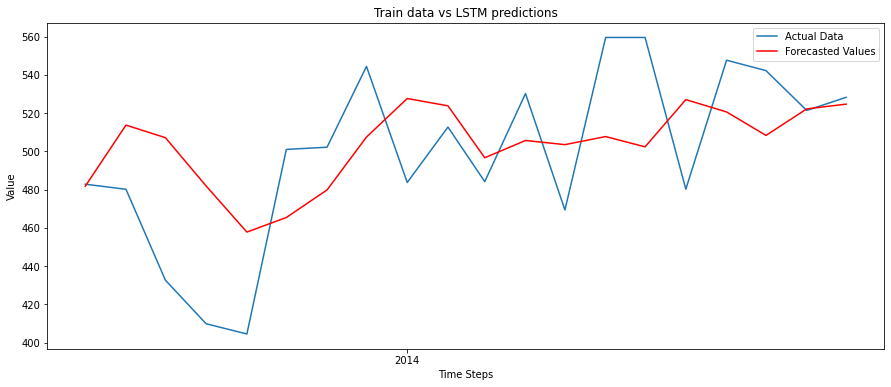

In [261]:
np.random.seed(random_seed)
ts_lstm_train=train.copy()
ts_lstm_test=test.copy()

tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Duration']):
    train_data, test_data = ts_lstm_train['Duration'][train_index], ts_lstm_train['Duration'][test_index]
    
    train_index = train_data.index
    test_index = test_data.index
    
    X_train_lstm=np.array(train_data).reshape(-1,1)
    X_test_lstm=np.array(test_data).reshape(-1,1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index)

    model_lstm = lstm(X_train, X_test, y_train, y_test, 200)
    true_train_lstm, true_test_lstm, pred_train_lstm, pred_test_lstm, train_mse_lstm, test_mse_lstm = get_mse_lstm_tcn(
        model_lstm, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs LSTM predictions")
    plot_results(index_test, true_test_lstm, pred_test_lstm)
 
    all_train_mse.append(test_mse_lstm)
    
average_train_mse_lstm = np.mean(all_train_mse)

In [262]:
average_train_mse_lstm

493.163720614242

In [263]:
X_train_lstm=np.array(ts_lstm_train['Duration']).reshape(-1,1)
X_test_lstm=np.array(ts_lstm_test['Duration']).reshape(-1,1)

train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index)

model_lstm = lstm(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 6ms/step - loss: 0.2228
Train Loss: 0.22277437150478363
1/1 [==============================] - 0s 17ms/step - loss: 1.2451
Test Loss: 1.2451481819152832


In [264]:
print("LSTM results:\n")
true_train_lstm, true_test_lstm, pred_train_lstm, pred_test_lstm, train_mse_lstm, test_mse_lstm = get_mse_lstm_tcn(
    model_lstm, X_train, X_test, y_train, y_test, scaler)

LSTM results:

5/5 [==============================] - 0s 6ms/step
MSE on train dataset:  47.381217787661036
R2 on train dataset:  0.777467218437864
1/1 [==============================] - 0s 23ms/step
MSE on test dataset:  112.01705335589575
R2 on test dataset:  -0.04910085274212084


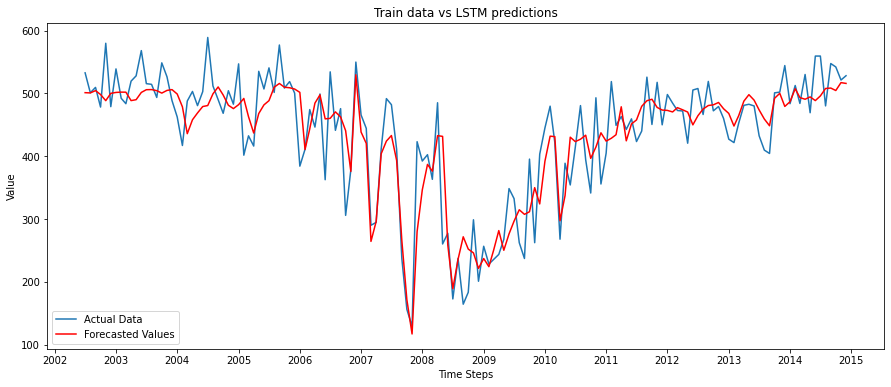

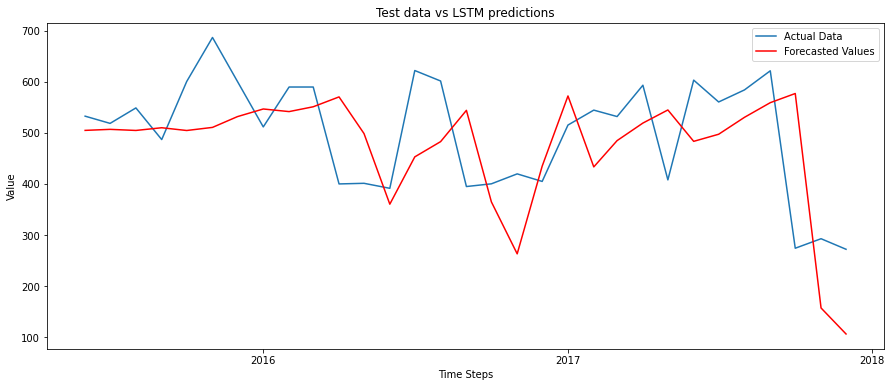

In [265]:
plt.figure(figsize=(15,6))
plt.title("Train data vs LSTM predictions")
plot_results(index_train, true_train_lstm, pred_train_lstm)

plt.figure(figsize=(15,6))
plt.title("Test data vs LSTM predictions")
plot_results(index_test, true_test_lstm, pred_test_lstm)

### TCN

1/1 [==============================] - 0s 110ms/step - loss: 2.3811e-08
Train Loss: 2.381060326683837e-08
1/1 [==============================] - 0s 16ms/step - loss: 5.4152
Test Loss: 5.415241241455078
1/1 [==============================] - 0s 133ms/step
MSE on train dataset:  0.005916707023769527
R2 on train dataset:  0.9999999744326596
1/1 [==============================] - 0s 35ms/step
MSE on test dataset:  89.31602097915597
R2 on test dataset:  -1.262068163785354


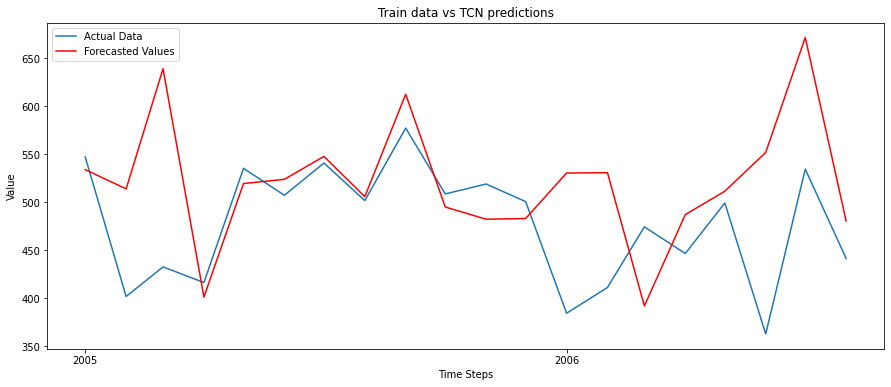

2/2 [==============================] - 0s 17ms/step - loss: 0.0022
Train Loss: 0.002182316267862916
1/1 [==============================] - 0s 23ms/step - loss: 17.7122
Test Loss: 17.712223052978516
2/2 [==============================] - 0s 6ms/step
MSE on train dataset:  2.2833935862133465
R2 on train dataset:  0.9977881919166649
1/1 [==============================] - 0s 25ms/step
MSE on test dataset:  205.71136637097493
R2 on test dataset:  -2.151215879130071


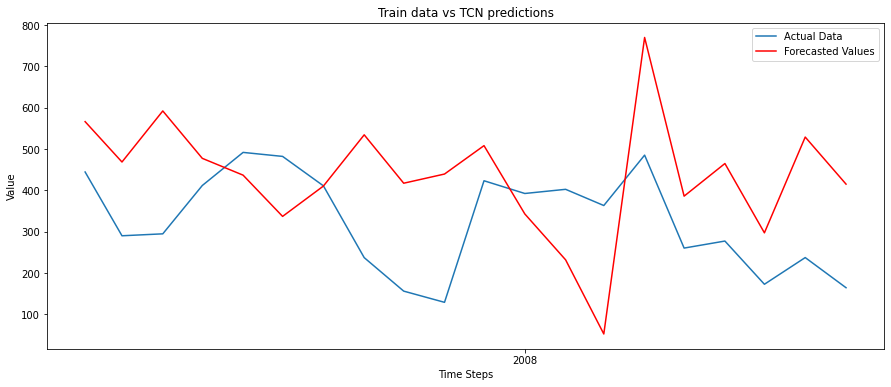

3/3 [==============================] - 0s 4ms/step - loss: 0.0414
Train Loss: 0.041373588144779205
1/1 [==============================] - 0s 27ms/step - loss: 1.2822
Test Loss: 1.2821928262710571
3/3 [==============================] - 0s 9ms/step
MSE on train dataset:  21.18787145852555
R2 on train dataset:  0.9593382984602062
1/1 [==============================] - 0s 24ms/step
MSE on test dataset:  117.95120685399937
R2 on test dataset:  -1.1931106475916873


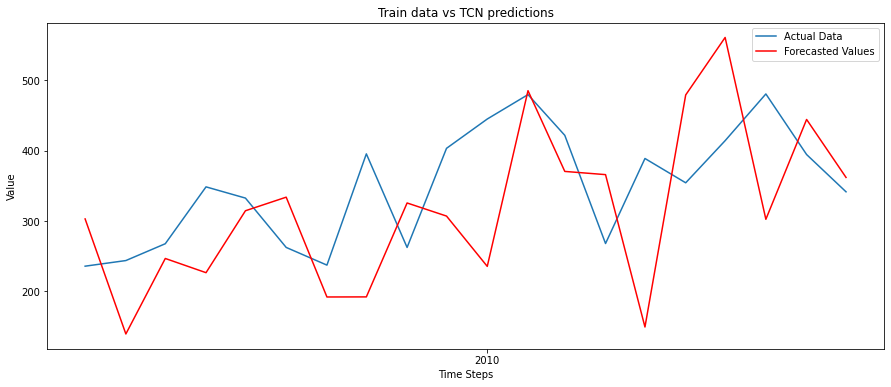

4/4 [==============================] - 0s 8ms/step - loss: 0.0544
Train Loss: 0.05441944673657417
1/1 [==============================] - 0s 25ms/step - loss: 0.1969
Test Loss: 0.19686822593212128
4/4 [==============================] - 0s 4ms/step
MSE on train dataset:  26.499178989337754
R2 on train dataset:  0.9454251173425301
1/1 [==============================] - 0s 32ms/step
MSE on test dataset:  50.40145710419597
R2 on test dataset:  -1.7420693576677952


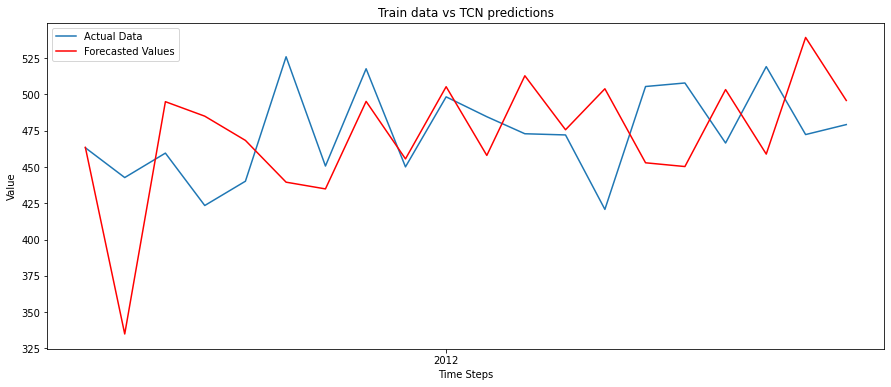

4/4 [==============================] - 0s 5ms/step - loss: 0.0452
Train Loss: 0.045168936252593994
1/1 [==============================] - 0s 17ms/step - loss: 0.2251
Test Loss: 0.2251262664794922
4/4 [==============================] - 0s 3ms/step
MSE on train dataset:  22.351718462983094
R2 on train dataset:  0.954738680958208
1/1 [==============================] - 0s 24ms/step
MSE on test dataset:  49.90040205514348
R2 on test dataset:  -0.25271660897732295


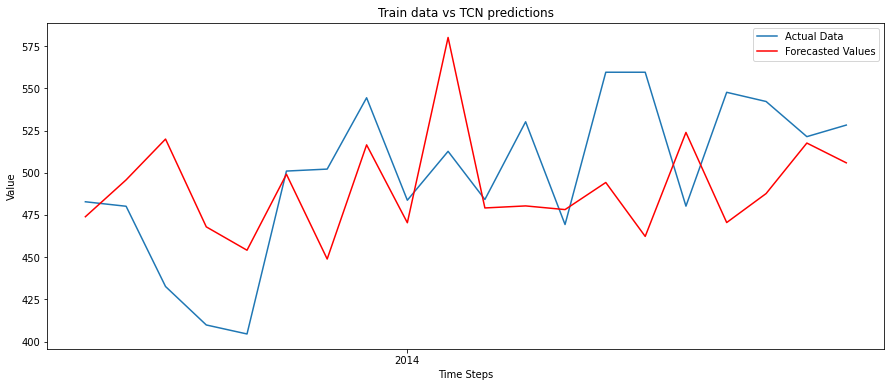

In [266]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Duration']):
    train_data, test_data = ts_lstm_train['Duration'][train_index], ts_lstm_train['Duration'][test_index]
    
    train_index = train_data.index
    test_index = test_data.index
    
    X_train_lstm=np.array(train_data).reshape(-1,1)
    X_test_lstm=np.array(test_data).reshape(-1,1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index)

    model_tcn = tcn(X_train, X_test, y_train, y_test, 200)
    true_train_tcn, true_test_tcn, pred_train_tcn, pred_test_tcn, train_mse_tcn, test_mse_tcn = get_mse_lstm_tcn(
        model_tcn, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs TCN predictions")
    plot_results(index_test, true_test_tcn, pred_test_tcn)
 
    all_train_mse.append(test_mse_tcn)
    
average_train_mse_tcn = np.mean(all_train_mse)

In [267]:
average_train_mse_tcn

102.65609067269392

In [268]:
X_train_lstm=np.array(ts_lstm_train['Duration']).reshape(-1,1)
X_test_lstm=np.array(ts_lstm_test['Duration']).reshape(-1,1)

train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index)

model_tcn = tcn(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 2ms/step - loss: 0.0491
Train Loss: 0.049122560769319534
1/1 [==============================] - 0s 21ms/step - loss: 1.5618
Test Loss: 1.5618394613265991


In [272]:
print("TCN results:\n")
true_train_tcn, true_test_tcn, pred_train_tcn, pred_test_tcn, train_mse_tcn, test_mse_tcn = get_mse_lstm_tcn(
    model_tcn, X_train, X_test, y_train, y_test, scaler)

TCN results:

5/5 [==============================] - 0s 4ms/step
MSE on train dataset:  22.249185949361934
R2 on train dataset:  0.95093070589758
1/1 [==============================] - 0s 19ms/step
MSE on test dataset:  125.45610332260057
R2 on test dataset:  -0.31592924873054673


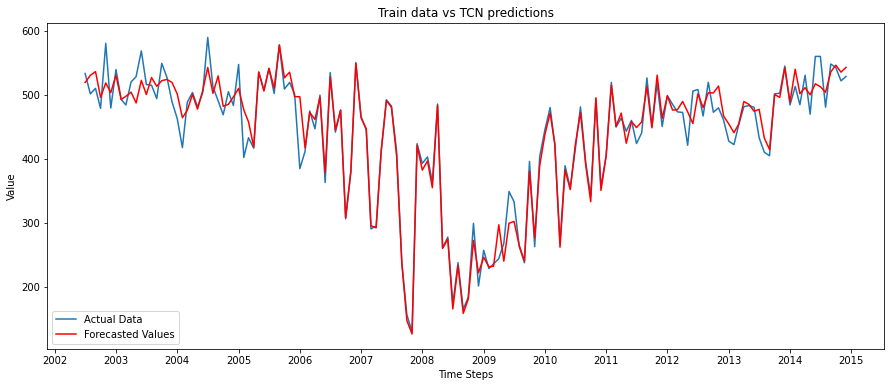

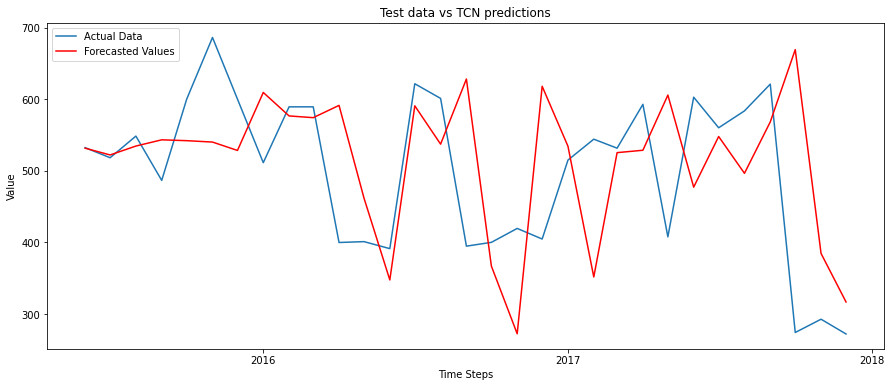

In [273]:
plt.figure(figsize=(15,6))
plt.title("Train data vs TCN predictions")
plot_results(index_train, true_train_tcn, pred_train_tcn)

plt.figure(figsize=(15,6))
plt.title("Test data vs TCN predictions")
plot_results(index_test, true_test_tcn, pred_test_tcn)

### Comparing model performances

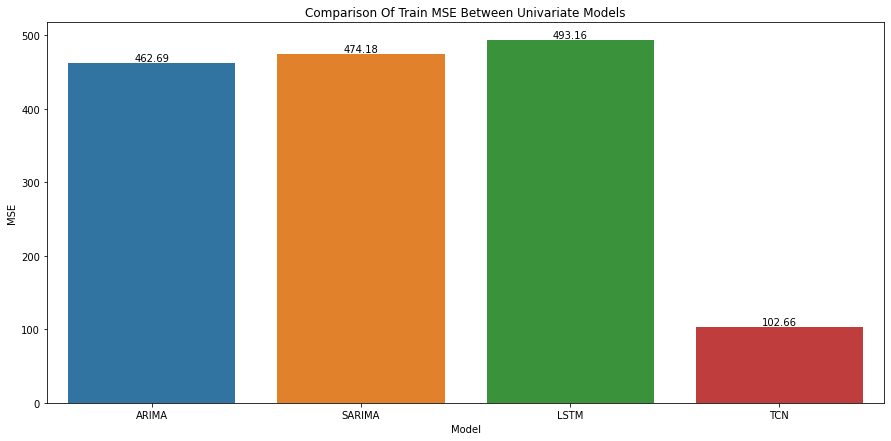

In [274]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Train MSE Between Univariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[average_train_mse_arima, average_train_mse_sarima, average_train_mse_lstm, average_train_mse_tcn]
sns.barplot(['ARIMA','SARIMA','LSTM','TCN'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

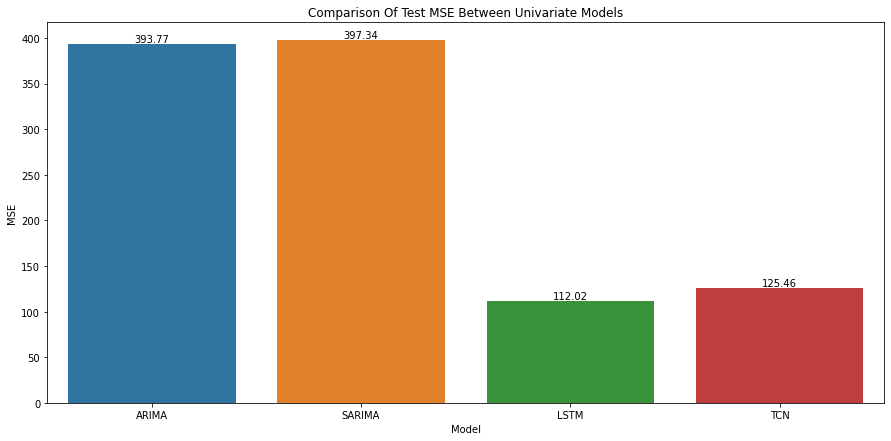

In [275]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Test MSE Between Univariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[test_mse_arima, test_mse_sarima, test_mse_lstm, test_mse_tcn]
sns.barplot(['ARIMA','SARIMA','LSTM','TCN'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

## Multivariate Analysis

### SARIMAX

MSE on train dataset:  609.1378108886333
R2 on train dataset:  -2.0687402607556042
MSE on test dataset:  343.3578137994217
R2 on test dataset:  0.008633585863370041


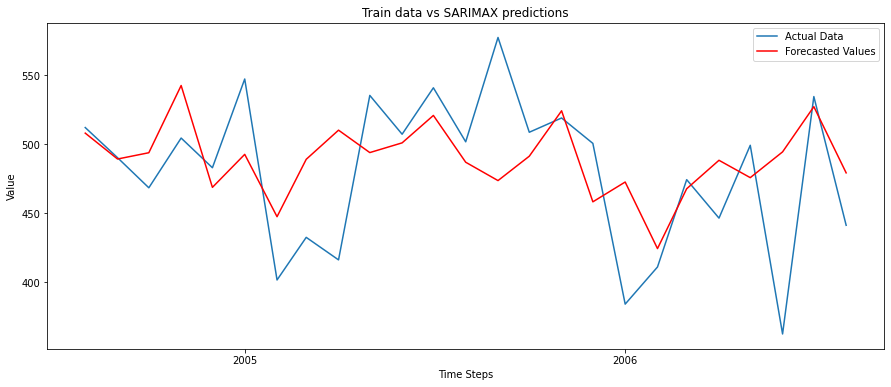

MSE on train dataset:  508.47052503332094
R2 on train dataset:  -0.48425233757279185
MSE on test dataset:  343.85936922465237
R2 on test dataset:  -2.808832584390641


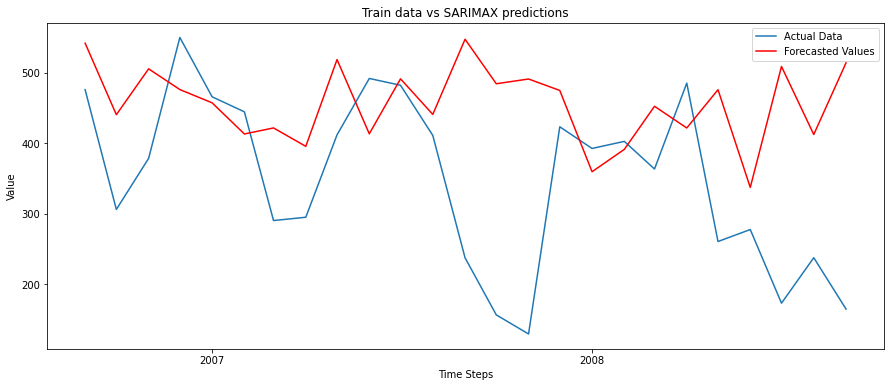

MSE on train dataset:  444.98560185819275
R2 on train dataset:  0.1089553236923676
MSE on test dataset:  189.05331184197027
R2 on test dataset:  -1.2793252516294578


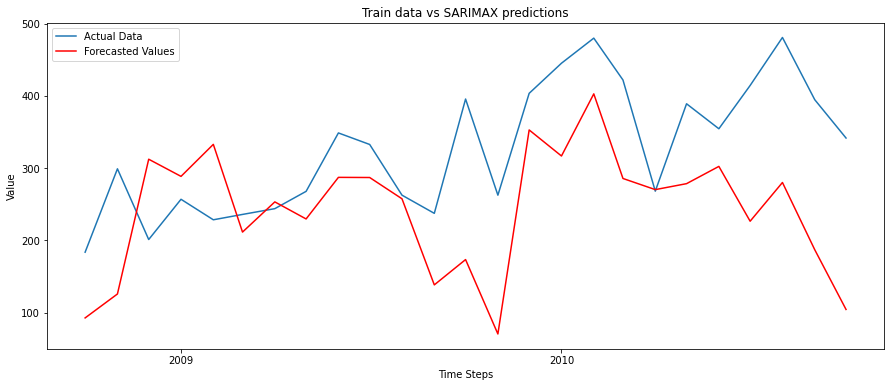

MSE on train dataset:  401.4110616880752
R2 on train dataset:  0.2516157116397427
MSE on test dataset:  684.2560354988133
R2 on test dataset:  -1.4051127813380608


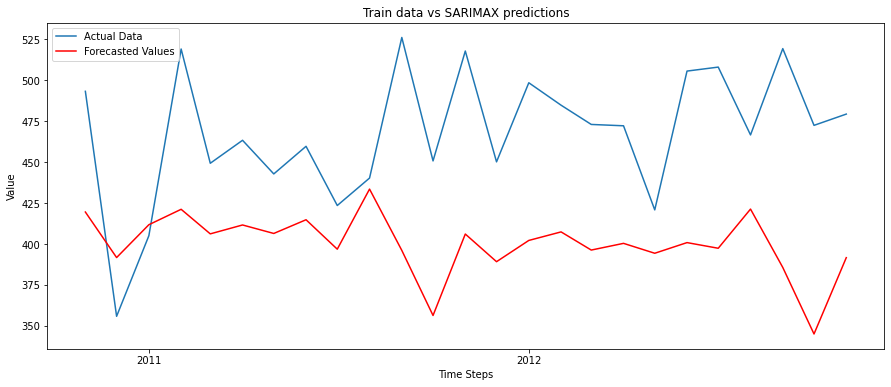

MSE on train dataset:  454.5873305672959
R2 on train dataset:  0.13820235616416565
MSE on test dataset:  796.7993757685366
R2 on test dataset:  -2.482425349188851


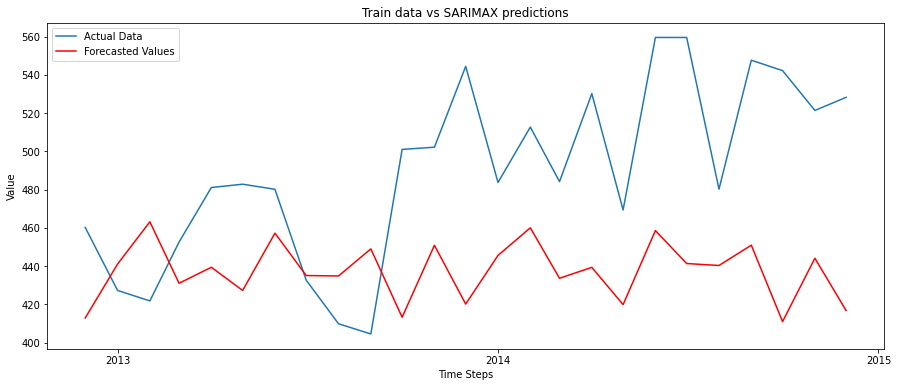

In [276]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    model = SARIMAX(train_data['Duration'],order=order, seasonal_order=seasonal_order, exog=train_data[['Number','Energy_encoded']])
    sarimax_results = model.fit()

    pred_train_sarimax, pred_test_sarimax, train_mse_sarimax, test_mse_sarimax = get_mse_arima_sarima(
        sarimax_results, train_data, test_data, True)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs SARIMAX predictions")
    plot_results(test_data.index, test_data['Duration'], pred_test_sarimax)
 
    all_train_mse.append(test_mse_sarimax)
    
average_train_mse_sarimax = np.mean(all_train_mse)

In [277]:
average_train_mse_sarimax

471.46518122667885

In [278]:
model = SARIMAX(train['Duration'], order=order, seasonal_order=seasonal_order, exog=train[['Number','Energy_encoded']])  # Example order (p, d, q)
sarimax_results = model.fit()

In [279]:
print("SARIMAX results:\n")
pred_train_sarimax, pred_test_sarimax, train_mse_sarimax, test_mse_sarimax = get_mse_arima_sarima(sarimax_results, train, test, True)

SARIMAX results:

MSE on train dataset:  514.6561278371697
R2 on train dataset:  0.015250639571220748
MSE on test dataset:  370.16886253856967
R2 on test dataset:  0.04191930709300595


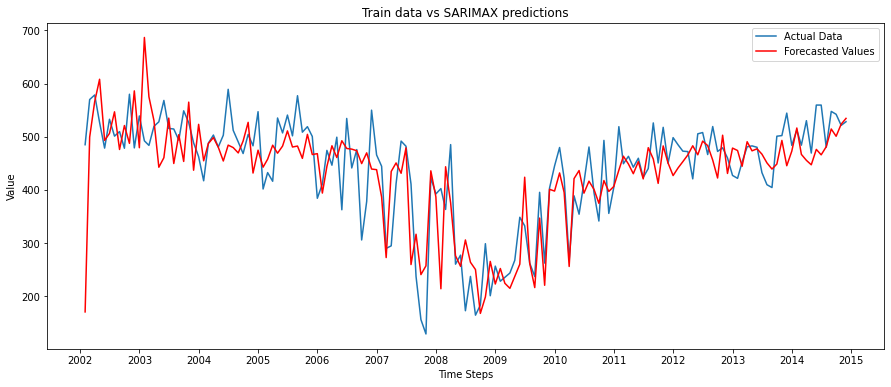

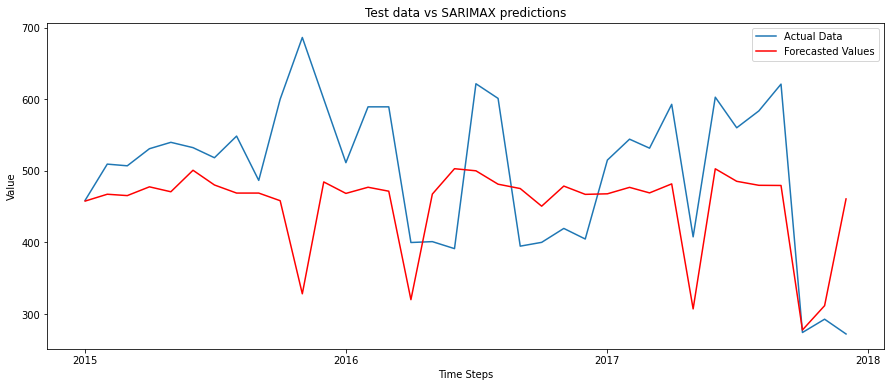

In [280]:
plt.figure(figsize=(15,6))
plt.title("Train data vs SARIMAX predictions")
plot_results(train.index, train['Duration'],pred_train_sarimax)

plt.figure(figsize=(15,6))
plt.title("Test data vs SARIMAX predictions")
plot_results(test.index, test['Duration'],pred_test_sarimax)

### LSTM

1/1 [==============================] - 0s 355ms/step - loss: 0.0455
Train Loss: 0.04553372040390968
1/1 [==============================] - 0s 34ms/step - loss: 3.5218
Test Loss: 3.521829128265381
1/1 [==============================] - 0s 372ms/step
MSE on train dataset:  8.190058356802183
R2 on train dataset:  0.9510109051417442
1/1 [==============================] - 0s 33ms/step
MSE on test dataset:  72.02853626331625
R2 on test dataset:  -0.4711472085501769


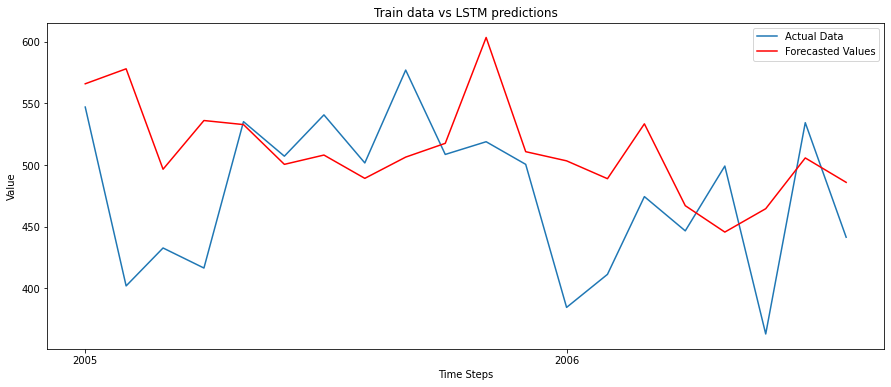

2/2 [==============================] - 0s 19ms/step - loss: 0.5970
Train Loss: 0.5970093011856079
1/1 [==============================] - 0s 21ms/step - loss: 7.8327
Test Loss: 7.832720756530762
2/2 [==============================] - 0s 5ms/step
MSE on train dataset:  37.766984560233475
R2 on train dataset:  0.3949231899066996
1/1 [==============================] - 0s 26ms/step
MSE on test dataset:  136.79747666641222
R2 on test dataset:  -0.39353458524177776


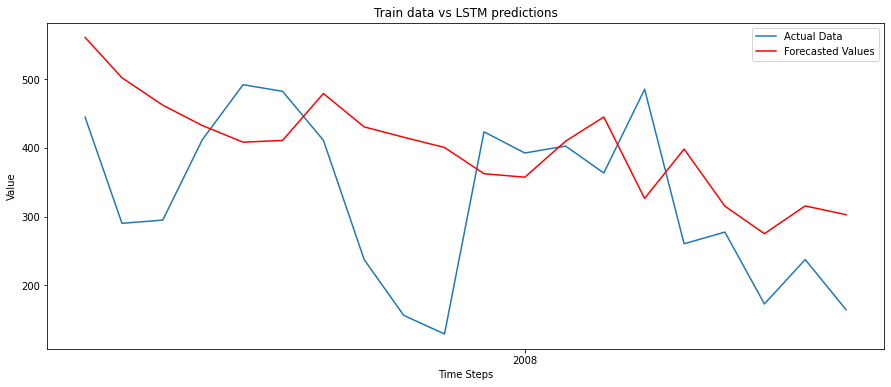

3/3 [==============================] - 0s 7ms/step - loss: 0.1602
Train Loss: 0.16015282273292542
1/1 [==============================] - 0s 30ms/step - loss: 1.2961
Test Loss: 1.296116590499878
3/3 [==============================] - 0s 11ms/step
MSE on train dataset:  41.68626977225422
R2 on train dataset:  0.8426028157823962
1/1 [==============================] - 0s 28ms/step
MSE on test dataset:  118.58992092576841
R2 on test dataset:  -1.2169266526113285


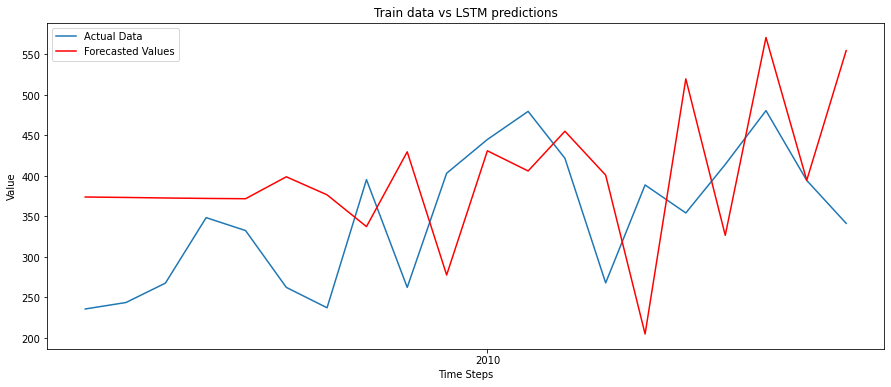

4/4 [==============================] - 0s 9ms/step - loss: 0.2676
Train Loss: 0.26760125160217285
1/1 [==============================] - 0s 24ms/step - loss: 0.3219
Test Loss: 0.32189762592315674
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  58.762375055225405
R2 on train dataset:  0.7316345179315635
1/1 [==============================] - 0s 26ms/step
MSE on test dataset:  64.44869719290828
R2 on test dataset:  -3.4835347156658507


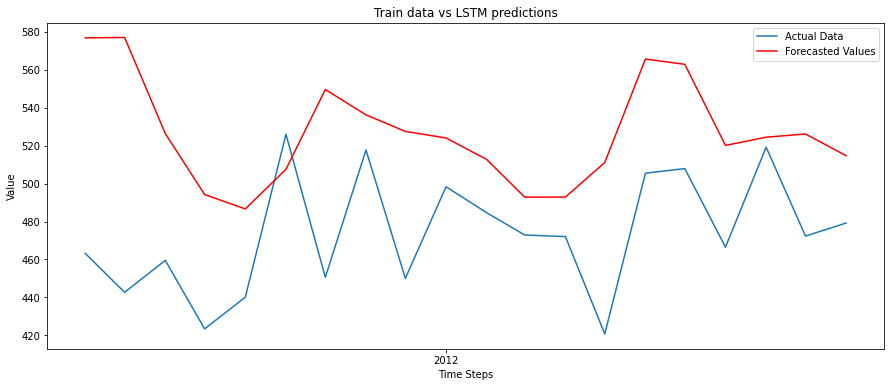

4/4 [==============================] - 0s 5ms/step - loss: 0.2242
Train Loss: 0.22419846057891846
1/1 [==============================] - 0s 17ms/step - loss: 0.1935
Test Loss: 0.19348065555095673
4/4 [==============================] - 0s 7ms/step
MSE on train dataset:  49.797470496167854
R2 on train dataset:  0.7753430103007813
1/1 [==============================] - 0s 24ms/step
MSE on test dataset:  46.260440446341185
R2 on test dataset:  -0.07662453493971388


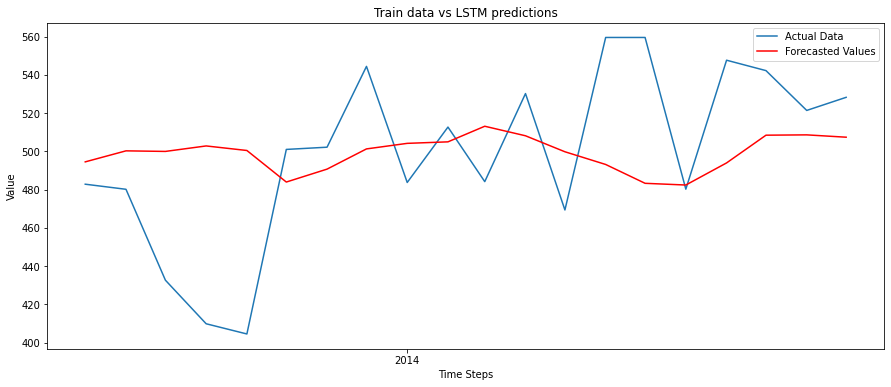

In [281]:
np.random.seed(random_seed)
ts_lstm_train=train.copy()
ts_lstm_test=test.copy()

# ts_lstm_train.drop('Energy',axis=1, inplace=True)
# ts_lstm_test.drop('Energy',axis=1, inplace=True)

tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Duration']):
    train_data, test_data = ts_lstm_train.iloc[train_index, :], ts_lstm_train.iloc[test_index, :]
    
    train_index = train_data.index
    test_index = test_data.index
    
    y_train_lstm=train_data['Duration']
    X_train_lstm=train_data.drop('Duration',axis=1)

    y_test_lstm=test_data['Duration']
    X_test_lstm=test_data.drop('Duration',axis=1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

    model_lstm_multi = lstm(X_train, X_test, y_train, y_test, 200)
    true_train_lstm_multi, true_test_lstm_multi, pred_train_lstm_multi, pred_test_lstm_multi, train_mse_lstm_multi, test_mse_lstm_multi = get_mse_lstm_tcn(
        model_lstm_multi, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs LSTM predictions")
    plot_results(index_test, true_test_lstm_multi, pred_test_lstm_multi)
 
    all_train_mse.append(test_mse_lstm_multi)
    
average_train_mse_lstm_multi = np.mean(all_train_mse)

In [282]:
average_train_mse_lstm_multi

87.62501429894927

In [283]:
train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

y_train_lstm=ts_lstm_train['Duration']
X_train_lstm=ts_lstm_train.drop('Duration',axis=1)

y_test_lstm=ts_lstm_test['Duration']
X_test_lstm=ts_lstm_test.drop('Duration',axis=1)

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

model_lstm_multi = lstm(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 6ms/step - loss: 0.1857
Train Loss: 0.1857180893421173
1/1 [==============================] - 0s 33ms/step - loss: 1.5037
Test Loss: 1.5037164688110352


In [284]:
print("LSTM results:\n")
true_train_lstm_multi, true_test_lstm_multi, pred_train_lstm_multi, pred_test_lstm_multi, train_mse_lstm_multi, test_mse_lstm_multi = get_mse_lstm_tcn(
    model_lstm_multi, X_train, X_test, y_train, y_test, scaler)

LSTM results:

5/5 [==============================] - 0s 9ms/step
MSE on train dataset:  43.26141678828012
R2 on train dataset:  0.8144832892798708
1/1 [==============================] - 0s 21ms/step
MSE on test dataset:  123.09958219660979
R2 on test dataset:  -0.26695768286081156


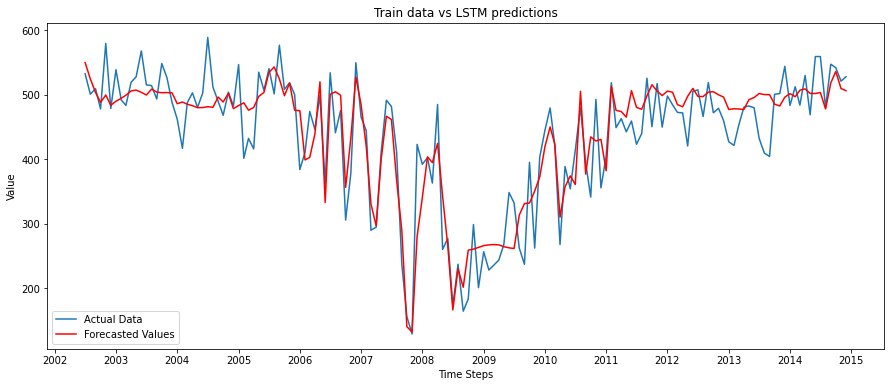

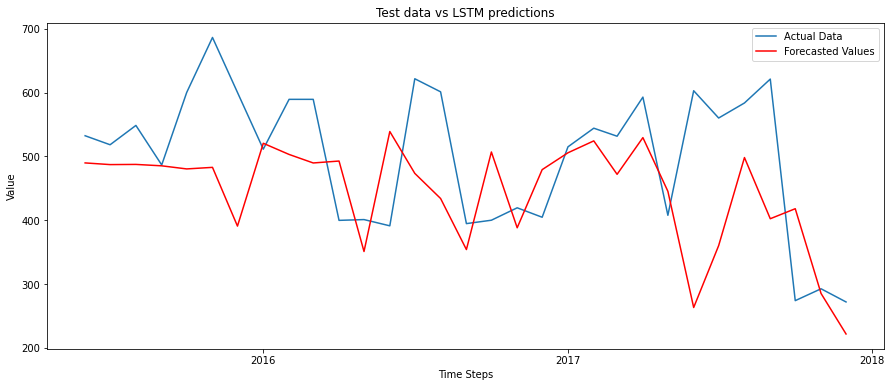

In [285]:
plt.figure(figsize=(15,6))
plt.title("Train data vs LSTM predictions")
plot_results(index_train, true_train_lstm_multi, pred_train_lstm_multi)

plt.figure(figsize=(15,6))
plt.title("Test data vs LSTM predictions")
plot_results(index_test, true_test_lstm_multi, pred_test_lstm_multi)

### TCN

1/1 [==============================] - 0s 110ms/step - loss: 3.2324e-08
Train Loss: 3.232362644212117e-08
1/1 [==============================] - 0s 33ms/step - loss: 8.7079
Test Loss: 8.707870483398438
1/1 [==============================] - 0s 80ms/step
MSE on train dataset:  0.0068941496928696475
R2 on train dataset:  0.9999999652874242
1/1 [==============================] - 0s 39ms/step
MSE on test dataset:  113.25997423422382
R2 on test dataset:  -2.6374737712576857


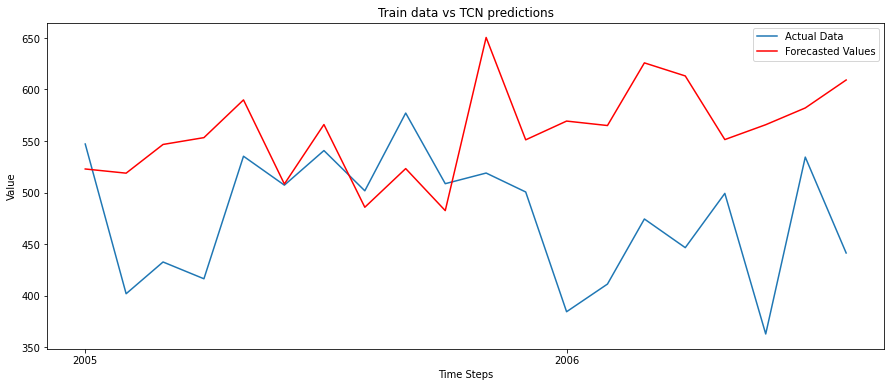

2/2 [==============================] - 0s 15ms/step - loss: 0.0011
Train Loss: 0.0010724333114922047
1/1 [==============================] - 0s 28ms/step - loss: 12.4201
Test Loss: 12.420122146606445
2/2 [==============================] - 0s 4ms/step
MSE on train dataset:  1.6006904487143983
R2 on train dataset:  0.9989130724563388
1/1 [==============================] - 0s 32ms/step
MSE on test dataset:  172.26009862119517
R2 on test dataset:  -1.2096880222481228


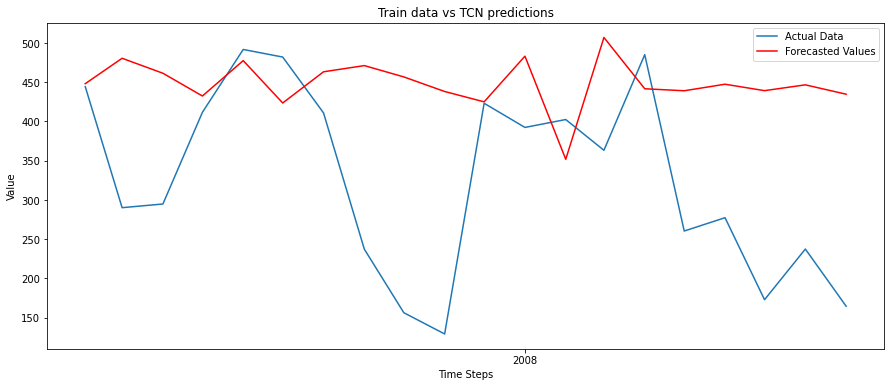

3/3 [==============================] - 0s 6ms/step - loss: 0.0576
Train Loss: 0.057601794600486755
1/1 [==============================] - 0s 25ms/step - loss: 0.8340
Test Loss: 0.8340156674385071
3/3 [==============================] - 0s 3ms/step
MSE on train dataset:  25.000215332742208
R2 on train dataset:  0.9433893178649304
1/1 [==============================] - 0s 29ms/step
MSE on test dataset:  95.1289943898568
R2 on test dataset:  -0.4265321942991569


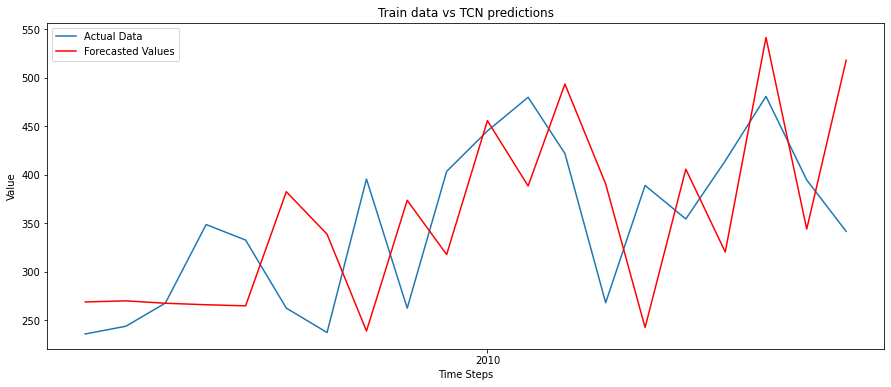

4/4 [==============================] - 0s 6ms/step - loss: 0.0859
Train Loss: 0.08588699251413345
1/1 [==============================] - 0s 17ms/step - loss: 0.2945
Test Loss: 0.29453974962234497
4/4 [==============================] - 0s 4ms/step
MSE on train dataset:  33.29039353026043
R2 on train dataset:  0.9138677422320592
1/1 [==============================] - 0s 17ms/step
MSE on test dataset:  61.64916665179138
R2 on test dataset:  -3.102481886272888


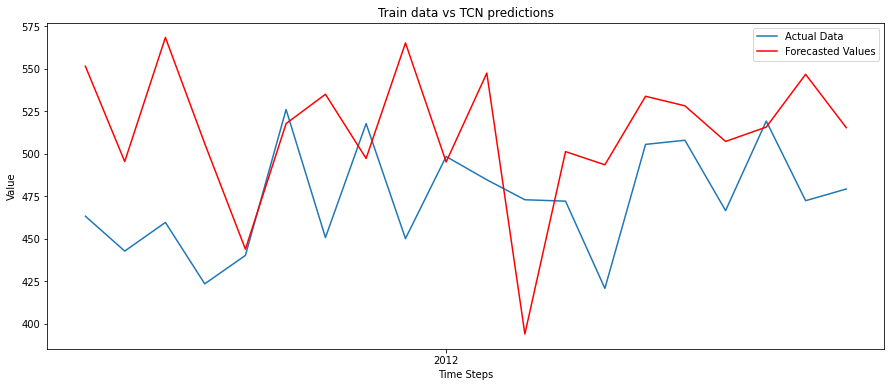

4/4 [==============================] - 0s 5ms/step - loss: 0.0611
Train Loss: 0.061064478009939194
1/1 [==============================] - 0s 31ms/step - loss: 0.3603
Test Loss: 0.3602616488933563
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  25.988744791139183
R2 on train dataset:  0.9388106305229484
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  63.12479445151226
R2 on test dataset:  -1.0046783484822752


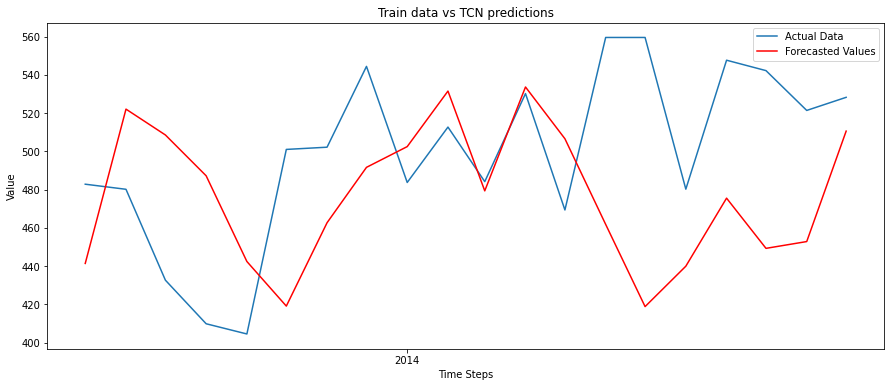

In [286]:
np.random.seed(random_seed)
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Duration']):
    train_data, test_data = ts_lstm_train.iloc[train_index, :], ts_lstm_train.iloc[test_index, :]
    
    train_index = train_data.index
    test_index = test_data.index
    
    y_train_lstm=train_data['Duration']
    X_train_lstm=train_data.drop('Duration',axis=1)

    y_test_lstm=test_data['Duration']
    X_test_lstm=test_data.drop('Duration',axis=1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

    model_tcn_multi = tcn(X_train, X_test, y_train, y_test, 200)
    true_train_tcn_multi, true_test_tcn_multi, pred_train_tcn_multi, pred_test_tcn_multi, train_mse_tcn_multi, test_mse_tcn_multi = get_mse_lstm_tcn(
        model_tcn_multi, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs TCN predictions")
    plot_results(index_test, true_test_tcn_multi, pred_test_tcn_multi)
 
    all_train_mse.append(test_mse_tcn_multi)
    
average_train_mse_tcn_multi = np.mean(all_train_mse)

In [288]:
average_train_mse_tcn_multi

101.0846056697159

In [289]:
train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

y_train_lstm=ts_lstm_train['Duration']
X_train_lstm=ts_lstm_train.drop('Duration',axis=1)

y_test_lstm=ts_lstm_test['Duration']
X_test_lstm=ts_lstm_test.drop('Duration',axis=1)

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

model_tcn_multi = tcn(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 6ms/step - loss: 0.0694
Train Loss: 0.06940823048353195
1/1 [==============================] - 0s 24ms/step - loss: 1.7687
Test Loss: 1.7687093019485474


In [290]:
print("TCN results:\n")
true_train_tcn_multi, true_test_tcn_multi, pred_train_tcn_multi, pred_test_tcn_multi, train_mse_tcn_multi, test_mse_tcn_multi = get_mse_lstm_tcn(
    model_tcn_multi, X_train, X_test, y_train, y_test, scaler)

TCN results:

5/5 [==============================] - 0s 2ms/step
MSE on train dataset:  26.44716280735628
R2 on train dataset:  0.9306670408420789
1/1 [==============================] - 0s 39ms/step
MSE on test dataset:  133.5063149487337
R2 on test dataset:  -0.4902274843771137


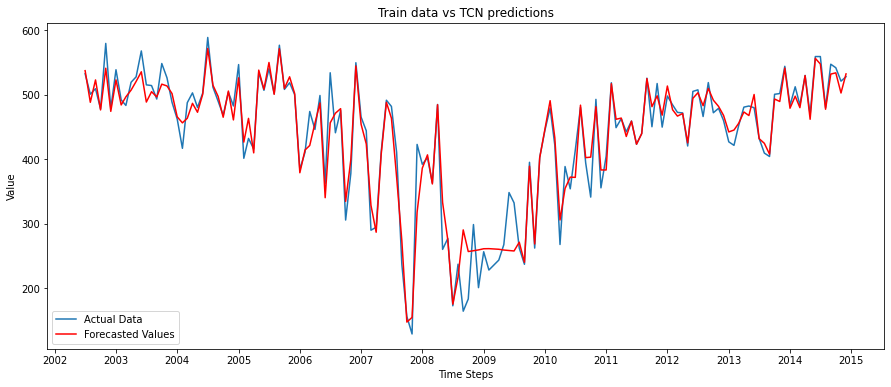

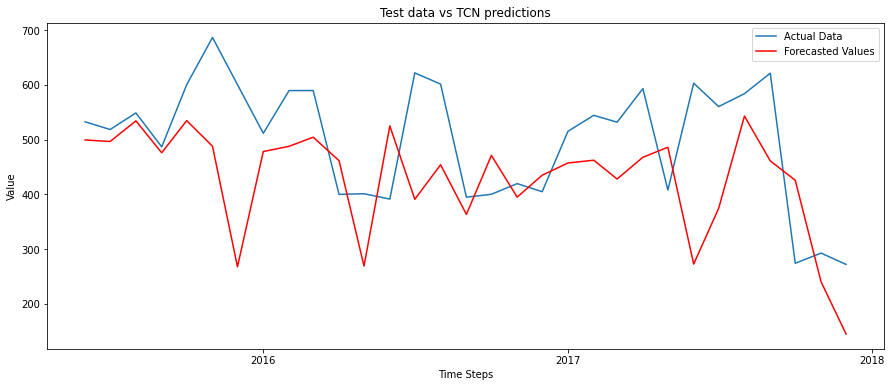

In [291]:
plt.figure(figsize=(15,6))
plt.title("Train data vs TCN predictions")
plot_results(index_train, true_train_tcn_multi, pred_train_tcn_multi)

plt.figure(figsize=(15,6))
plt.title("Test data vs TCN predictions")
plot_results(index_test, true_test_tcn_multi, pred_test_tcn_multi)

### Comparing model performances

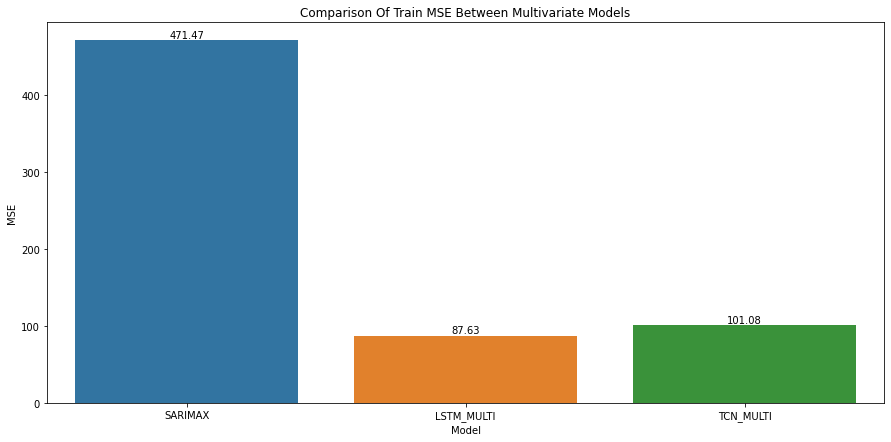

In [292]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Train MSE Between Multivariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[average_train_mse_sarimax, average_train_mse_lstm_multi, average_train_mse_tcn_multi]
sns.barplot(['SARIMAX', 'LSTM_MULTI', 'TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

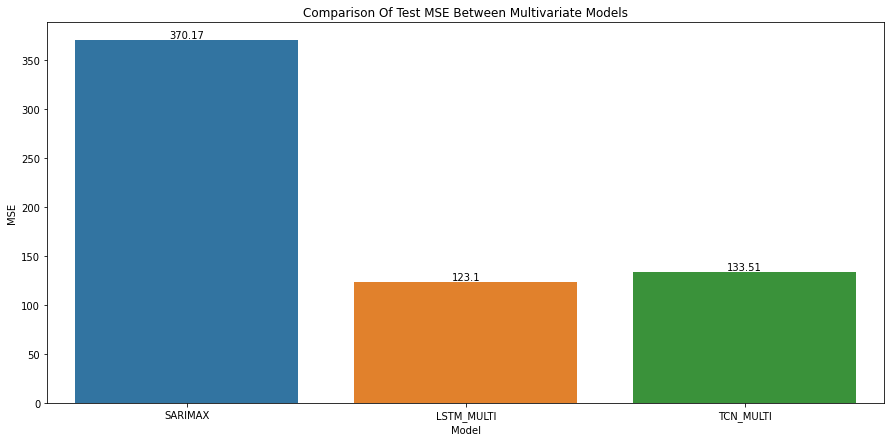

In [293]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Test MSE Between Multivariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[test_mse_sarimax, test_mse_lstm_multi, test_mse_tcn_multi]
sns.barplot(['SARIMAX', 'LSTM_MULTI', 'TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

# Comparing Univariate and Multivariate performances

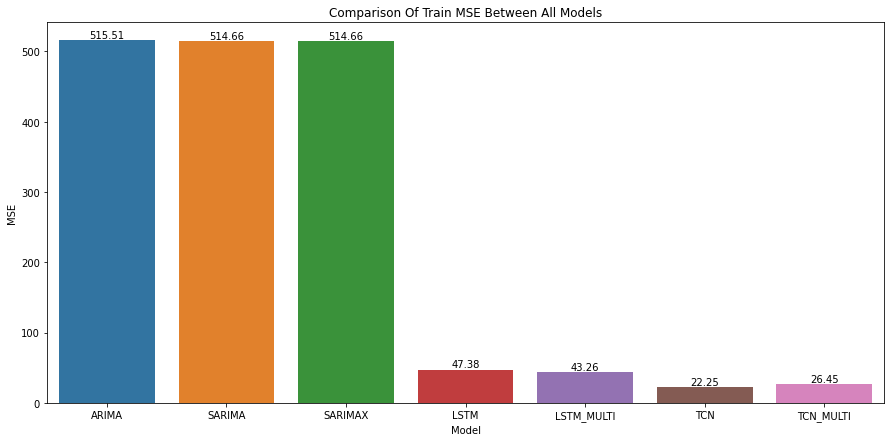

In [295]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Train MSE Between All Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[train_mse_arima, train_mse_sarima, train_mse_sarimax, train_mse_lstm, train_mse_lstm_multi, train_mse_tcn, train_mse_tcn_multi]
sns.barplot(['ARIMA','SARIMA','SARIMAX', 'LSTM','LSTM_MULTI', 'TCN','TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

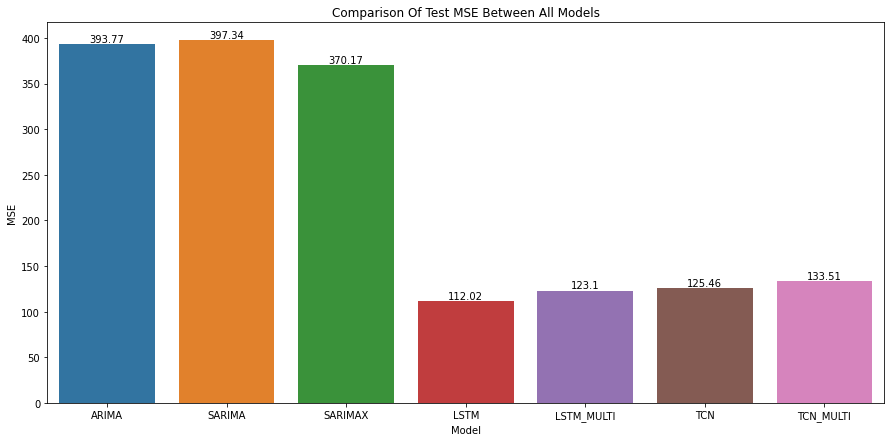

In [296]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Test MSE Between All Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[test_mse_arima, test_mse_sarima, test_mse_sarimax, test_mse_lstm, test_mse_lstm_multi, test_mse_tcn, test_mse_tcn_multi]
sns.barplot(['ARIMA','SARIMA','SARIMAX', 'LSTM','LSTM_MULTI', 'TCN','TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

## Multivariate Analysis

In [745]:
print("Granger Causality between Number and Duration:")
causality_test_result = grangercausalitytests(diff_train[['Number','Duration']], maxlag=3, verbose=True)

print("\n\nGranger Causality between Number and Energy:")
causality_test_result = grangercausalitytests(diff_train[['Number','Energy_encoded']], maxlag=3, verbose=True)

Granger Causality between Number and Duration:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2794  , p=0.5980  , df_denom=138, df_num=1
ssr based chi2 test:   chi2=0.2854  , p=0.5932  , df=1
likelihood ratio test: chi2=0.2852  , p=0.5933  , df=1
parameter F test:         F=0.2794  , p=0.5980  , df_denom=138, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3647  , p=0.6951  , df_denom=135, df_num=2
ssr based chi2 test:   chi2=0.7564  , p=0.6851  , df=2
likelihood ratio test: chi2=0.7544  , p=0.6858  , df=2
parameter F test:         F=0.3647  , p=0.6951  , df_denom=135, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1102  , p=0.3474  , df_denom=132, df_num=3
ssr based chi2 test:   chi2=3.5072  , p=0.3198  , df=3
likelihood ratio test: chi2=3.4636  , p=0.3255  , df=3
parameter F test:         F=1.1102  , p=0.3474  , df_denom=132, df_num=3


Granger Causality between Number and Energy:


### SARIMAX

MSE on train dataset:  379.62358247928506
R2 on train dataset:  -0.19188781877535943
MSE on test dataset:  592.1747899206155
R2 on test dataset:  -1.9487649841066408


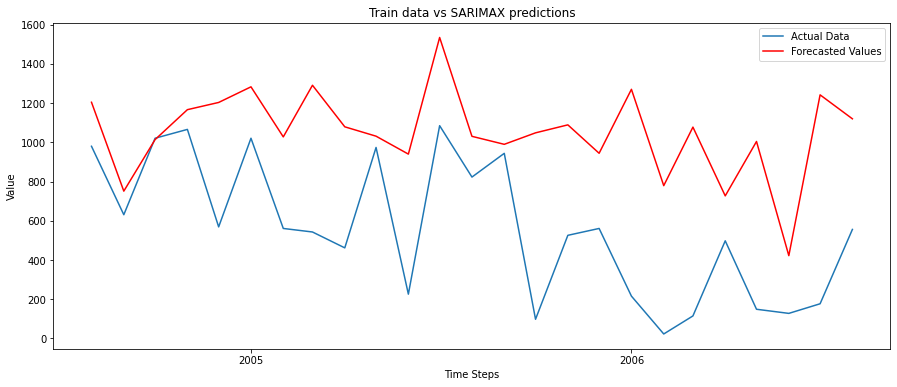

MSE on train dataset:  330.08963482469
R2 on train dataset:  0.3744818001029553
MSE on test dataset:  216.18522494427012
R2 on test dataset:  -0.5055049145392607


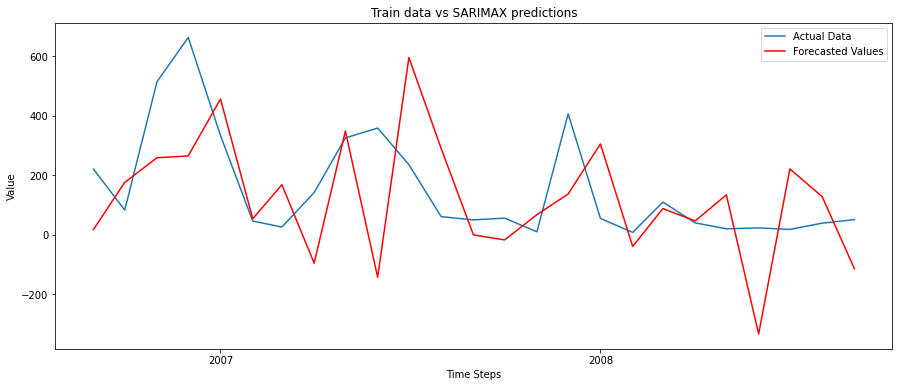

MSE on train dataset:  297.78916701803064
R2 on train dataset:  0.6009518041460611
MSE on test dataset:  168.02610018639473
R2 on test dataset:  -0.8004920902857326


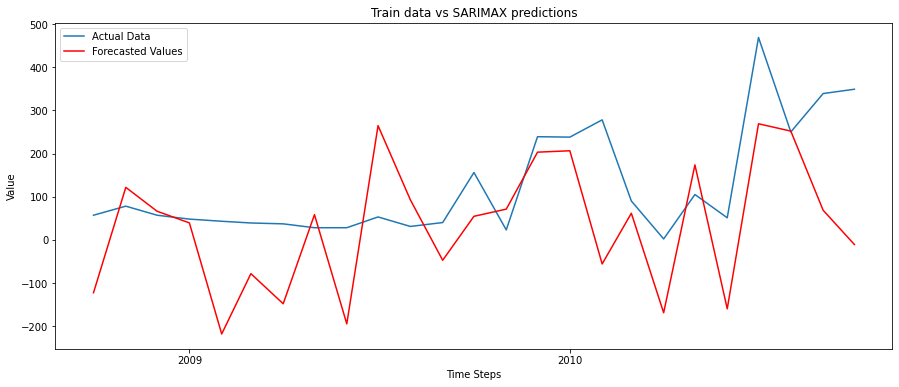

MSE on train dataset:  269.6300191159857
R2 on train dataset:  0.662337778052157
MSE on test dataset:  688.9643925607703
R2 on test dataset:  -1.4383257593917849


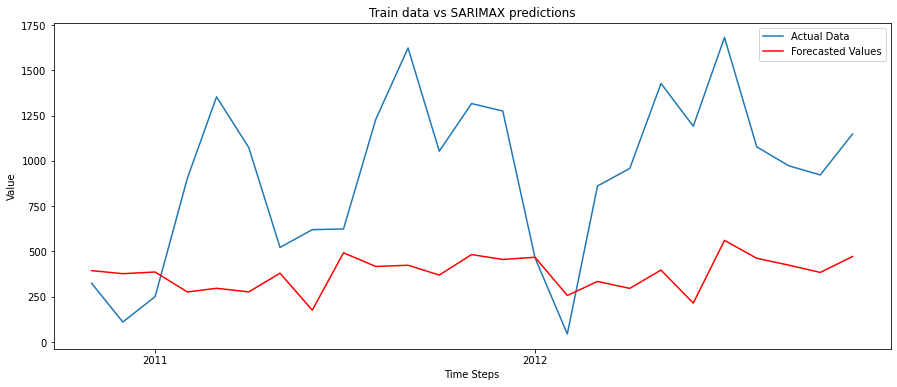

MSE on train dataset:  316.612452963806
R2 on train dataset:  0.5819515361053997
MSE on test dataset:  468.9907926469524
R2 on test dataset:  -0.20645875218741438


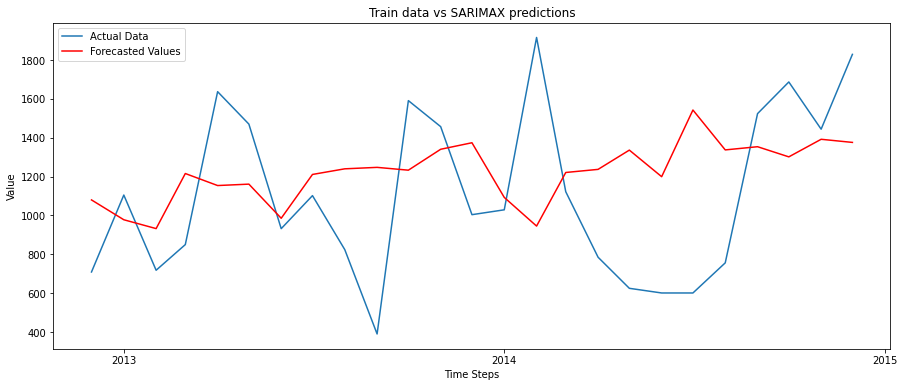

In [702]:
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    model = SARIMAX(train_data['Number'],order=order, seasonal_order=seasonal_order, exog=train_data[['Duration','Energy_encoded']])
    sarimax_results = model.fit()

    pred_train_sarimax, pred_test_sarimax, train_mse_sarimax, test_mse_sarimax = get_mse_arima_sarima(
        sarimax_results, train_data, test_data, True)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs SARIMAX predictions")
    plot_results(test_data.index, test_data['Number'], pred_test_sarimax)
 
    all_train_mse.append(test_mse_sarimax)
    
average_train_mse_sarimax = np.mean(all_train_mse)

In [703]:
average_train_mse_sarimax

426.8682600518006

In [704]:
model = SARIMAX(train['Number'], order=order, seasonal_order=seasonal_order, exog=train[['Duration','Energy_encoded']])  # Example order (p, d, q)
sarimax_results = model.fit()

In [705]:
print("SARIMAX results:\n")
pred_train_sarimax, pred_test_sarimax, train_mse_sarimax, test_mse_sarimax = get_mse_arima_sarima(sarimax_results, train, test, True)

SARIMAX results:

MSE on train dataset:  339.3271569641982
R2 on train dataset:  0.5719163430892895
MSE on test dataset:  1150.3996097281968
R2 on test dataset:  -8.253366654346872


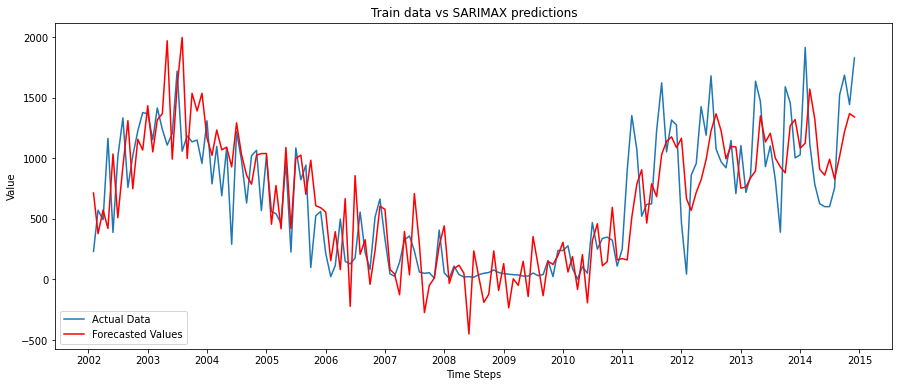

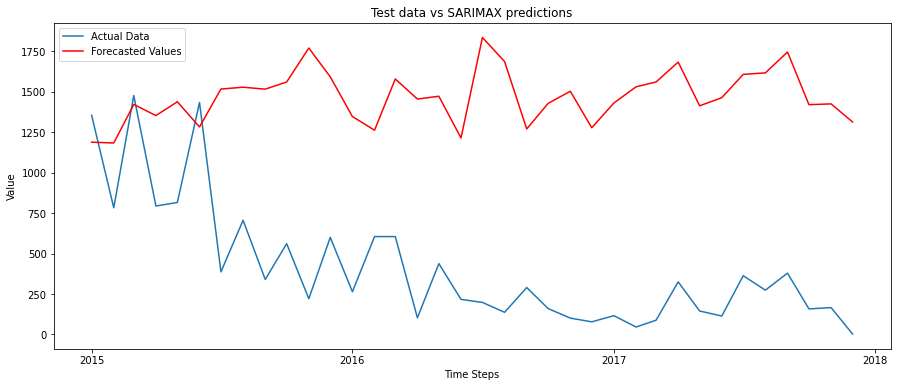

In [706]:
plt.figure(figsize=(15,6))
plt.title("Train data vs SARIMAX predictions")
plot_results(train.index, train['Number'],pred_train_sarimax)

plt.figure(figsize=(15,6))
plt.title("Test data vs SARIMAX predictions")
plot_results(test.index, test['Number'],pred_test_sarimax)

### LSTM

1/1 [==============================] - 0s 346ms/step - loss: 0.1589
Train Loss: 0.15893347561359406
1/1 [==============================] - 0s 36ms/step - loss: 18.9485
Test Loss: 18.94850730895996
1/1 [==============================] - 0s 328ms/step
MSE on train dataset:  138.6255160714749
R2 on train dataset:  0.743329082791649
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  1513.6411453464757
R2 on test dataset:  -19.748742179051643


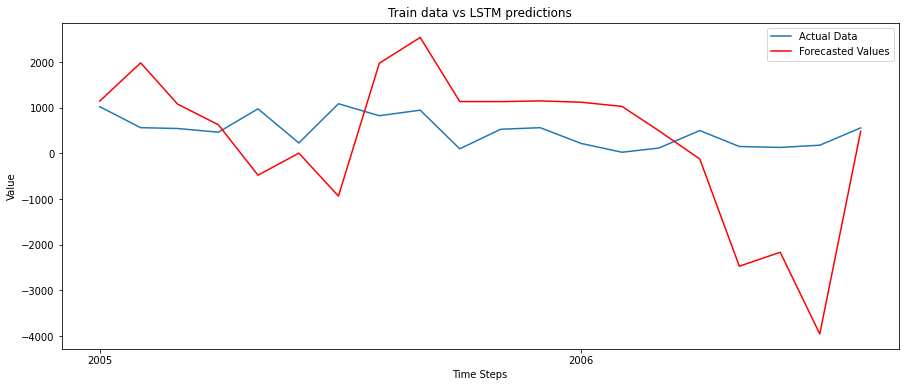

2/2 [==============================] - 0s 21ms/step - loss: 0.3617
Train Loss: 0.36171793937683105
1/1 [==============================] - 0s 31ms/step - loss: 55.2804
Test Loss: 55.2804069519043
2/2 [==============================] - 0s 10ms/step
MSE on train dataset:  251.01342818731757
R2 on train dataset:  0.6398047884261091
1/1 [==============================] - 0s 40ms/step
MSE on test dataset:  3103.113020064012
R2 on test dataset:  -653.7554794423703


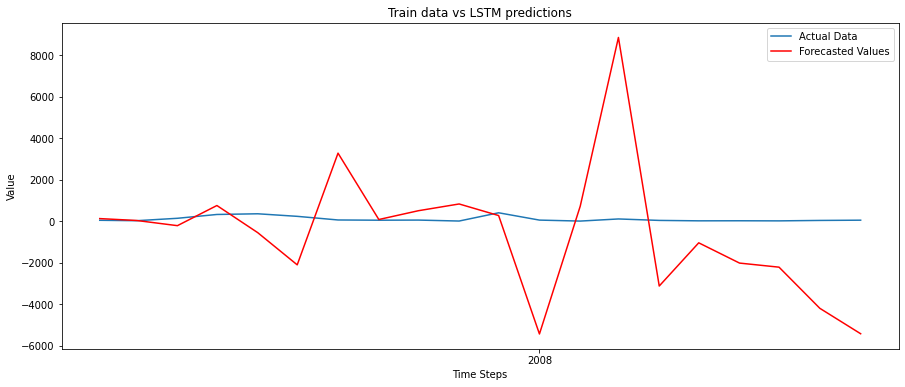

3/3 [==============================] - 0s 9ms/step - loss: 0.3219
Train Loss: 0.3218982517719269
1/1 [==============================] - 0s 31ms/step - loss: 0.0663
Test Loss: 0.06632955372333527
3/3 [==============================] - 0s 8ms/step
MSE on train dataset:  267.4579431047914
R2 on train dataset:  0.6892037506710182
1/1 [==============================] - 0s 32ms/step
MSE on test dataset:  121.40868353537755
R2 on test dataset:  0.1855275190383603


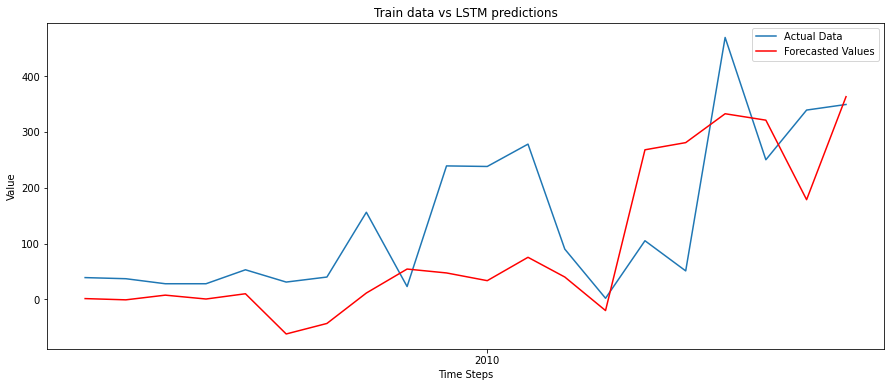

4/4 [==============================] - 0s 5ms/step - loss: 0.2945
Train Loss: 0.2945033013820648
1/1 [==============================] - 0s 31ms/step - loss: 1.0504
Test Loss: 1.0504162311553955
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  251.8094827026261
R2 on train dataset:  0.7126710694589828
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  475.5626523434381
R2 on test dataset:  -0.4696592495084071


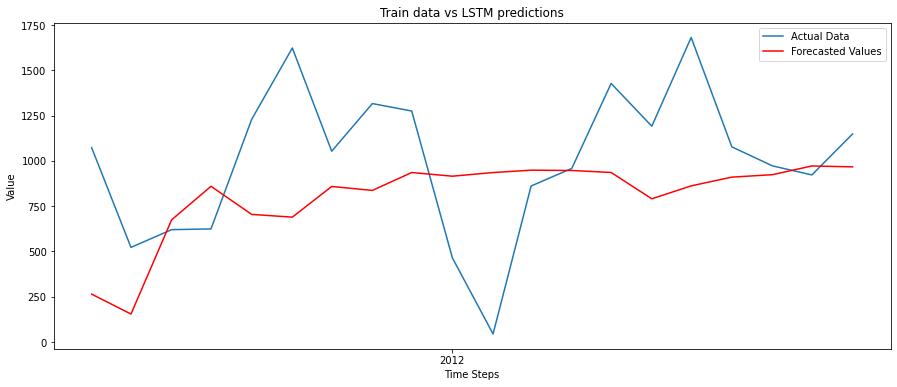

4/4 [==============================] - 0s 5ms/step - loss: 0.3122
Train Loss: 0.3122450113296509
1/1 [==============================] - 0s 31ms/step - loss: 1.3408
Test Loss: 1.3407970666885376
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  273.6291995788652
R2 on train dataset:  0.6947890038913147
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  567.0171370935411
R2 on test dataset:  -0.6546564639627424


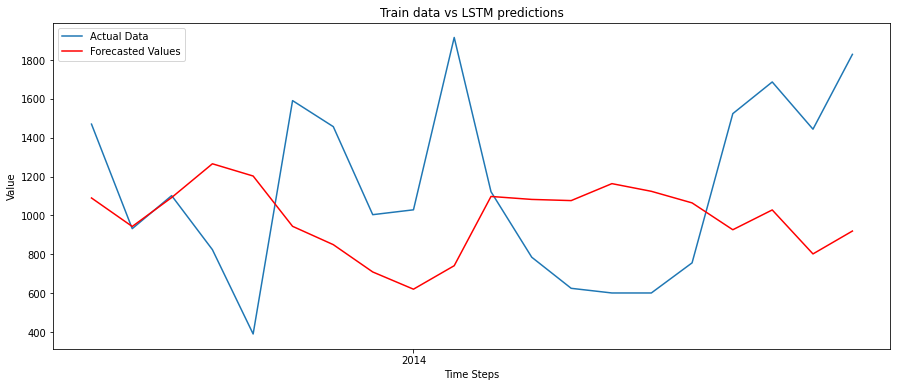

In [707]:
ts_lstm_train=train.copy()
ts_lstm_test=test.copy()

tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Number']):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    
    train_index = train_data.index
    test_index = test_data.index
    
    y_train_lstm=train_data['Number']
    X_train_lstm=train_data.drop('Number',axis=1)

    y_test_lstm=test_data['Number']
    X_test_lstm=test_data.drop('Number',axis=1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

    model_lstm_multi = lstm(X_train, X_test, y_train, y_test, 200)
    true_train_lstm_multi, true_test_lstm_multi, pred_train_lstm_multi, pred_test_lstm_multi, train_mse_lstm_multi, test_mse_lstm_multi = get_mse_lstm_tcn(
        model_lstm_multi, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs LSTM predictions")
    plot_results(index_test, true_test_lstm_multi, pred_test_lstm_multi)
 
    all_train_mse.append(test_mse_lstm_multi)
    
average_train_mse_lstm_multi = np.mean(all_train_mse)



In [708]:
average_train_mse_lstm_multi

1156.148527676569

In [709]:
train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

y_train_lstm=ts_lstm_train['Number']
X_train_lstm=ts_lstm_train.drop('Number',axis=1)

y_test_lstm=ts_lstm_test['Number']
X_test_lstm=ts_lstm_test.drop('Number',axis=1)

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

model_lstm_multi = lstm(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 4ms/step - loss: 0.2966
Train Loss: 0.2965620756149292
1/1 [==============================] - 0s 29ms/step - loss: 2.2858
Test Loss: 2.2858381271362305


In [710]:
print("LSTM results:\n")
true_train_lstm_multi, true_test_lstm_multi, pred_train_lstm_multi, pred_test_lstm_multi, train_mse_lstm_multi, test_mse_lstm_multi = get_mse_lstm_tcn(
    model_lstm_multi, X_train, X_test, y_train, y_test, scaler)

LSTM results:

5/5 [==============================] - 0s 6ms/step
MSE on train dataset:  282.4308256281482
R2 on train dataset:  0.7091584845128511
1/1 [==============================] - 0s 37ms/step
MSE on test dataset:  784.1100633778138
R2 on test dataset:  -7.081612697981436


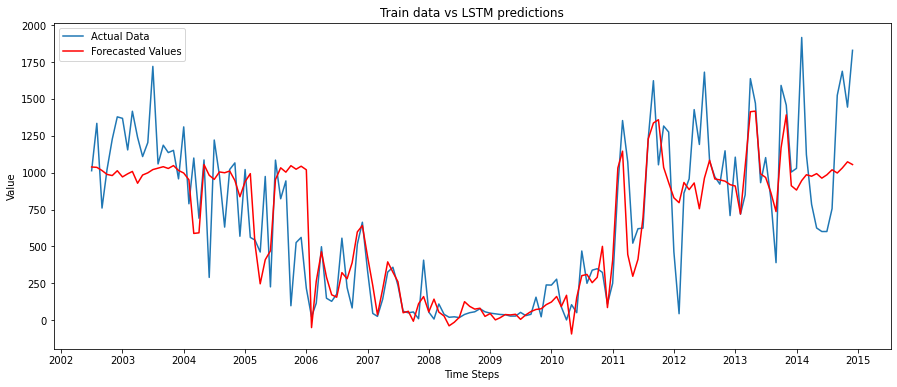

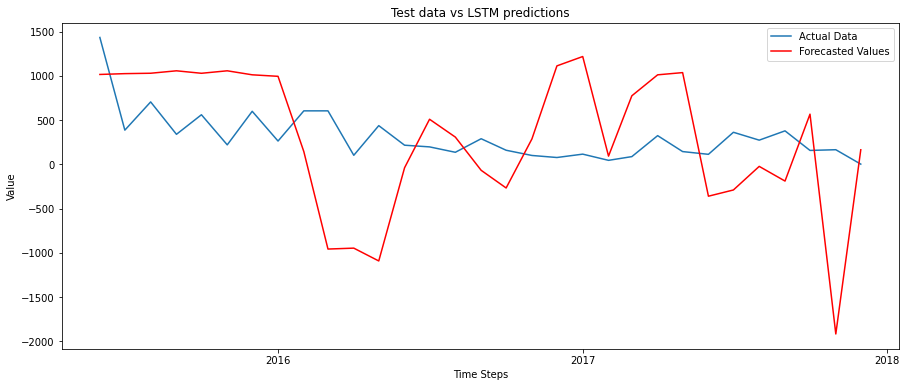

In [711]:
plt.figure(figsize=(15,6))
plt.title("Train data vs LSTM predictions")
plot_results(index_train, true_train_lstm_multi, pred_train_lstm_multi)

plt.figure(figsize=(15,6))
plt.title("Test data vs LSTM predictions")
plot_results(index_test, true_test_lstm_multi, pred_test_lstm_multi)

### TCN

1/1 [==============================] - 0s 111ms/step - loss: 1.1089e-08
Train Loss: 1.1088611806542303e-08
1/1 [==============================] - 0s 16ms/step - loss: 3.8245
Test Loss: 3.8245232105255127
1/1 [==============================] - 0s 110ms/step
MSE on train dataset:  0.036611459609207926
R2 on train dataset:  0.9999999820970583
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  680.0238526098001
R2 on test dataset:  -3.187879891610665


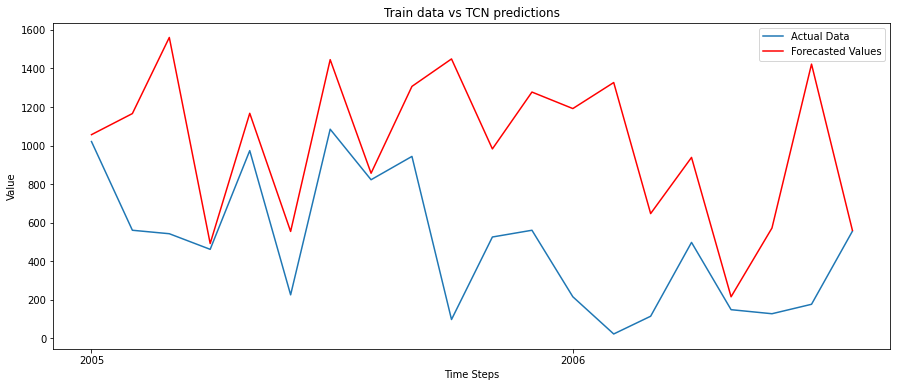

2/2 [==============================] - 0s 16ms/step - loss: 0.0030
Train Loss: 0.003001892939209938
1/1 [==============================] - 0s 31ms/step - loss: 5.0606
Test Loss: 5.060629844665527
2/2 [==============================] - 0s 8ms/step
MSE on train dataset:  22.867017560857715
R2 on train dataset:  0.9970107442353044
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  938.8890375946181
R2 on test dataset:  -58.93941377613396


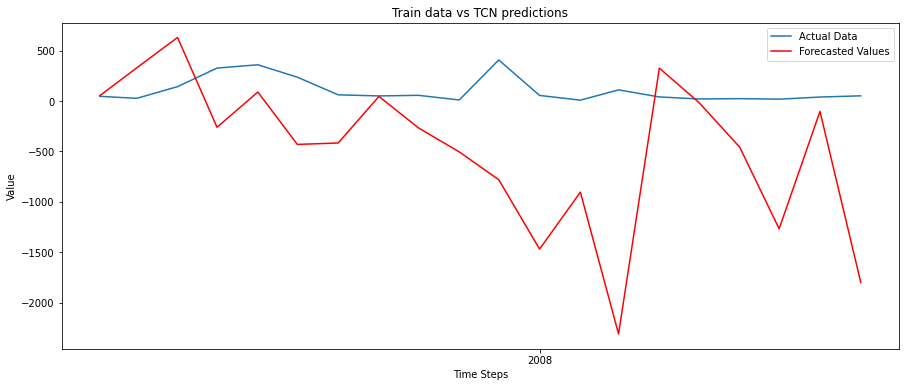

3/3 [==============================] - 0s 0s/step - loss: 0.1806
Train Loss: 0.18061158061027527
1/1 [==============================] - 0s 32ms/step - loss: 0.2703
Test Loss: 0.27033379673957825
3/3 [==============================] - 0s 3ms/step
MSE on train dataset:  200.34062387463302
R2 on train dataset:  0.8256175350748063
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  245.1017199636268
R2 on test dataset:  -2.3194767634886024


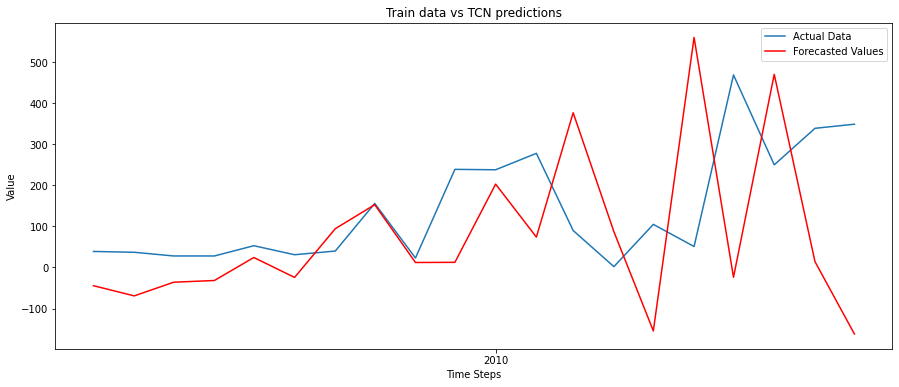

4/4 [==============================] - 0s 0s/step - loss: 0.1868
Train Loss: 0.18675287067890167
1/1 [==============================] - 0s 16ms/step - loss: 1.3990
Test Loss: 1.399034857749939
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  200.52134239566968
R2 on train dataset:  0.8177966316600997
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  548.8343436195646
R2 on test dataset:  -0.9574186896675938


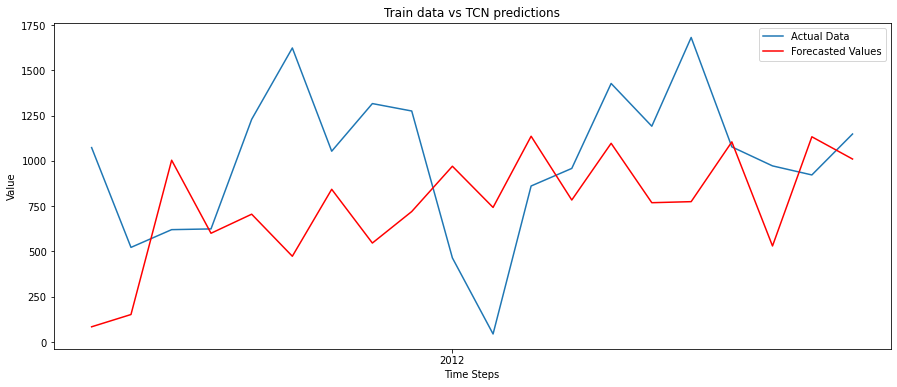

4/4 [==============================] - 0s 0s/step - loss: 0.1428
Train Loss: 0.14278243482112885
1/1 [==============================] - 0s 10ms/step - loss: 1.3832
Test Loss: 1.3832199573516846
4/4 [==============================] - 0s 5ms/step
MSE on train dataset:  185.03422732882333
R2 on train dataset:  0.8604340622350913
1/1 [==============================] - 0s 16ms/step
MSE on test dataset:  575.9175240857209
R2 on test dataset:  -0.70700996919307


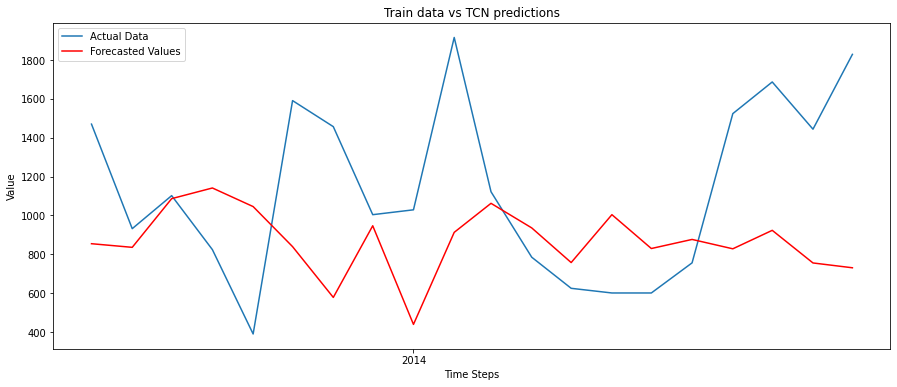

In [712]:
tscv = TimeSeriesSplit(n_splits=5)
all_train_mse = []

for train_index, test_index in tscv.split(ts_lstm_train['Number']):
    train_data, test_data = train.iloc[train_index, :], train.iloc[test_index, :]
    
    train_index = train_data.index
    test_index = test_data.index
    
    y_train_lstm=train_data['Number']
    X_train_lstm=train_data.drop('Number',axis=1)

    y_test_lstm=test_data['Number']
    X_test_lstm=test_data.drop('Number',axis=1)

    X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
    X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

    model_tcn_multi = tcn(X_train, X_test, y_train, y_test, 200)
    true_train_tcn_multi, true_test_tcn_multi, pred_train_tcn_multi, pred_test_tcn_multi, train_mse_tcn_multi, test_mse_tcn_multi = get_mse_lstm_tcn(
        model_tcn_multi, X_train, X_test, y_train, y_test, scaler)
    
    plt.figure(figsize=(15,6))
    plt.title("Train data vs TCN predictions")
    plot_results(index_test, true_test_tcn_multi, pred_test_tcn_multi)
 
    all_train_mse.append(test_mse_tcn_multi)
    
average_train_mse_tcn_multi = np.mean(all_train_mse)

In [713]:
average_train_mse_tcn_multi

597.753295574666

In [714]:
train_index = ts_lstm_train.index
test_index = ts_lstm_test.index

y_train_lstm=ts_lstm_train['Number']
X_train_lstm=ts_lstm_train.drop('Number',axis=1)

y_test_lstm=ts_lstm_test['Number']
X_test_lstm=ts_lstm_test.drop('Number',axis=1)

X_train, X_test, y_train, y_test, index_train, index_test, scaler = prepare_data_lstm_tcn(
X_train_lstm, X_test_lstm, 5, train_index, test_index, y_train_lstm, y_test_lstm)

model_tcn_multi = tcn(X_train, X_test, y_train, y_test, 200)

5/5 [==============================] - 0s 5ms/step - loss: 0.1014
Train Loss: 0.10143251717090607
1/1 [==============================] - 0s 16ms/step - loss: 1.9158
Test Loss: 1.9158236980438232


In [715]:
print("TCN results:\n")
true_train_tcn_multi, true_test_tcn_multi, pred_train_tcn_multi, pred_test_tcn_multi, train_mse_tcn_multi, test_mse_tcn_multi = get_mse_lstm_tcn(
    model_tcn_multi, X_train, X_test, y_train, y_test, scaler)

TCN results:

5/5 [==============================] - 0s 1ms/step
MSE on train dataset:  165.17446084060532
R2 on train dataset:  0.9005240710462212
1/1 [==============================] - 0s 23ms/step
MSE on test dataset:  717.8473113334845
R2 on test dataset:  -5.773422005239046


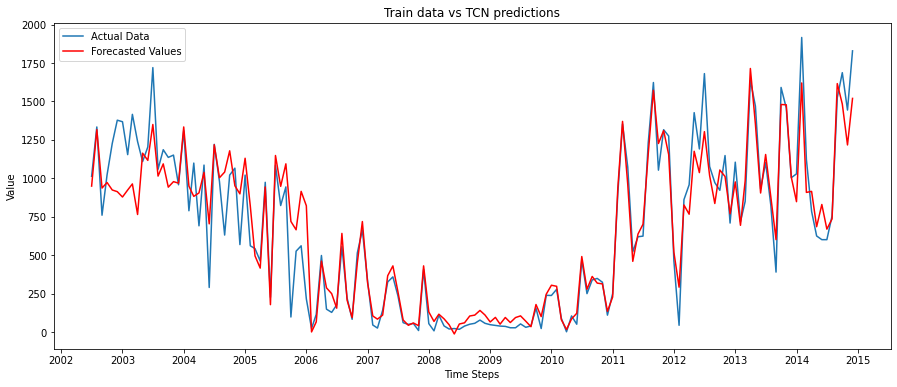

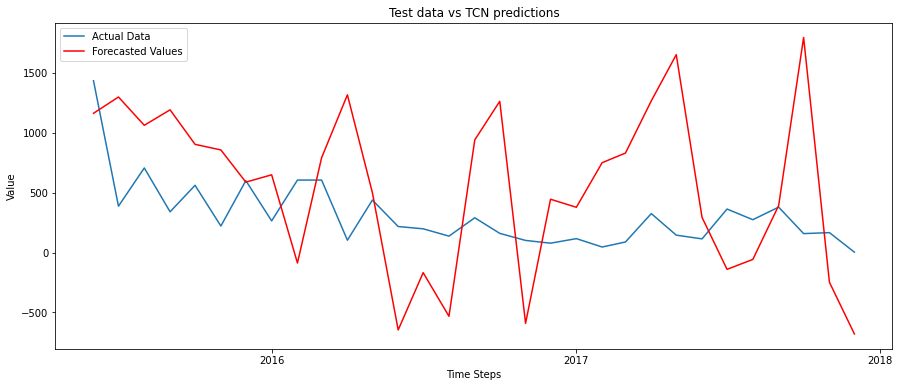

In [716]:
plt.figure(figsize=(15,6))
plt.title("Train data vs TCN predictions")
plot_results(index_train, true_train_tcn_multi, pred_train_tcn_multi)

plt.figure(figsize=(15,6))
plt.title("Test data vs TCN predictions")
plot_results(index_test, true_test_tcn_multi, pred_test_tcn_multi)

### Comparing model performances

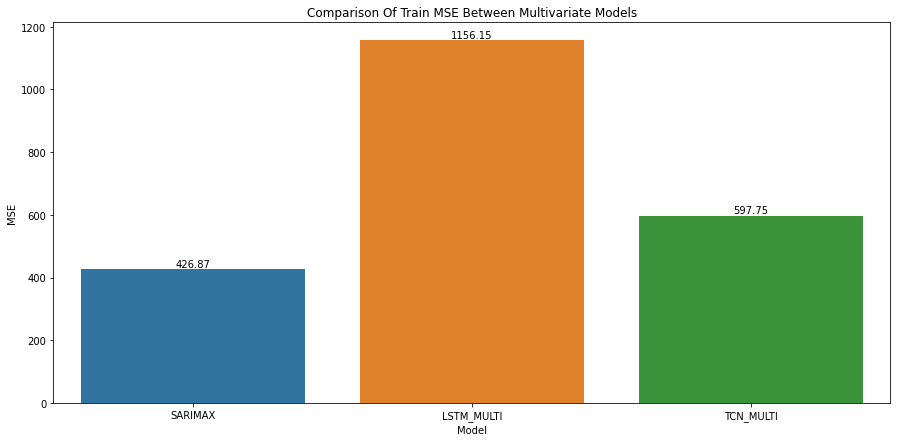

In [717]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Train MSE Between Multivariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[average_train_mse_sarimax, average_train_mse_lstm_multi, average_train_mse_tcn_multi]
sns.barplot(['SARIMAX', 'LSTM_MULTI', 'TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

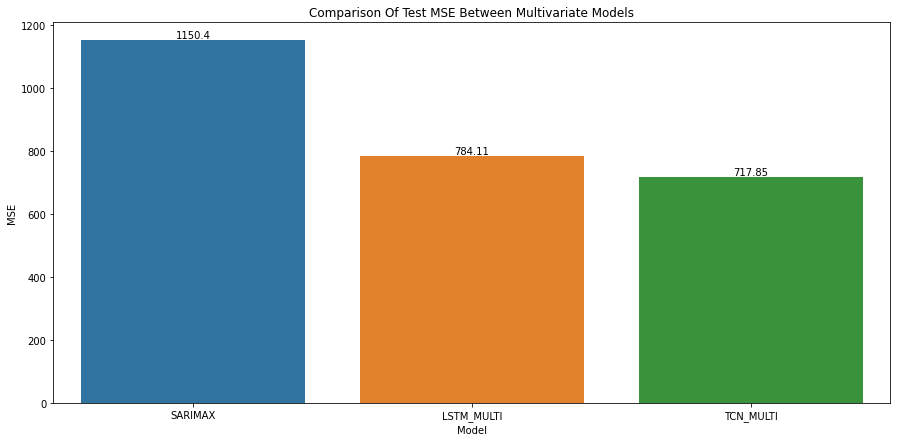

In [718]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Test MSE Between Multivariate Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[test_mse_sarimax, test_mse_lstm_multi, test_mse_tcn_multi]
sns.barplot(['SARIMAX', 'LSTM_MULTI', 'TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

# Comparing Univariate and Multivariate performances

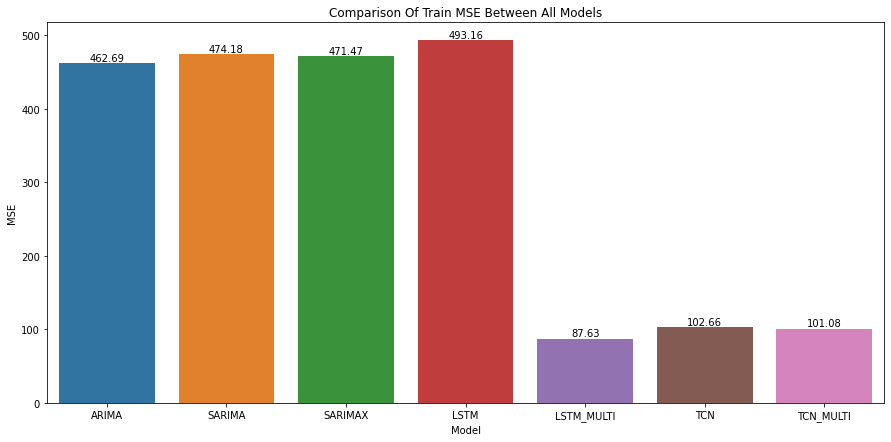

In [297]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Train MSE Between All Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[average_train_mse_arima, average_train_mse_sarima, average_train_mse_sarimax, average_train_mse_lstm, average_train_mse_lstm_multi, average_train_mse_tcn, average_train_mse_tcn_multi]
sns.barplot(['ARIMA','SARIMA','SARIMAX', 'LSTM','LSTM_MULTI', 'TCN','TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()

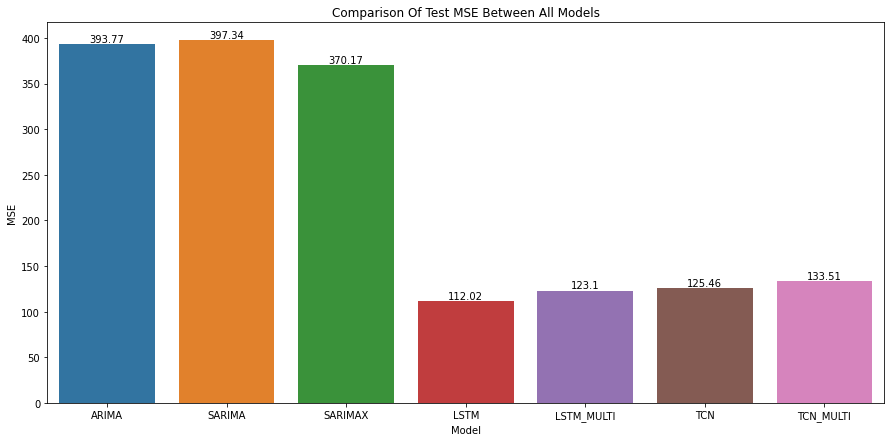

In [299]:
plt.figure(figsize=(15, 7))
plt.title("Comparison Of Test MSE Between All Models")
plt.xlabel('Model')
plt.ylabel('MSE')
mse_list=[test_mse_arima, test_mse_sarima, test_mse_sarimax, test_mse_lstm, test_mse_lstm_multi, test_mse_tcn, test_mse_tcn_multi]
sns.barplot(['ARIMA','SARIMA','SARIMAX', 'LSTM','LSTM_MULTI', 'TCN','TCN_MULTI'],mse_list)
for i, value in enumerate(mse_list):
    plt.text(i, value, str(round(value,2)), ha='center', va='bottom')
plt.show()